In [1]:
import copy
import glob
import gzip
import json
import os
import pickle
import shutil
import sys
import time
import warnings
import zipfile
import numba
from datetime import date
import h5py 

import cdsapi
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr


import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
import seaborn

import trajectory as trj
from collections import defaultdict

sys.path.insert(0, os.getcwd() + "/../resort/rasotools-master/")
import rasotools


import ray

In [2]:
matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)
font = {
    "size": 20,
}
matplotlib.rc("font", **font)

warnings.filterwarnings("ignore")

%load_ext line_profiler

# ray.init(num_cpus=20)

In [3]:
# @numba.jit(nopython=True)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# @numba.jit()
def drop_dims(input_array):
    input_array = np.array(input_array)
    dim = []
    for i in list(np.shape(input_array)):
        if i != 1:
            dim.append(i)
    return input_array.reshape(dim)

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

In [26]:
# def calc_station(sid, year, selected_mons = None):


def calc_station(sid, year, var, selected_mons = None):
    # sid = '11035'
    # year = 2000
    # selected_mons = None

    varsel_dict = {'eastward windspeed':'u', 'northward windspeed':'v', 'air temperature':'t'}
    varsel = varsel_dict[var]
    era_dict = {'t':'130','u':'131','v':'132','q':'133'}
    varsel_era = era_dict[varsel]
     
    print(sid)
    
    show_date = False
    diff = True
    stat = sid
    compare_to = 'fc' # fc

    if selected_mons == None:
        selected_mons = [1,2,3,4,5,6,7,8,9,10,11,12]

    maxtimediff = pd.Timedelta(hours=2)

    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    conv_file = glob.glob('/scratch/das/federico/COP2_HARVEST_JAN2023/igra2/*' + stat + '*.nc')[0]
    df_dict = {}
    df_dict_w = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
    rmse_sum_shbase_sonde={}
    rmse_sum_shdisp_sonde={}
    rms_sum_shbase={}
    rms_sum_sonde={}
    rms_sum_shdisp={}
    rms_sum_dispminusbase={}

    for i in stdplevs:
        rmse_sum_shbase_sonde[i] = []
        rmse_sum_shdisp_sonde[i] = []
        rms_sum_shbase[i] = []
        rms_sum_sonde[i] = []
        rms_sum_shdisp[i] = []
        rms_sum_dispminusbase[i] = []
    try:
        with h5py.File(conv_file, 'r') as file:
            rts = file['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
            if len(idx) == 0:
                print('NO DATA FOUND IN IGRA: ', sid)
                return [rmse_sum_shbase_sonde, rmse_sum_shdisp_sonde,
                        rms_sum_shbase, rms_sum_sonde,
                        rms_sum_shdisp, rms_sum_dispminusbase]

            t_idx = file['recordindex'][idx]
            plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]

            p_mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
            v_mask = file['observations_table']['observed_variable'][t_idx[0]:t_idx[-1]]
            mask_t = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [126]))
            mask_wd = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [106]))
            mask_ws = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [107]))
            t_len = len(mask_t[mask_t == True])

            # wind data
            df_dict_w['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_wd])
            df_dict_w['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_wd])
            df_dict_w['date_time'] = seconds_to_datetime(df_dict_w['date_time'])
            df_dict_w['wd'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_wd])
            df_dict_w['ws'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_ws])
            df_dict_w['u'] = - np.abs(df_dict_w['ws']) * np.sin(np.radians(df_dict_w['wd']))
            df_dict_w['v'] = - np.abs(df_dict_w['ws']) * np.cos(np.radians(df_dict_w['wd']))

            #temperature data
            df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_t])
            df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_t])
            df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
            df_dict['t'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_t])

            #meta data
            df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask_t])
            df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask_t])
            repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask_t])
            df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

            df_t = pd.DataFrame.from_dict(df_dict)
            df_w = pd.DataFrame.from_dict(df_dict_w)

            df = pd.merge(df_t, df_w[['z_coordinate', 'date_time', 'u', 'v']], on=['z_coordinate', 'date_time'], how='inner')
            
            lat_disp, lon_disp, sec_disp = np.array([np.nan]*len(df)),np.array([np.nan]*len(df)),np.array([np.nan]*len(df))
            
            for rid in df.report_id.drop_duplicates():
                df_j = df[df.report_id == rid].copy()
                df_j_cleanded = df_j.sort_values(by='z_coordinate', ascending=False).dropna(subset=['t', 'u', 'v'])
                if len(df_j_cleanded) > 3:

                    idx =  df_j_cleanded.index.values
                    lat_i, lon_i, sec_i = trj.trajectory(df_j_cleanded.latitude.iloc[0], 
                                                         df_j_cleanded.longitude.iloc[0], 
                                                         df_j_cleanded.u.values, 
                                                         df_j_cleanded.v.values, 
                                                         df_j_cleanded.z_coordinate.values, 
                                                         df_j_cleanded.t.values
                                                        )
                    lat_disp[idx] = lat_i
                    lon_disp[idx] = lon_i
                    sec_disp[idx] = sec_i
            df['latitude_displacement'] = lat_disp
            df['longitude_displacement'] = lon_disp
            df['time_displacement'] = sec_disp



    except:
        print('NO DATA FOUND IN IGRA: ', sid)
        return [rmse_sum_shbase_sonde, rmse_sum_shdisp_sonde,
                rms_sum_shbase, rms_sum_sonde,
                rms_sum_shdisp, rms_sum_dispminusbase]
    df = df.dropna()
    if len(df) == 0:
        print('NO DATA FOUND IN IGRA: ', sid)
        return [rmse_sum_shbase_sonde, rmse_sum_shdisp_sonde,
                rms_sum_shbase, rms_sum_sonde,
                rms_sum_shdisp, rms_sum_dispminusbase]

    for mon in selected_mons:

        df_mon = df[df.date_time.dt.month == mon]
    #     display(df_mon)
        t0 = time.time()
        if compare_to == 'fc':
            files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.' + str(year) + str(mon).zfill(2) + '*.' + varsel_era + '.nc')[0]
        else:
            files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.' + str(year) + str(mon).zfill(2) + '*.' + varsel_era + '.nc')[0]
        ds_fc = xr.load_dataset(files)
        print('loading era5 data: ', time.time() - t0)
        t0 = time.time()

        t0 = time.time()     
        ##
        ## change to report id
        ##
        for day in df_mon.date_time.drop_duplicates()[:]:

            input_data = df_mon[df_mon.date_time == day]
            ds_fc_time = ds_fc.sel(time=day, method='nearest')
    #             print(day, pd.Timestamp(ds_fc_time.time.values))
            if (pd.Timestamp(ds_fc_time.time.values) - day) > maxtimediff:
                continue
            t_list = []
            for i in np.array(ds_fc_time.level): #10,20,...,1000
                step = find_nearest(input_data.z_coordinate, i*100)
                ###
                input_data_step = input_data[input_data.z_coordinate == step]
                station_lat = input_data.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]### why array?
                station_lon = input_data.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
                lon = station_lon
                if lon < 0:
                    lon = 360.+lon
                ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
                t = ds_now[varsel].sel(level = i)
                t_list.append(float(t))

            p_ml = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
            lon = input_data.longitude.iloc[0]
            if lon < 0:
                lon = 360.+lon
            base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude.iloc[0]], longitude=[lon], method="linear")[varsel])
            for i in range(len(stdplevs)):
                if np.abs(stdplevs[i] - find_nearest(input_data.z_coordinate,stdplevs[i])) > 500:
                    rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                    rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                    rms_sum_shbase[stdplevs[i]].append(np.nan)
                    rms_sum_sonde[stdplevs[i]].append(np.nan)
                    rms_sum_shdisp[stdplevs[i]].append(np.nan)
                    rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

                else:
                    sq_t = np.squeeze(base_t)
                    t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
                    t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
                    input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
                    t_sonde = float(input_data_step[varsel])

                    rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                    rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                    rms_sum_shbase[stdplevs[i]].append(t_base)
                    rms_sum_sonde[stdplevs[i]].append(t_sonde)
                    rms_sum_shdisp[stdplevs[i]].append(t_disp)
                    rms_sum_dispminusbase[stdplevs[i]].append(t_disp-t_base)

        print('calculating mon: ',mon, time.time() - t0)
        break

    return [rmse_sum_shbase_sonde, rmse_sum_shdisp_sonde,
            rms_sum_shbase, rms_sum_sonde,
            rms_sum_shdisp, rms_sum_dispminusbase]

In [4]:
sid = '70219'
year = 2000
var = 'air temperature'
selected_mons = None

varsel_dict = {'eastward windspeed':'u', 'northward windspeed':'v', 'air temperature':'t'}
varsel = varsel_dict[var]
era_dict = {'t':'130','u':'131','v':'132','q':'133'}
varsel_era = era_dict[varsel]

print(sid)

show_date = False
diff = True
stat = sid
compare_to = 'fc' # fc

if selected_mons == None:
    selected_mons = [1,2,3,4,5,6,7,8,9,10,11,12]

maxtimediff = pd.Timedelta(hours=2)

dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

conv_file = glob.glob('/scratch/das/federico/COP2_HARVEST_JAN2023/igra2/*' + stat + '*.nc')[0]
df_dict = {}
df_dict_w = {}
df_dict_h = {}


stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
rmse_sum_shbase_sonde={}
rmse_sum_shdisp_sonde={}
rms_sum_shbase={}
rms_sum_sonde={}
rms_sum_shdisp={}
rms_sum_dispminusbase={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []
    rms_sum_dispminusbase[i] = []
    
with h5py.File(conv_file, 'r') as file:
    rts = file['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    if len(idx) == 0:
        print('NO DATA FOUND IN IGRA: ', sid)

    t_idx = file['recordindex'][idx]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]

    p_mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
    v_mask = file['observations_table']['observed_variable'][t_idx[0]:t_idx[-1]]
    mask_t = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [126]))
    mask_wd = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [106]))
    mask_ws = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [107]))
    mask_rh = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [138]))
    t_len = len(mask_t[mask_t == True])

    # wind data
    df_dict_w['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_wd])
    df_dict_w['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_wd])
    df_dict_w['date_time'] = seconds_to_datetime(df_dict_w['date_time'])
    df_dict_w['wd'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_wd])
    df_dict_w['ws'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_ws])
    df_dict_w['u'] = - np.abs(df_dict_w['ws']) * np.sin(np.radians(df_dict_w['wd']))
    df_dict_w['v'] = - np.abs(df_dict_w['ws']) * np.cos(np.radians(df_dict_w['wd']))
    
    # humidity data
    df_dict_h['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_rh])
    df_dict_h['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_rh])
    df_dict_h['date_time'] = seconds_to_datetime(df_dict_h['date_time'])
    df_dict_h['rh'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_rh])
    
    #temperature data
    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
    df_dict['t'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_t])

    #meta data
    df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask_t])
    repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

    df_t = pd.DataFrame.from_dict(df_dict)
    df_w = pd.DataFrame.from_dict(df_dict_w)
    df_h = pd.DataFrame.from_dict(df_dict_h)

    df = pd.merge(df_t, df_w[['z_coordinate', 'date_time', 'u', 'v']], on=['z_coordinate', 'date_time'], how='inner')
    df = pd.merge(df, df_h[['z_coordinate', 'date_time', 'rh']], on=['z_coordinate', 'date_time'], how='inner')
    df['sh'] = rasotools.met.humidity.vap2sh(rasotools.met.humidity.rh2vap(df.rh, df.t), df.z_coordinate)

    lat_disp, lon_disp, sec_disp = np.array([np.nan]*len(df)),np.array([np.nan]*len(df)),np.array([np.nan]*len(df))

    for rid in df.report_id.drop_duplicates():
        df_j = df[df.report_id == rid].copy()
        df_j_cleanded = df_j.sort_values(by='z_coordinate', ascending=False).dropna(subset=['t', 'u', 'v'])
        if len(df_j_cleanded) > 3:

            idx =  df_j_cleanded.index.values
            lat_i, lon_i, sec_i = trj.trajectory(df_j_cleanded.latitude.iloc[0], 
                                                 df_j_cleanded.longitude.iloc[0], 
                                                 df_j_cleanded.u.values, 
                                                 df_j_cleanded.v.values, 
                                                 df_j_cleanded.z_coordinate.values, 
                                                 df_j_cleanded.t.values
                                                )
            lat_disp[idx] = lat_i
            lon_disp[idx] = lon_i
            sec_disp[idx] = sec_i
    df['latitude_displacement'] = lat_disp
    df['longitude_displacement'] = lon_disp
    df['time_displacement'] = sec_disp

70219


In [6]:
np.unique(v_mask)

array([ 34, 106, 107, 117, 126, 138], dtype=int32)

In [82]:
df[~np.isnan(df.rh)]

z_coordinate           date_time           t  latitude   longitude  \
0            1000.0 2000-01-01 00:00:00  213.550003    60.785 -161.839996   
1            2000.0 2000-01-01 00:00:00  217.550003    60.785 -161.839996   
2            3000.0 2000-01-01 00:00:00  217.750000    60.785 -161.839996   
3            5000.0 2000-01-01 00:00:00  219.149994    60.785 -161.839996   
4            7000.0 2000-01-01 00:00:00  221.949997    60.785 -161.839996   
...             ...                 ...         ...       ...         ...   
10832       40000.0 2000-12-30 12:00:00  229.649994    60.785 -161.839996   
10833       50000.0 2000-12-30 12:00:00  241.449997    60.785 -161.839996   
10834       70000.0 2000-12-30 12:00:00  259.250000    60.785 -161.839996   
10835       85000.0 2000-12-30 12:00:00  268.350006    60.785 -161.839996   
10836       92500.0 2000-12-30 12:00:00  271.250000    60.785 -161.839996   

        report_id          u          v     rh        sh  \
0      0000044851  39.394005  -9.822031  0.029  0.000037   
1      0000044851  27.944517  -6.967352  0.020  0.000021   
2      0000044851  26.369774  -7.065758  0.020  0.000014   
3      0000044851  23.902058  -3.785716  0.020  0.000010   
4      0000044851  21.019709  -1.838986  0.020  0.000010   
...           ...        ...        ...    ...       ...   
10832  0000045576  -9.585847   2.037534  0.604  0.000124   
10833  0000045576  -6.054188   8.332875  0.760  0.000411   
10834  0000045576   0.823126  11.771256  0.851  0.001586   
10835  0000045576   2.737602  17.284546  0.998  0.003134   
10836  0000045576   3.299316  18.711348  1.000  0.003584   

       latitude_displacement  longitude_displacement  time_displacement  
0                  -0.357763                2.269975        6068.099397  
1                  -0.290791                1.734238        5193.479232  
2                  -0.258013                1.478725        4676.844869  
3                  -0.225866                1.179387        4023.575699  
4                  -0.214782                1.001448        3589.145719  
...                      ...                     ...                ...  
10832               0.119436               -0.050816        1233.936696  
10833               0.105128               -0.006507         926.293925  
10834               0.060662                0.017206         433.369850  
10835               0.021572                0.007401         133.555181  
10836               0.000000                0.000000           0.000000  

[10407 rows x 13 columns]

*** SIGTERM received at time=1691398282 on cpu 110 ***
PC: @     0x7fbc8254eabe  (unknown)  epoll_wait
    @     0x7fbc82454df0  (unknown)  (unknown)
[2023-08-07 10:51:22,570 E 846977 846977] logging.cc:361: *** SIGTERM received at time=1691398282 on cpu 110 ***
[2023-08-07 10:51:22,570 E 846977 846977] logging.cc:361: PC: @     0x7fbc8254eabe  (unknown)  epoll_wait
[2023-08-07 10:51:22,570 E 846977 846977] logging.cc:361:     @     0x7fbc82454df0  (unknown)  (unknown)


In [78]:
df

z_coordinate           date_time           t  latitude   longitude  \
0            1000.0 2000-01-01 00:00:00  213.550003    60.785 -161.839996   
1            2000.0 2000-01-01 00:00:00  217.550003    60.785 -161.839996   
2            3000.0 2000-01-01 00:00:00  217.750000    60.785 -161.839996   
3            5000.0 2000-01-01 00:00:00  219.149994    60.785 -161.839996   
4            7000.0 2000-01-01 00:00:00  221.949997    60.785 -161.839996   
...             ...                 ...         ...       ...         ...   
10832       40000.0 2000-12-30 12:00:00  229.649994    60.785 -161.839996   
10833       50000.0 2000-12-30 12:00:00  241.449997    60.785 -161.839996   
10834       70000.0 2000-12-30 12:00:00  259.250000    60.785 -161.839996   
10835       85000.0 2000-12-30 12:00:00  268.350006    60.785 -161.839996   
10836       92500.0 2000-12-30 12:00:00  271.250000    60.785 -161.839996   

        report_id          u          v     rh  latitude_displacement  \
0      0000044851  39.394005  -9.822031  0.029              -0.357763   
1      0000044851  27.944517  -6.967352  0.020              -0.290791   
2      0000044851  26.369774  -7.065758  0.020              -0.258013   
3      0000044851  23.902058  -3.785716  0.020              -0.225866   
4      0000044851  21.019709  -1.838986  0.020              -0.214782   
...           ...        ...        ...    ...                    ...   
10832  0000045576  -9.585847   2.037534  0.604               0.119436   
10833  0000045576  -6.054188   8.332875  0.760               0.105128   
10834  0000045576   0.823126  11.771256  0.851               0.060662   
10835  0000045576   2.737602  17.284546  0.998               0.021572   
10836  0000045576   3.299316  18.711348  1.000               0.000000   

       longitude_displacement  time_displacement  
0                    2.269975        6068.099397  
1                    1.734238        5193.479232  
2                    1.478725        4676.844869  
3                    1.179387        4023.575699  
4                    1.001448        3589.145719  
...                       ...                ...  
10832               -0.050816        1233.936696  
10833               -0.006507         926.293925  
10834                0.017206         433.369850  
10835                0.007401         133.555181  
10836                0.000000           0.000000  

[10837 rows x 12 columns]

In [47]:
fig, ax = maplt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize = (15,10))
ax1 = ax[0]
ax2 = ax[1] 
ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='RMSE undisplaced')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='RMSE displaced')

ax1_4 = ax1.twiny()
ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
if diff:
    ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='RMSE difference displaced - undisplaced')
ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='RMS dispalced - undisplaced')

ax1_4.legend(loc='upper right')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel(var+' RMSE')
ax1.legend(loc='lower left')
ax1.grid()

value_nr = []
for i in rmse_sum_shbase_sonde:
    value_nr.append(len(np.asarray(rmse_sum_shbase_sonde[i])[~np.isnan(rmse_sum_shbase_sonde[i])]))
ax2.barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
ax2.set_xlabel('Observations')
ax2.tick_params(labelleft=False)
ax2.grid()

#         maplt.title(str(year)+' Temperature RMSE \n' + str(len(results)) + ' stations    ' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
maplt.title(str(year)+' '+var+' RMSE \n' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
maplt.savefig(str(year)+'_'+save_dict[var]+'_era5_fc_world_rmse_plot_igra.png')
maplt.close()
print('RMSE calculation: ', time.time()-t0)

RMSE calculation:  580.949401140213


In [45]:
np.asarray(rmse_sum_shbase_sonde[i])[~np.isnan(rmse_sum_shbase_sonde[i])]

array([ 8.14363098,  7.22927856,  9.91291809, ...,  9.91845703,
       -0.3873291 ,  4.48083496])

In [42]:
np.unique(np.isnan(rmse_sum_shbase_sonde[i]))

array([False,  True])

In [28]:
ret =  calc_station(
    sid = '11035',
    year = 2000,
    var = 'northward windspeed',
    selected_mons = None,
)

11035
loading era5 data:  12.910146236419678
calculating mon:  1 18.865448474884033


In [ ]:
def plot_only(file_dir, show_info = False):
    
    with open(file_dir, 'rb') as file:
        data = pickle.load(file)
    mean_displaced_dict = data['mean_displaced_dict']
    mean_undisplaced_dict = data['mean_undisplaced_dict']
    
    ###
    # plotting
    ###
    
    plevs = [  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,  92500., 100000.]
    plt_diffs = []
    plt_plevs = []
    plt_means = []
    plt_rmse_u = []
    plt_rmse_d = []
    plt_rmse_delta = []
    plt_plevs_short = []
    for plev in plevs:
        diff = np.array(mean_undisplaced_dict[plev]) - np.array(mean_displaced_dict[plev])
        if show_info:
            print(plev)
            print('Displaced Delta T: ',np.nanmean(mean_displaced_dict[plev]), ' Undisplaced Delta T',np.nanmean(mean_undisplaced_dict[plev]))
            print('number of observations: ', len(diff))
            print('advancement: ', len(diff[diff > 0.05]))
            print('no advancement: ', len(diff[np.logical_and(diff <= 0.05, diff >= -0.05)]))
            print('no advancement: ', len(diff[diff < -0.05]))
            print('mean advancement: ', np.nanmean(diff), '[K]')
            print()
        means = np.nanmean(diff)
        rmses_d = np.sqrt(np.nanmean(np.square(clean_10_to_90_perc(mean_displaced_dict[plev]))))
        rmses_u = np.sqrt(np.nanmean(np.square(clean_10_to_90_perc(mean_undisplaced_dict[plev]))))
        rmses_delta = rmses_u - rmses_d
        plt_diffs.extend(diff)
        plt_means.append(means)
        plt_rmse_d.append(rmses_d)
        plt_rmse_u.append(rmses_u)
        plt_rmse_delta.append(rmses_delta)
        plt_plevs.extend([plev]*len(diff))
        plt_plevs_short.append(str(plev))
        
        
    ###
    # plot statistical barplot
    ###
    
    df_plt = pd.DataFrame({'Differences':np.array(plt_diffs).flatten(), 'Pressure': plt_plevs})
    df_plt.Pressure = df_plt.Pressure.astype(str)

    ax = seaborn.scatterplot(
        x=plt_rmse_u,
        y=plt_plevs_short,
        s=100, color="green", marker="o",
        label = 'RMSE undisplaced'
    )
    ax = seaborn.lineplot(
        x=plt_rmse_u,
        y=plt_plevs_short,
        color = "green",
        sort=False,
    )
    ax = seaborn.scatterplot(
        x=plt_rmse_d,
        y=plt_plevs_short,
        s=100, color="orange", marker="o",
        label='RMSE displaced',
    )
    ax = seaborn.lineplot(
        x=plt_rmse_d,
        y=plt_plevs_short,
        color = "orange",
        sort=False,
    )
    ax = seaborn.scatterplot(
        x=plt_rmse_delta,
        y=plt_plevs_short,
        s=100, color="grey", marker="o",
        label='RMSE difference (D-U)',
    )
    ax = seaborn.lineplot(
        x=plt_rmse_delta,
        y=plt_plevs_short,
        color = "grey",
        sort=False,
    )
    ax = seaborn.scatterplot(
        x=plt_means,
        y=plt_plevs_short,
        s=100, color="red", marker="o",
        label='difference (D-U) mean',
    )
    ax = seaborn.lineplot(
        x=plt_means,
        y=plt_plevs_short,
        color = "red",
        sort=False,
    )
        
    kwargs = {'alpha':0}
    ax = seaborn.barplot(data=df_plt, x='Differences', y='Pressure', capsize=.4, errorbar=('sd',float(2/np.sqrt(len(df_plt['Differences'])))), errwidth=3, errcolor='red', **kwargs)
    ax.set_title('IGRA: ' + str() + ' ' +year+'.'+month+'., Lat: '+lat_s+'° -> '+lat_n+'°, Lon: '+lon_w+'° -> '+lon_e+'°'+'\n'+
                'red limits are the 95% confidence intervall')
    ax.set(xlabel="Displaced - Undisplaced [K]", ylabel="plev [Pa]")
    plt.grid()
    plt.show()
    plt.close()
    
    return

In [116]:
# def clean_10_to_90_perc(data):
#     data = np.array(data)
#     hi = np.nanpercentile(data, 90, axis=0)
#     lo = np.nanpercentile(data, 10, axis=0)
#     return data[(hi > data) & (lo < data)] 

# @ray.remote
# def match_observations(ds_fc, df_interp, year, month, variable, interp):
#     warnings.filterwarnings('ignore')
    
#     df_interp.dropna(subset=['air_pressure'], inplace=True)
                             
#     igra_vars = {'t': 'air_temperature', 'u':'eastward_wind_component', 'v':'northward_wind_component', 'q': 'relative_humidity'}
    
#     mean_displaced_dict = defaultdict(list)
#     mean_undisplaced_dict = defaultdict(list)
    
#     mean_displaced = []
#     mean_undisplaced = []

#     if variable == 't':
#         if len(df_interp.dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component'])) < 5:
#             return
#     else:
#         if len(df_interp.dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component', igra_vars[variable]])) < 5:
#             return
#     ###
#     # interpolate displacements to all pressure levels
#     ###
#     df_interp['latitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].latitude_displacement)
#     df_interp['longitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].longitude_displacement)
#     df_interp['time_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].time_displacement)
#     # df_interp[['air_pressure', 'latitude_displacement', 'latitude_displacement_interpolated', 'longitude_displacement', 'longitude_displacement_interpolated', 'time_displacement', 'time_displacement_interpolated']]

#     df_interp.report_timestamp = pd.to_datetime(df_interp.report_timestamp).dt.tz_localize(None)

#     ###
#     # find matching ERA5 forecast data
#     # calculate difference for displaced and undisplaced data
#     ###

#     look_at = df_interp[df_interp.report_timestamp.dt.month == int(month)]
#     look_at = np.unique(look_at.report_timestamp)
    
#     for i in look_at[:]:
#         var_list = []
#         undis_list = []
#         cuon_list = []
#         cuon_press = []

#         out_dict = {}
#         ds_fc_time = ds_fc.sel(time=i, method='nearest')
#         station_lat = df_interp.latitude.iloc[0]
#         station_lon = df_interp.longitude.iloc[0]
#         # ds_fc_time = ds_fc_time.sel({'latitude': slice(station_lat+3, station_lat-3), 'longitude': slice(station_lon-3, station_lon+3)})
#         lon = station_lon
#         if lon < 0:
#             lon = 360.+lon
#         if interp:
#             # ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
#             ds_now = ds_fc_time.interp(latitude=[station_lat], method="linear").interp(longitude=[lon], method="linear")
#         else:
#             ds_now = ds_fc_time.sel(latitude=[station_lat], longitude=[lon], method='nearest')
#         undis_list = np.array(ds_now[variable])

#         for j in np.array(ds_fc_time.level): #10,20,...,1000
#             step = find_nearest(df_interp.air_pressure.values, j*100)
#             if np.abs(step - j*100) > 500:
#                 cuon_list.append(np.nan)
#                 cuon_press.append(step)
#                 var_list.append(np.nan)
#             else:
#                 input_data_step = df_interp[df_interp.air_pressure == step]
#                 station_lat = df_interp.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
#                 station_lon = df_interp.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
#                 lon = station_lon
#                 if lon < 0:
#                     lon = 360.+lon

#                 if interp:
#                     # ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
#                     ds_now = ds_fc_time.interp(latitude=[station_lat], method="linear").interp(longitude=[lon], method="linear")

#                 else:
#                     ds_now = ds_fc_time.sel(latitude=[station_lat], longitude=[lon], method='nearest')
#                 var = ds_now[variable].sel(level = j)
#                 var_list.append(float(var))
#                 cv = df_interp[np.logical_and(df_interp.report_timestamp == i,  df_interp.air_pressure == step)][igra_vars[variable]].values
#                 cuon_list.append((np.nan if len(cv) == 0 else float(cv[0])))
#                 cuon_press.append(step)

#         out_dict['era5_displaced'] = drop_dims(var_list)
#         out_dict['era5'] = drop_dims(undis_list)
#         out_dict['igra'] = drop_dims(cuon_list)

#         out_dict['pressure'] = drop_dims(ds_fc_time.level) * 100.
#         out_dict['cuon_pressure']= drop_dims(cuon_press)
#         out_df = pd.DataFrame.from_dict(out_dict)
#         # display(out_df.mean())
#         mean_displaced.append(out_df.era5_displaced.mean())
#         mean_undisplaced.append(out_df.era5.mean())
#         for plev in [  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,  92500., 100000.]:
#             sel_df =  out_df[out_df.pressure == plev]
#             mean_displaced_dict[plev].append((sel_df.igra - sel_df.era5_displaced).values)
#             mean_undisplaced_dict[plev].append((sel_df.igra - sel_df.era5).values)
        
#     return mean_displaced_dict, mean_undisplaced_dict

# def calc_month(year, month, lat_s, lat_n, lon_w, lon_e, variable, delete_dl = True, tempdir = "./tmp/", interp = False, show_info = False):

    
#     ###
#     # request and download data
#     ###
    
#     c = cdsapi.Client()
#     r = c.retrieve(
#         'insitu-observations-igra-baseline-network',
#         {
#             'archive_type': 'global_radiosonde_archive',
#             'format': 'csv-lev.zip',
#             'year': year,
#             'month': month,
#             'day': [
#                 '01', '02', '03',
#                 '04', '05', '06',
#                 '07', '08', '09',
#                 '10', '11', '12',
#                 '13', '14', '15',
#                 '16', '17', '18',
#                 '19', '20', '21',
#                 '22', '23', '24',
#                 '25', '26', '27',
#                 '28', '29', '30',
#                 '31',
#             ],
#             'area': [
#                 lat_n, lon_w, lat_s,
#                 lon_e,
#             ],
#             'variable': [
#             'air_temperature', 'relative_humidity', 'wind_from_direction',
#             'wind_speed',
#             ],
#         },
#         'download.csv-lev.zip')

    
#     ###
#     # unzip and read data, delete downlaod file
#     ###
    
#     with zipfile.ZipFile("download.csv-lev.zip", "r") as zip_ref:
#         try:
#             os.mkdir(tempdir)
#         except:
#             pass

#         zip_ref.extractall(tempdir)

#     for i in glob.glob(tempdir + "*"):
#         print(i)
#         df = pd.read_csv(i, header=16)

#     if delete_dl:
#         shutil.rmtree(tempdir)
        
#     df['eastward_wind_component'] = - df.wind_speed * np.sin(df.wind_from_direction)
#     df['northward_wind_component'] = - df.wind_speed * np.cos(df.wind_from_direction)        
        
#     ###
#     # clean data -> select only ascents with >3 not nan observations
#     # calculate displacements
#     ###
    
#     lat_disp, lon_disp, sec_disp = np.array([np.nan]*len(df)),np.array([np.nan]*len(df)),np.array([np.nan]*len(df))
#     for station in df.station_name.drop_duplicates():
#         df_i = df[df.station_name == station]
#         for rid in df_i.report_id.drop_duplicates():
#             df_j = df_i[df_i.report_id == rid]
#             df_j_cleanded = df_j.sort_values(by='air_pressure', ascending=False).dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component'])
#             if len(df_j_cleanded) > 3:

#                 idx =  df_j_cleanded.index.values
#                 lat_i, lon_i, sec_i = trj.trajectory(df_j_cleanded.latitude.iloc[0], 
#                                                      df_j_cleanded.longitude.iloc[0], 
#                                                      df_j_cleanded.eastward_wind_component.values, 
#                                                      df_j_cleanded.northward_wind_component.values, 
#                                                      df_j_cleanded.air_pressure.values, 
#                                                      df_j_cleanded.air_temperature.values
#                                                     )
#                 lat_disp[idx] = lat_i
#                 lon_disp[idx] = lon_i
#                 sec_disp[idx] = sec_i

#     df['latitude_displacement'] = lat_disp
#     df['longitude_displacement'] = lon_disp
#     df['time_displacement'] = sec_disp
    
    
#     ###
#     # multiprocessing all the ascents to match comparison
#     ###
    
#     mean_displaced_dict = defaultdict(list)
#     mean_undisplaced_dict = defaultdict(list)
    
#     var_dict = {'t':'130','u':'131','v':'132','q':'133','z':'129'}
#     var_suffix = var_dict[variable]
#     files = '/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+year+month+'.'+str(var_suffix)+'.nc'
#     ds_fc = xr.load_dataset(files)

#     to_run = []
#     # results = []
#     for nr in range(len(df.report_id.drop_duplicates())):
#         df_interp = df[df.report_id == df.report_id.drop_duplicates().values[nr]]
#         # results.append(match_observations(ds_fc, df_interp, year, month, variable, interp))
#         to_run.append(match_observations.remote(ds_fc, df_interp, year, month, variable, interp))
#     results = ray.get(to_run)
    
    
#     ###
#     # construction of output arrays
#     ###
    
#     for i in results:
#         if i != None:
#             dd, du = i[0], i[1]
#             for key, value in dd.items():
#                 mean_displaced_dict[key].append(value[0][0])
#             for key, value in du.items():
#                 mean_undisplaced_dict[key].append(value[0][0])
    
    
#     ###
#     # save output to file
#     ###
    
#     with open(str(year) + '_' + str(month) + '_' + str(lat_s) + '_' + str(lat_n) + '_' + str(lon_w) + '_' + str(lon_e) + '_' + str(variable) +'.p', 'wb') as file:
#         pickle.dump({'mean_displaced_dict': mean_displaced_dict, 'mean_undisplaced_dict': mean_undisplaced_dict}, file)
    
    
#     ###
#     # plotting
#     ###
    
#     plevs = [  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,  92500., 100000.]
#     plt_diffs = []
#     plt_plevs = []
#     plt_means = []
#     plt_rmse_u = []
#     plt_rmse_d = []
#     plt_rmse_delta = []
#     plt_plevs_short = []
#     for plev in plevs:
#         diff = np.array(mean_undisplaced_dict[plev]) - np.array(mean_displaced_dict[plev])
#         if show_info:
#             print(plev)
#             print('Displaced Delta T: ',np.nanmean(mean_displaced_dict[plev]), ' Undisplaced Delta T',np.nanmean(mean_undisplaced_dict[plev]))
#             print('number of observations: ', len(diff))
#             print('advancement: ', len(diff[diff > 0.05]))
#             print('no advancement: ', len(diff[np.logical_and(diff <= 0.05, diff >= -0.05)]))
#             print('no advancement: ', len(diff[diff < -0.05]))
#             print('mean advancement: ', np.nanmean(diff), '[K]')
#             print()
#         means = np.nanmean(diff)
#         rmses_d = np.sqrt(np.nanmean(np.square(clean_10_to_90_perc(mean_displaced_dict[plev]))))
#         rmses_u = np.sqrt(np.nanmean(np.square(clean_10_to_90_perc(mean_undisplaced_dict[plev]))))
#         rmses_delta = rmses_u - rmses_d
#         plt_diffs.extend(diff)
#         plt_means.append(means)
#         plt_rmse_d.append(rmses_d)
#         plt_rmse_u.append(rmses_u)
#         plt_rmse_delta.append(rmses_delta)
#         plt_plevs.extend([plev]*len(diff))
#         plt_plevs_short.append(str(plev))
        
        
#     ###
#     # plot statistical barplot
#     ###
    
#     df_plt = pd.DataFrame({'Differences':np.array(plt_diffs).flatten(), 'Pressure': plt_plevs})
#     df_plt.Pressure = df_plt.Pressure.astype(str)

#     ax = seaborn.scatterplot(
#         x=plt_rmse_u,
#         y=plt_plevs_short,
#         s=100, color="green", marker="o",
#         label = 'RMSE undisplaced'
#     )
#     ax = seaborn.lineplot(
#         x=plt_rmse_u,
#         y=plt_plevs_short,
#         color = "green",
#         sort=False,
#     )
#     ax = seaborn.scatterplot(
#         x=plt_rmse_d,
#         y=plt_plevs_short,
#         s=100, color="orange", marker="o",
#         label='RMSE displaced',
#     )
#     ax = seaborn.lineplot(
#         x=plt_rmse_d,
#         y=plt_plevs_short,
#         color = "orange",
#         sort=False,
#     )
#     ax = seaborn.scatterplot(
#         x=plt_rmse_delta,
#         y=plt_plevs_short,
#         s=100, color="grey", marker="o",
#         label='RMSE difference (D-U)',
#     )
#     ax = seaborn.lineplot(
#         x=plt_rmse_delta,
#         y=plt_plevs_short,
#         color = "grey",
#         sort=False,
#     )
# #     ax = seaborn.scatterplot(
# #         x=plt_means,
# #         y=plt_plevs_short,
# #         s=100, color="red", marker="o",
# #         label='difference (D-U) mean',
# #     )
# #     ax = seaborn.lineplot(
# #         x=plt_means,
# #         y=plt_plevs_short,
# #         color = "red",
# #         sort=False,
# #     )
        
# #     kwargs = {'alpha':0}
# #     ax = seaborn.barplot(data=df_plt, x='Differences', y='Pressure', capsize=.4, errorbar=('sd',float(2/np.sqrt(len(df_plt['Differences'])))), errwidth=3, errcolor='red', **kwargs)
#     ax.set_title('IGRA: '+ str(variable) + ' ' +year+'.'+month+'., Lat: '+lat_s+'° -> '+lat_n+'°, Lon: '+lon_w+'° -> '+lon_e+'°'+'\n'+
#                 'red limits are the 95% confidence intervall')
#     ax.set(xlabel="Displaced - Undisplaced [K]", ylabel="plev [Pa]")
#     plt.grid()
#     plt.show()
#     plt.close()
    
#     return #mean_displaced_dict, plt_rmse_d



In [ ]:
# RHARM version


def clean_10_to_90_perc(data):
    data = np.array(data)
    hi = np.nanpercentile(data, 90, axis=0)
    lo = np.nanpercentile(data, 10, axis=0)
    return data[(hi > data) & (lo < data)] 

@ray.remote
def match_observations(ds_fc, df_interp, year, month, variable, interp):
    warnings.filterwarnings('ignore')
    
    df_interp.dropna(subset=['air_pressure'], inplace=True)
                             
    igra_vars = {'t': 'air_temperature', 'u':'eastward_wind_component', 'v':'northward_wind_component', 'q': 'relative_humidity'}
    
    mean_displaced_dict = defaultdict(list)
    mean_undisplaced_dict = defaultdict(list)
    
    mean_displaced = []
    mean_undisplaced = []

    if variable == 't':
        if len(df_interp.dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component'])) < 5:
            return
    else:
        if len(df_interp.dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component', igra_vars[variable]])) < 5:
            return
    ###
    # interpolate displacements to all pressure levels
    ###
    df_interp['latitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].latitude_displacement)
    df_interp['longitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].longitude_displacement)
    df_interp['time_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].time_displacement)
    # df_interp[['air_pressure', 'latitude_displacement', 'latitude_displacement_interpolated', 'longitude_displacement', 'longitude_displacement_interpolated', 'time_displacement', 'time_displacement_interpolated']]

    df_interp.report_timestamp = pd.to_datetime(df_interp.report_timestamp).dt.tz_localize(None)

    ###
    # find matching ERA5 forecast data
    # calculate difference for displaced and undisplaced data
    ###

    look_at = df_interp[df_interp.report_timestamp.dt.month == int(month)]
    look_at = np.unique(look_at.report_timestamp)
    
    for i in look_at[:]:
        var_list = []
        undis_list = []
        cuon_list = []
        cuon_press = []

        out_dict = {}
        ds_fc_time = ds_fc.sel(time=i, method='nearest')
        station_lat = df_interp.latitude.iloc[0]
        station_lon = df_interp.longitude.iloc[0]
        # ds_fc_time = ds_fc_time.sel({'latitude': slice(station_lat+3, station_lat-3), 'longitude': slice(station_lon-3, station_lon+3)})
        lon = station_lon
        if lon < 0:
            lon = 360.+lon
        if interp:
            # ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
            ds_now = ds_fc_time.interp(latitude=[station_lat], method="linear").interp(longitude=[lon], method="linear")
        else:
            ds_now = ds_fc_time.sel(latitude=[station_lat], longitude=[lon], method='nearest')
        undis_list = np.array(ds_now[variable])

        for j in np.array(ds_fc_time.level): #10,20,...,1000
            step = find_nearest(df_interp.air_pressure.values, j*100)
            if np.abs(step - j*100) > 500:
                cuon_list.append(np.nan)
                cuon_press.append(step)
                var_list.append(np.nan)
            else:
                input_data_step = df_interp[df_interp.air_pressure == step]
                station_lat = df_interp.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
                station_lon = df_interp.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
                lon = station_lon
                if lon < 0:
                    lon = 360.+lon

                if interp:
                    # ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
                    ds_now = ds_fc_time.interp(latitude=[station_lat], method="linear").interp(longitude=[lon], method="linear")

                else:
                    ds_now = ds_fc_time.sel(latitude=[station_lat], longitude=[lon], method='nearest')
                var = ds_now[variable].sel(level = j)
                var_list.append(float(var))
                cv = df_interp[np.logical_and(df_interp.report_timestamp == i,  df_interp.air_pressure == step)][igra_vars[variable]].values
                cuon_list.append((np.nan if len(cv) == 0 else float(cv[0])))
                cuon_press.append(step)

        out_dict['era5_displaced'] = drop_dims(var_list)
        out_dict['era5'] = drop_dims(undis_list)
        out_dict['igra'] = drop_dims(cuon_list)

        out_dict['pressure'] = drop_dims(ds_fc_time.level) * 100.
        out_dict['cuon_pressure']= drop_dims(cuon_press)
        out_df = pd.DataFrame.from_dict(out_dict)
        # display(out_df.mean())
        mean_displaced.append(out_df.era5_displaced.mean())
        mean_undisplaced.append(out_df.era5.mean())
        for plev in [  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,  92500., 100000.]:
            sel_df =  out_df[out_df.pressure == plev]
            mean_displaced_dict[plev].append((sel_df.igra - sel_df.era5_displaced).values)
            mean_undisplaced_dict[plev].append((sel_df.igra - sel_df.era5).values)
        
    return mean_displaced_dict, mean_undisplaced_dict

def calc_month(year, month, lat_s, lat_n, lon_w, lon_e, variable, delete_dl = True, tempdir = "./tmp/", interp = False, show_info = False):

    
    ###
    # request and download data
    ###
    
    conv_file = glob.glob('/mnt/users/staff/uvoggenberger/scratch/RHARM_2/*' + str(sid) + '.nc')[0]

    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    
    with h5py.File(conv_file, 'r') as file:
        rts = file['datum'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN IGRA: ', sid)

        h_idx = idx
        t_idx = idx
        plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        mask = file['press'][t_idx[0]:t_idx[-1]]
        mask = np.isin(mask,plevs)

        h_mask = mask
        t_len = len(mask[mask == True])

        df_dict['press'] = list(file['press'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['datum'][t_idx[0]:t_idx[-1]][mask])
        df_dict['ta'] = list(file['ta'][t_idx[0]:t_idx[-1]][mask])
        df_dict['u'] = list(file['u'][t_idx[0]:t_idx[-1]][mask])
        df_dict['v'] = list(file['v'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['lat'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['lon'][t_idx[0]:t_idx[-1]][mask])
        df_dict['rh'] = list(file['rh'][h_idx[0]:h_idx[-1]][h_mask])

    df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
    df = pd.DataFrame.from_dict(df_dict)
                
    ###
    # clean data -> select only ascents with >3 not nan observations
    # calculate displacements
    ###
    
    lat_disp, lon_disp, sec_disp = np.array([np.nan]*len(df)),np.array([np.nan]*len(df)),np.array([np.nan]*len(df))
    for station in df.station_name.drop_duplicates():
        df_i = df[df.station_name == station]
        for rid in df_i.report_id.drop_duplicates():
            df_j = df_i[df_i.report_id == rid]
            df_j_cleanded = df_j.sort_values(by='air_pressure', ascending=False).dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component'])
            if len(df_j_cleanded) > 3:

                idx =  df_j_cleanded.index.values
                lat_i, lon_i, sec_i = trj.trajectory(df_j_cleanded.latitude.iloc[0], 
                                                     df_j_cleanded.longitude.iloc[0], 
                                                     df_j_cleanded.eastward_wind_component.values, 
                                                     df_j_cleanded.northward_wind_component.values, 
                                                     df_j_cleanded.air_pressure.values, 
                                                     df_j_cleanded.air_temperature.values
                                                    )
                lat_disp[idx] = lat_i
                lon_disp[idx] = lon_i
                sec_disp[idx] = sec_i

    df['latitude_displacement'] = lat_disp
    df['longitude_displacement'] = lon_disp
    df['time_displacement'] = sec_disp
    
    
    ###
    # multiprocessing all the ascents to match comparison
    ###
    
    mean_displaced_dict = defaultdict(list)
    mean_undisplaced_dict = defaultdict(list)
    
    var_dict = {'t':'130','u':'131','v':'132','q':'133','z':'129'}
    var_suffix = var_dict[variable]
    files = '/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+year+month+'.'+str(var_suffix)+'.nc'
    ds_fc = xr.load_dataset(files)

    to_run = []
    # results = []
    for nr in range(len(df.report_id.drop_duplicates())):
        df_interp = df[df.report_id == df.report_id.drop_duplicates().values[nr]]
        # results.append(match_observations(ds_fc, df_interp, year, month, variable, interp))
        to_run.append(match_observations.remote(ds_fc, df_interp, year, month, variable, interp))
    results = ray.get(to_run)
    
    
    ###
    # construction of output arrays
    ###
    
    for i in results:
        if i != None:
            dd, du = i[0], i[1]
            for key, value in dd.items():
                mean_displaced_dict[key].append(value[0][0])
            for key, value in du.items():
                mean_undisplaced_dict[key].append(value[0][0])
    
    
    ###
    # save output to file
    ###
    
    with open(str(year) + '_' + str(month) + '_' + str(lat_s) + '_' + str(lat_n) + '_' + str(lon_w) + '_' + str(lon_e) + '_' + str(variable) +'.p', 'wb') as file:
        pickle.dump({'mean_displaced_dict': mean_displaced_dict, 'mean_undisplaced_dict': mean_undisplaced_dict}, file)
    
    
    ###
    # plotting
    ###
    
    plevs = [  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,  92500., 100000.]
    plt_diffs = []
    plt_plevs = []
    plt_means = []
    plt_rmse_u = []
    plt_rmse_d = []
    plt_rmse_delta = []
    plt_plevs_short = []
    for plev in plevs:
        diff = np.array(mean_undisplaced_dict[plev]) - np.array(mean_displaced_dict[plev])
        if show_info:
            print(plev)
            print('Displaced Delta T: ',np.nanmean(mean_displaced_dict[plev]), ' Undisplaced Delta T',np.nanmean(mean_undisplaced_dict[plev]))
            print('number of observations: ', len(diff))
            print('advancement: ', len(diff[diff > 0.05]))
            print('no advancement: ', len(diff[np.logical_and(diff <= 0.05, diff >= -0.05)]))
            print('no advancement: ', len(diff[diff < -0.05]))
            print('mean advancement: ', np.nanmean(diff), '[K]')
            print()
        means = np.nanmean(diff)
        rmses_d = np.sqrt(np.nanmean(np.square(clean_10_to_90_perc(mean_displaced_dict[plev]))))
        rmses_u = np.sqrt(np.nanmean(np.square(clean_10_to_90_perc(mean_undisplaced_dict[plev]))))
        rmses_delta = rmses_u - rmses_d
        plt_diffs.extend(diff)
        plt_means.append(means)
        plt_rmse_d.append(rmses_d)
        plt_rmse_u.append(rmses_u)
        plt_rmse_delta.append(rmses_delta)
        plt_plevs.extend([plev]*len(diff))
        plt_plevs_short.append(str(plev))
        
        
    ###
    # plot statistical barplot
    ###
    
    df_plt = pd.DataFrame({'Differences':np.array(plt_diffs).flatten(), 'Pressure': plt_plevs})
    df_plt.Pressure = df_plt.Pressure.astype(str)

    ax = seaborn.scatterplot(
        x=plt_rmse_u,
        y=plt_plevs_short,
        s=100, color="green", marker="o",
        label = 'RMSE undisplaced'
    )
    ax = seaborn.lineplot(
        x=plt_rmse_u,
        y=plt_plevs_short,
        color = "green",
        sort=False,
    )
    ax = seaborn.scatterplot(
        x=plt_rmse_d,
        y=plt_plevs_short,
        s=100, color="orange", marker="o",
        label='RMSE displaced',
    )
    ax = seaborn.lineplot(
        x=plt_rmse_d,
        y=plt_plevs_short,
        color = "orange",
        sort=False,
    )
    ax = seaborn.scatterplot(
        x=plt_rmse_delta,
        y=plt_plevs_short,
        s=100, color="grey", marker="o",
        label='RMSE difference (D-U)',
    )
    ax = seaborn.lineplot(
        x=plt_rmse_delta,
        y=plt_plevs_short,
        color = "grey",
        sort=False,
    )
#     ax = seaborn.scatterplot(
#         x=plt_means,
#         y=plt_plevs_short,
#         s=100, color="red", marker="o",
#         label='difference (D-U) mean',
#     )
#     ax = seaborn.lineplot(
#         x=plt_means,
#         y=plt_plevs_short,
#         color = "red",
#         sort=False,
#     )
        
#     kwargs = {'alpha':0}
#     ax = seaborn.barplot(data=df_plt, x='Differences', y='Pressure', capsize=.4, errorbar=('sd',float(2/np.sqrt(len(df_plt['Differences'])))), errwidth=3, errcolor='red', **kwargs)
    ax.set_title('IGRA: '+ str(variable) + ' ' +year+'.'+month+'., Lat: '+lat_s+'° -> '+lat_n+'°, Lon: '+lon_w+'° -> '+lon_e+'°'+'\n'+
                'red limits are the 95% confidence intervall')
    ax.set(xlabel="Displaced - Undisplaced [K]", ylabel="plev [Pa]")
    plt.grid()
    plt.show()
    plt.close()
    
    return #mean_displaced_dict, plt_rmse_d



In [149]:
len(df)

10957

In [146]:
df

z_coordinate           date_time          ta  latitude  longitude  \
0            1000.0 2000-01-01 00:00:00  205.850006   48.2486    16.3564   
1            2000.0 2000-01-01 00:00:00  205.850006   48.2486    16.3564   
2            3000.0 2000-01-01 00:00:00  206.250000   48.2486    16.3564   
3            5000.0 2000-01-01 00:00:00  210.050003   48.2486    16.3564   
4            7000.0 2000-01-01 00:00:00  213.449997   48.2486    16.3564   
...             ...                 ...         ...       ...        ...   
20551       40000.0 2000-12-30 12:00:00  232.050003   48.2486    16.3564   
20552       50000.0 2000-12-30 12:00:00  245.850006   48.2486    16.3564   
20553       70000.0 2000-12-30 12:00:00  258.250000   48.2486    16.3564   
20554       85000.0 2000-12-30 12:00:00  267.450012   48.2486    16.3564   
20555       92500.0 2000-12-30 12:00:00  270.649994   48.2486    16.3564   

        report_id          u             v  latitude_displacement  \
0      0000056069  39.000000 -4.650703e-07              -0.520148   
1      0000056069  28.889647 -2.527516e+00              -0.510139   
2      0000056069  21.612930 -7.866461e+00              -0.487160   
3      0000056069  11.954336 -1.045869e+00              -0.462129   
4      0000056069   8.191521 -5.735764e+00              -0.449395   
...           ...        ...           ...                    ...   
20551  0000057528   0.000002  2.000000e+01               0.023247   
20552  0000057528   1.481649  1.693531e+01              -0.028581   
20553  0000057528   7.456495 -1.064898e+01              -0.042608   
20554  0000057528  10.284604 -1.225671e+01              -0.011834   
20555  0000057528  12.990381 -7.499999e+00               0.000000   

       longitude_displacement  time_displacement  
0                    0.713368        5943.858063  
1                    0.339130        5116.964825  
2                    0.174390        4627.865696  
3                    0.034973        4005.419878  
4                   -0.021109        3588.327605  
...                       ...                ...  
20551                0.089500        1240.359597  
20552                0.086389         928.297218  
20553                0.056543         431.917738  
20554                0.020870         133.183631  
20555                0.000000           0.000000  

[10957 rows x 11 columns]

In [19]:
igra_files = glob.glob('/scratch/das/federico/COP2_HARVEST_JAN2023/igra2/*11035*.nc')
igra_files[:10]

['/scratch/das/federico/COP2_HARVEST_JAN2023/igra2/0-20001-0-11035_igra2_harvested_AUM00011035-data.txt.nc']

In [78]:
nan_out = []
dc_in = {}
for fi in igra_files[:1]:
    nan_out = []
    with h5py.File(fi, 'r') as file:

        display(file['recordindex'][:], len(file['recordindex'][:]))
        display(file['recordtimestamp'][:], len(file['recordtimestamp'][:]))
        display(file['observed_variable']['name'][:], len(file['observed_variable']['name'][:]))
        dc_in['observed_variable'] = file['observations_table']['observed_variable'][22076682:22077312]
        dc_in['observation_value'] = file['observations_table']['observation_value'][22076682:22077312]
        dc_in['z_coordinate'] = file['observations_table']['z_coordinate'][22076682:22077312]
        dc_in['latitude'] = file['observations_table']['latitude'][22076682:22077312]
        dc_in['longitude'] = file['observations_table']['longitude'][22076682:22077312]
        dc_in['date_time'] = file['observations_table']['date_time'][22076682:22077312]
        # dc_in['report_id'] = file['observations_table']['report_id'][3279624:3279754]

array([       0,       30,       96, ..., 22076448, 22076682, 22077312])

79646

array([ 316016520,  317906340,  317918160, ..., 3778833600, 3778876800,
       3833308800])

79646

array([[b'a', b'e', b'r', ..., b'', b'', b''],
       [b'a', b'e', b'r', ..., b'', b'', b''],
       [b'a', b'e', b'r', ..., b'', b'', b''],
       ...,
       [b'b', b'a', b's', ..., b'', b'', b''],
       [b't', b'o', b'p', ..., b'', b'', b''],
       [b'c', b'e', b'n', ..., b'', b'', b'']], dtype='|S1')

154

In [79]:
nan_out

[]

In [80]:
df = pd.DataFrame.from_dict(dc_in)
df

observed_variable  observation_value  z_coordinate  latitude  longitude  \
0                  117                NaN        1540.0   48.2486    16.3564   
1                  126         218.649994        1540.0   48.2486    16.3564   
2                  107          15.000000        1540.0   48.2486    16.3564   
3                  106         280.000000        1540.0   48.2486    16.3564   
4                  138                NaN        1540.0   48.2486    16.3564   
..                 ...                ...           ...       ...        ...   
625                126         286.750000       99200.0   48.2486    16.3564   
626                107           2.000000       99200.0   48.2486    16.3564   
627                106         280.000000       99200.0   48.2486    16.3564   
628                138                NaN       99200.0   48.2486    16.3564   
629                 34           7.000000       99200.0   48.2486    16.3564   

      date_time  
0    3778876800  
1    3778876800  
2    3778876800  
3    3778876800  
4    3778876800  
..          ...  
625  3778876800  
626  3778876800  
627  3778876800  
628  3778876800  
629  3778876800  

[630 rows x 6 columns]

In [81]:
df[df.observed_variable == 106]

observed_variable  observation_value  z_coordinate  latitude  longitude  \
3                  106              280.0        1540.0   48.2486    16.3564   
9                  106              275.0        1630.0   48.2486    16.3564   
15                 106              235.0        1750.0   48.2486    16.3564   
21                 106              245.0        1800.0   48.2486    16.3564   
27                 106                NaN        1840.0   48.2486    16.3564   
..                 ...                ...           ...       ...        ...   
603                106              305.0       89500.0   48.2486    16.3564   
609                106              300.0       92500.0   48.2486    16.3564   
615                106              285.0       96000.0   48.2486    16.3564   
621                106                NaN       98100.0   48.2486    16.3564   
627                106              280.0       99200.0   48.2486    16.3564   

      date_time  
3    3778876800  
9    3778876800  
15   3778876800  
21   3778876800  
27   3778876800  
..          ...  
603  3778876800  
609  3778876800  
615  3778876800  
621  3778876800  
627  3778876800  

[105 rows x 6 columns]

2023-07-27 14:33:42,149 INFO Welcome to the CDS
2023-07-27 14:33:42,150 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-27 14:33:42,214 INFO Request is completed
2023-07-27 14:33:42,214 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve-1690460180.1704035-31146-1-56583c67-0d64-4a3d-aea8-28a08eae1b3a.zip to download.csv-lev.zip (776K)
2023-07-27 14:33:42,405 INFO Download rate 4M/s                       


./tmp/IGRA_20000101_20000131_subset_cdm-lev_v1.csv


2023-07-27 14:35:59,806 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:35:59,807 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:35:59,828 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:35:59,829 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:35:59,837 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

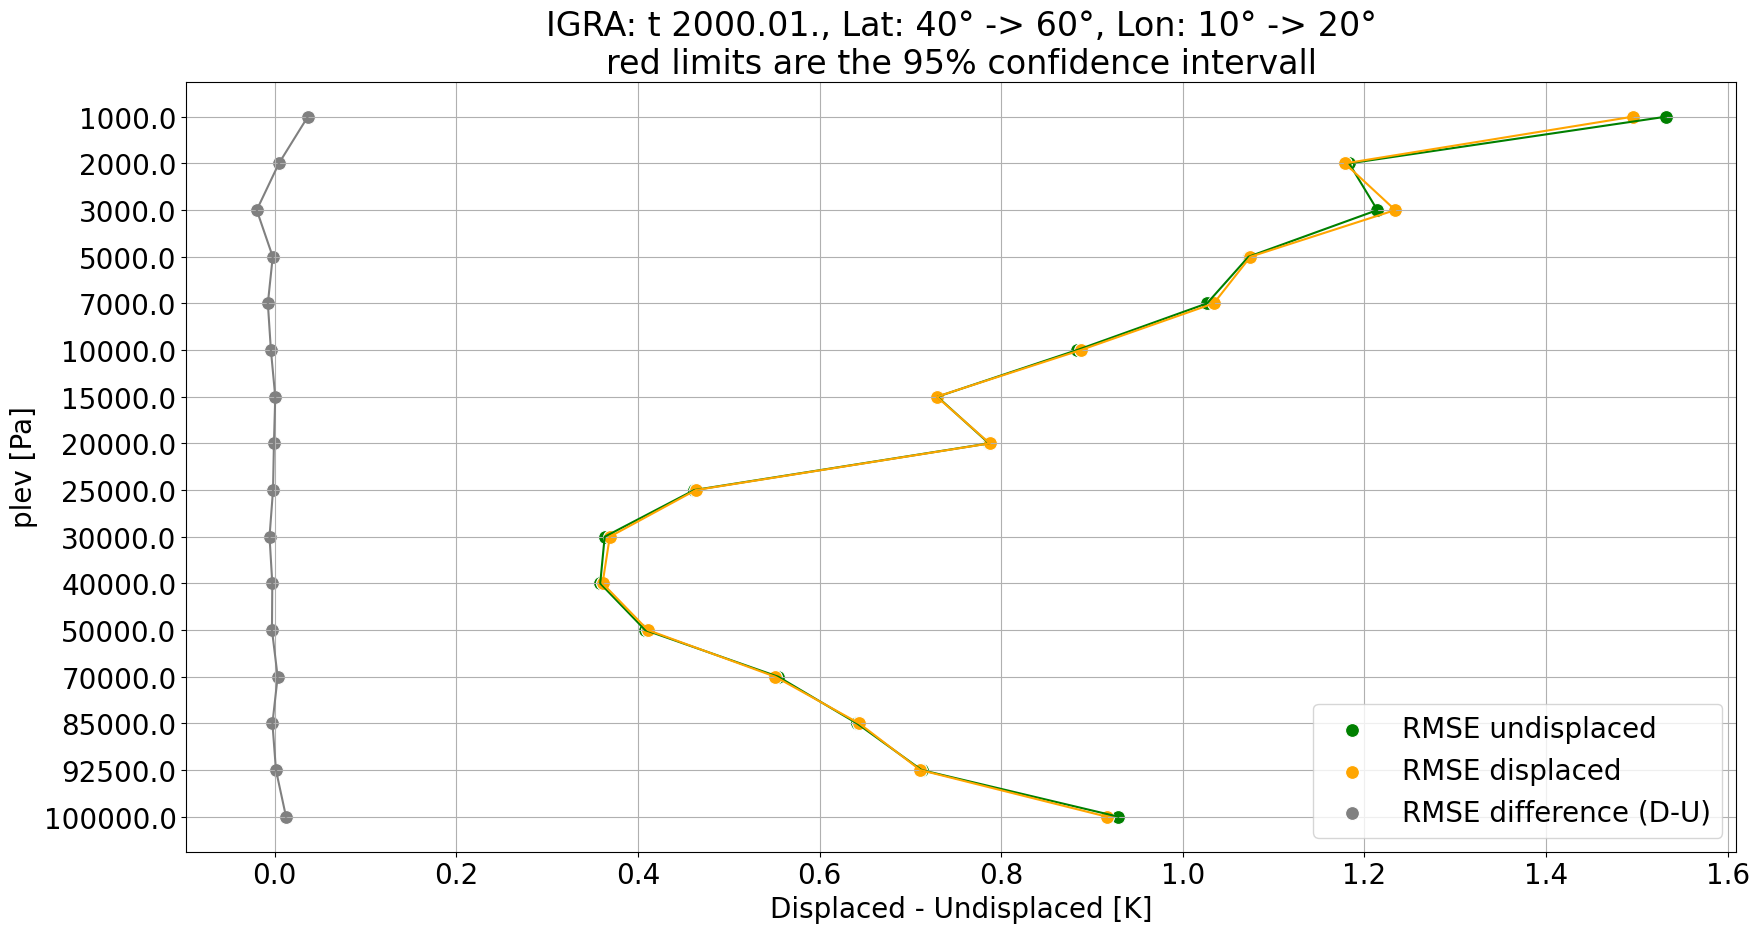

138.00523447990417


In [117]:
ts = time.time()
calc_month('2000', '01', '40', '60', '10', '20', 't', interp=True)
print(time.time() -ts)

2023-07-27 14:38:15,826 INFO Welcome to the CDS
2023-07-27 14:38:15,827 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-27 14:38:15,925 INFO Request is completed
2023-07-27 14:38:15,926 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve-1690460180.1704035-31146-1-56583c67-0d64-4a3d-aea8-28a08eae1b3a.zip to download.csv-lev.zip (776K)
2023-07-27 14:38:16,200 INFO Download rate 2.8M/s                     


./tmp/IGRA_20000101_20000131_subset_cdm-lev_v1.csv


2023-07-27 14:40:16,820 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:40:16,822 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:40:16,841 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:40:16,842 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:40:16,851 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

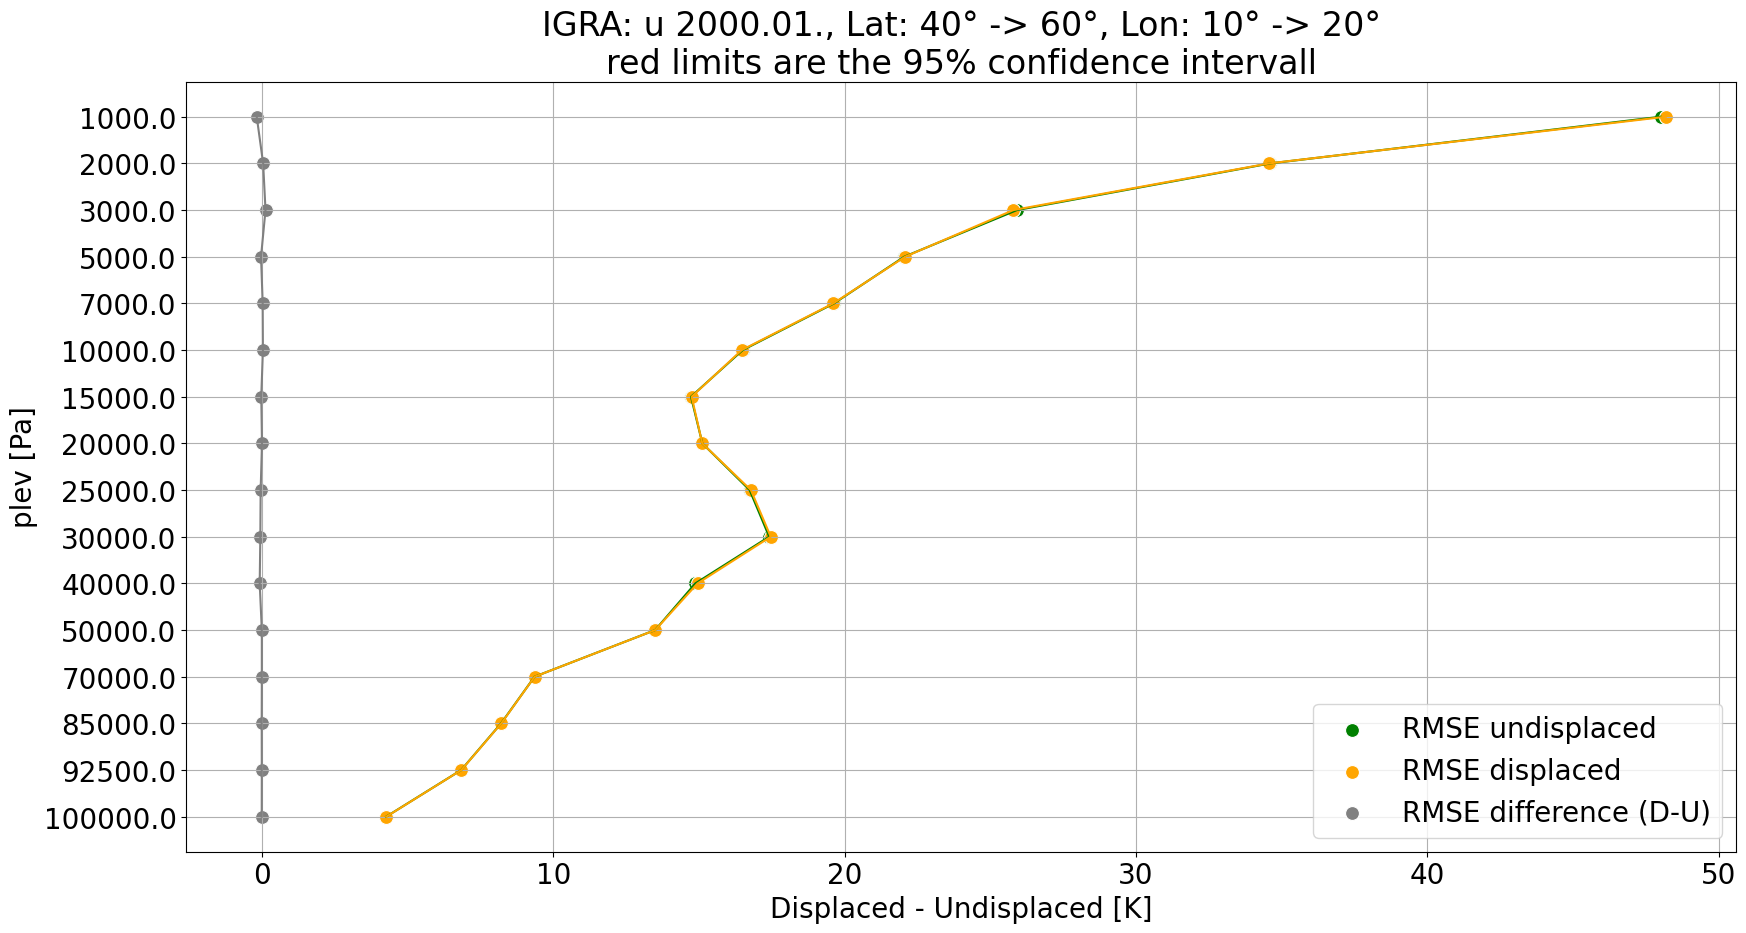

121.40999722480774


In [118]:
ts = time.time()
calc_month('2000', '01', '40', '60', '10', '20', 'u', interp=True)
print(time.time() -ts)

2023-07-27 14:40:17,216 INFO Welcome to the CDS
2023-07-27 14:40:17,217 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-27 14:40:17,301 INFO Request is completed
2023-07-27 14:40:17,301 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve-1690460180.1704035-31146-1-56583c67-0d64-4a3d-aea8-28a08eae1b3a.zip to download.csv-lev.zip (776K)
2023-07-27 14:40:17,554 INFO Download rate 3M/s                       


./tmp/IGRA_20000101_20000131_subset_cdm-lev_v1.csv


2023-07-27 14:42:21,770 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:42:21,772 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:42:21,791 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:42:21,792 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 14:42:21,800 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

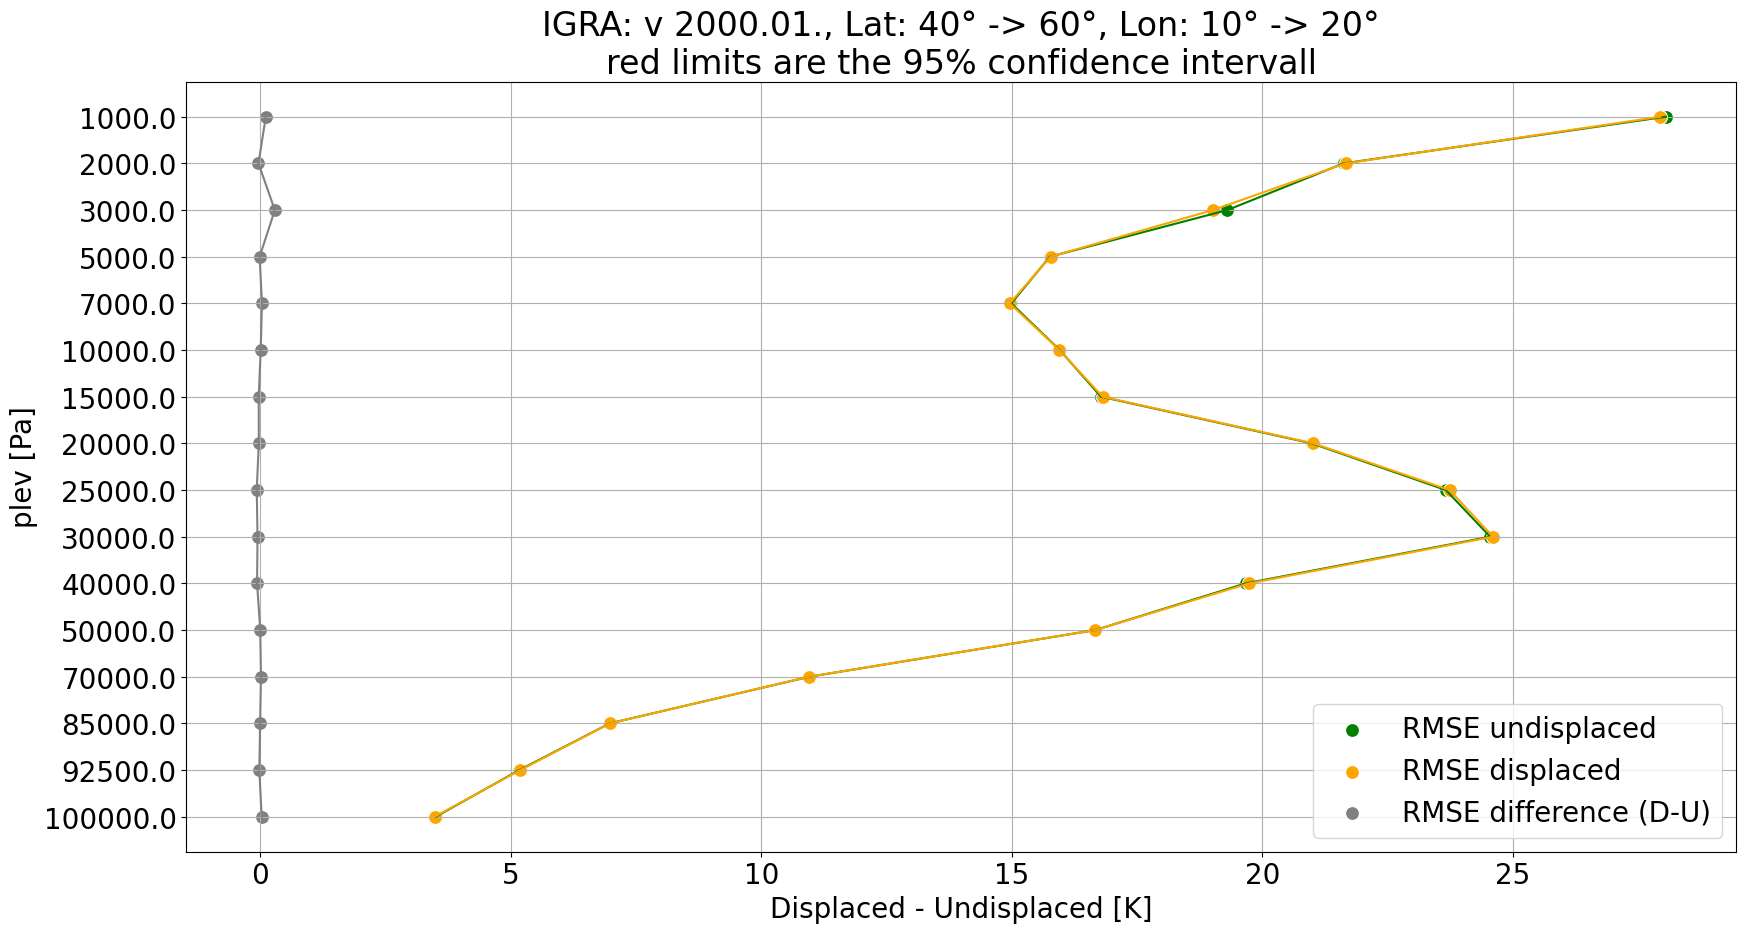

124.94603896141052


*** SIGTERM received at time=1690785846 on cpu 113 ***
PC: @     0x7f9349c9ff53  (unknown)  pthread_create@@GLIBC_2.34
    @     0x7f9349c54df0  (unknown)  (unknown)
    @         0x1273eb60  (unknown)  (unknown)
[2023-07-31 08:44:06,442 E 3976196 3977515] logging.cc:361: *** SIGTERM received at time=1690785846 on cpu 113 ***
[2023-07-31 08:44:06,442 E 3976196 3977515] logging.cc:361: PC: @     0x7f9349c9ff53  (unknown)  pthread_create@@GLIBC_2.34
[2023-07-31 08:44:06,444 E 3976196 3977515] logging.cc:361:     @     0x7f9349c54df0  (unknown)  (unknown)
[2023-07-31 08:44:06,446 E 3976196 3977515] logging.cc:361:     @         0x1273eb60  (unknown)  (unknown)


In [119]:
ts = time.time()
calc_month('2000', '01', '40', '60', '10', '20', 'v', interp=True)
print(time.time() -ts)

In [86]:
np.nanmean(df.northward_wind_component)

-11.259310699032273

In [85]:
np.nanmean(df.eastward_wind_component)

10.214235384784764

In [81]:
files = '/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.200001.132.nc'
ds_fc = xr.load_dataset(files)

In [91]:
np.nanmean(ds_fc.sel({'latitude': slice(48.4 +3, 48.4 -3), 'longitude': slice(18.4 -3, 18.4 +3)}).v.values.flatten())

-11.088637

In [42]:
ds_time = ds_fc.sel({'time': '2000-01-01T09:00:00'}, method='nearest')

In [58]:
from scipy.interpolate import griddata

latitude = ds_time['latitude'].values
longitude = ds_time['longitude'].values
length_values = len(latitude) * len(longitude)

# create grid
x_grid, y_grid = np.meshgrid(latitude, longitude)
points = np.empty((length_values, 2))
points[:, 0] = x_grid.flatten()
points[:, 1] = y_grid.flatten()

# select a single timestep in which to interpolate the data
values = np.array(ds_time.t.values.flatten(order=0))

#your test locations
EXAMPLE_FFDI_LAT_XR_DA = range(5, 15) # extract these from you arrays
EXAMPLE_FFDI_LON_XR_DA = range(20, 30)
grid_x, grid_y = np.meshgrid(45.2, 21.6)

interpolated_values = griddata(points, values, (grid_x, grid_y), method='linear')

TypeError: order must be str, not int

In [59]:
np.shape(values)

(1042560,)

In [51]:
ds_time

<xarray.Dataset>
Dimensions:    (latitude: 181, level: 16, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    time       datetime64[ns] 2000-01-01T09:00:00
Data variables:
    t          (latitude, longitude, level) float32 192.4 188.3 ... 256.8 260.7

In [ ]:
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

In [45]:
ds_time.latitude

<xarray.DataArray 'latitude' (latitude: 181)>
array([ 90.,  89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,
        78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,  67.,
        66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,  56.,  55.,
        54.,  53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,  45.,  44.,  43.,
        42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,
        30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,
        18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,
         6.,   5.,   4.,   3.,   2.,   1.,   0.,  -1.,  -2.,  -3.,  -4.,  -5.,
        -6.,  -7.,  -8.,  -9., -10., -11., -12., -13., -14., -15., -16., -17.,
       -18., -19., -20., -21., -22., -23., -24., -25., -26., -27., -28., -29.,
       -30., -31., -32., -33., -34., -35., -36., -37., -38., -39., -40., -41.,
       -42., -43., -44., -45., -46., -47., -48., -49., -50., -51., -52., -53.,
       -54., -55., -56., -57., -58., -59., -60., -61., -62., -63., -64., -65.,
       -66., -67., -68., -69., -70., -71., -72., -73., -74., -75., -76., -77.,
       -78., -79., -80., -81., -82., -83., -84., -85., -86., -87., -88., -89.,
       -90.], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
    time      datetime64[ns] 2000-01-01T09:00:00
Attributes:
    units:      degrees_north
    long_name:  latitude

2023-07-27 09:27:50,863 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 09:27:50,864 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 09:27:50,889 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 09:27:50,890 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-27 09:27:50,913 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

NameError: name 'year' is not defined

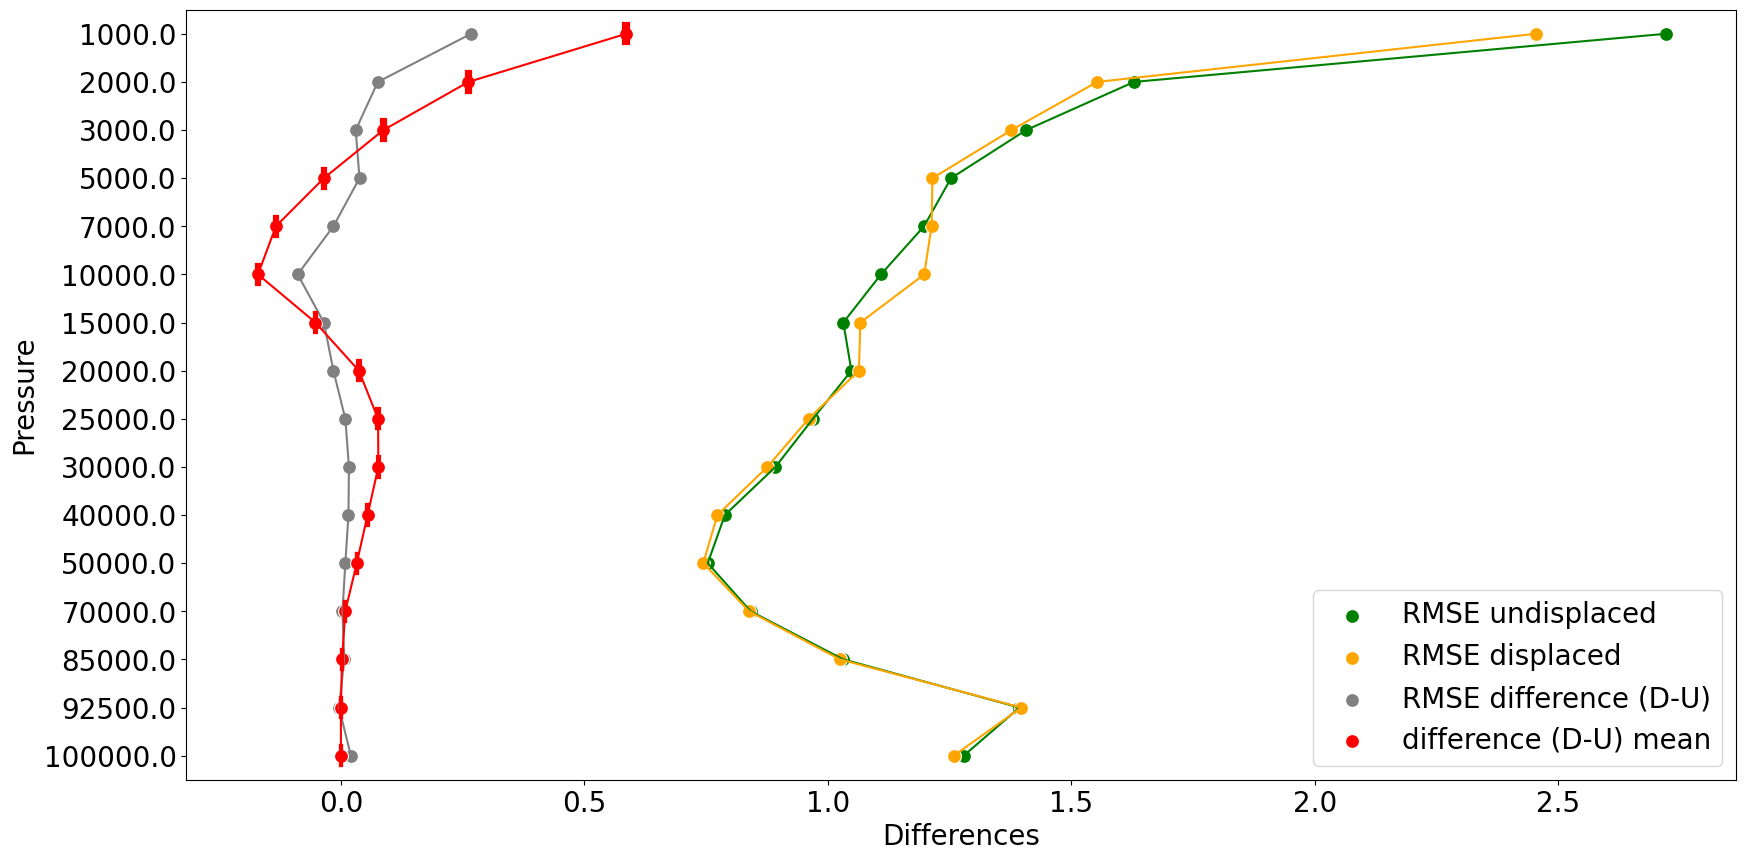

In [16]:
plot_only('1980_01_-90_90_-180_180_temperature.p')

In [ ]:
pickle.load()

2023-07-26 14:52:39,838 INFO Welcome to the CDS
2023-07-26 14:52:39,838 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-26 14:52:39,968 INFO Request is completed
2023-07-26 14:52:39,969 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1690367591.8344345-31162-1-97021bf2-2481-4058-9e4c-4e127f37cb5a.zip to download.csv-lev.zip (14.1M)
2023-07-26 14:52:40,406 INFO Download rate 32.2M/s                    


./tmp/IGRA_H_20000601_20000631_global_cdm-lev_v1.csv


2023-07-26 15:38:42,400 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 15:38:42,404 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 15:38:42,509 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 15:38:42,511 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 15:38:42,529 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

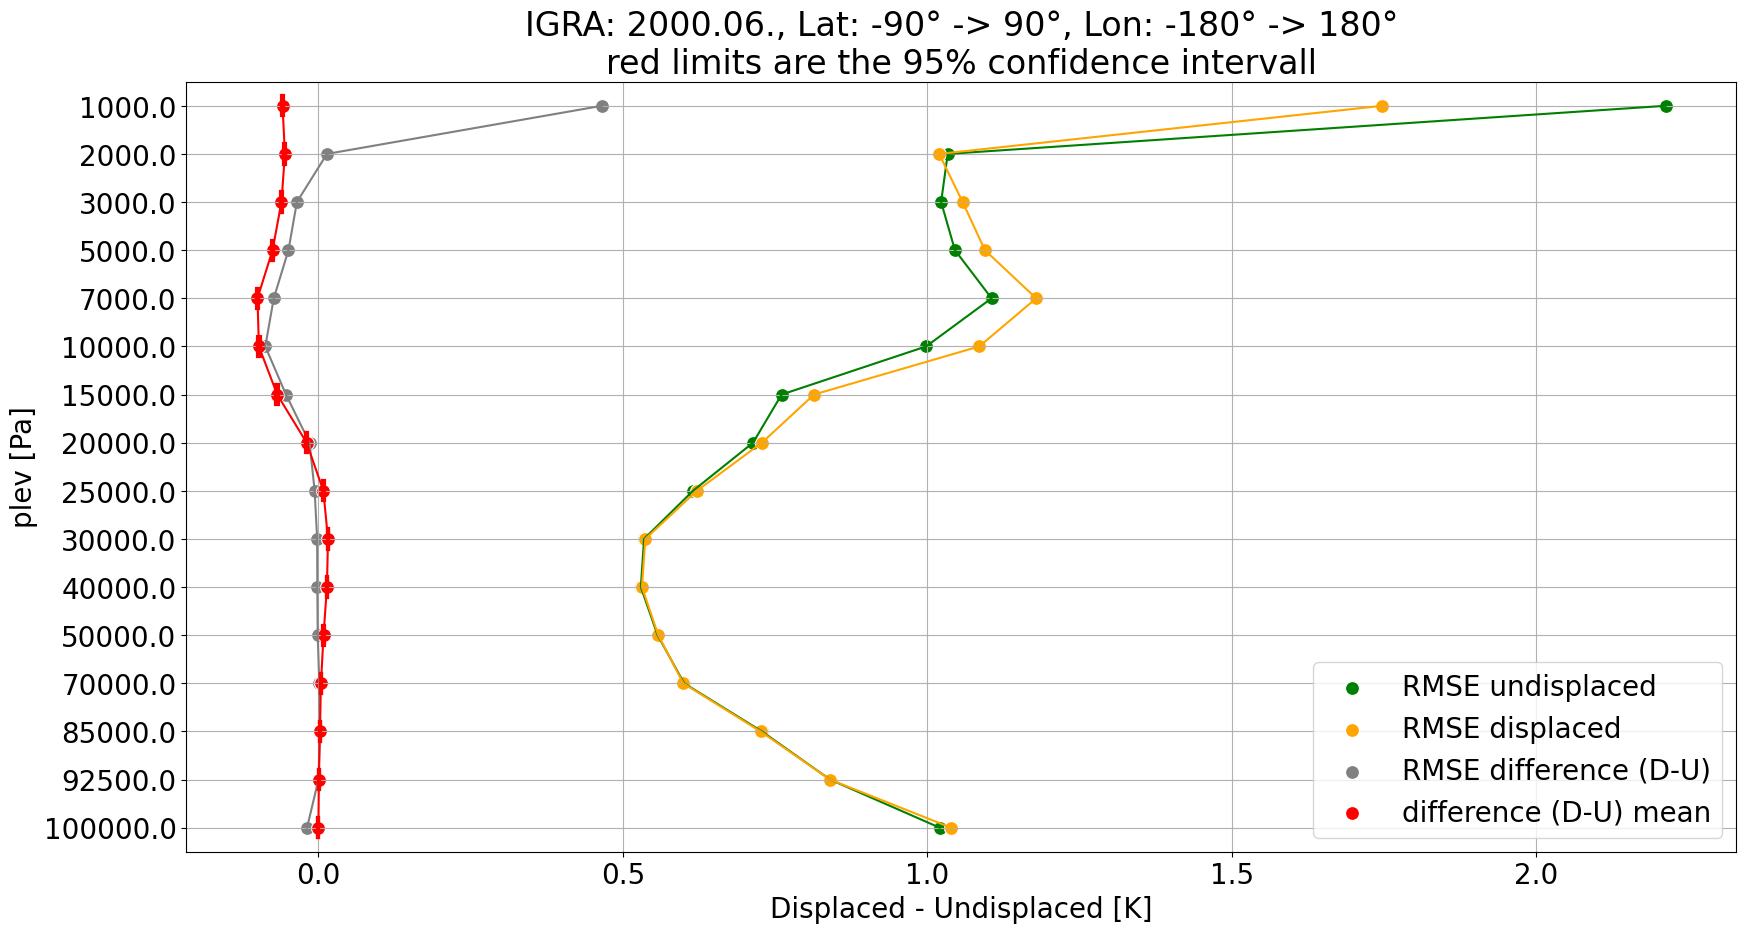

(defaultdict(list,
             {1000.0: [nan,
               -8.2706066662804,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               -3.3591685199233154,
               nan,
               nan,
               nan,
               -2.3896763806877743,
               nan,
               nan,
               nan,
               nan,
               -10.27784951873349,
               nan,
               nan,
               nan,
               nan,
               nan,
             

In [5]:
calc_month('2000', '06', '-90', '90', '-180', '180', interp=True)

2023-07-26 15:38:43,588 INFO Welcome to the CDS
2023-07-26 15:38:43,589 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-26 15:38:43,637 INFO Request is queued
2023-07-26 15:38:44,667 INFO Request is running
2023-07-26 15:38:56,984 INFO Request is completed
2023-07-26 15:38:56,985 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1690378730.5095534-31162-2-0855a154-258b-4243-b0b7-3920eb2f7da0.zip to download.csv-lev.zip (13.9M)
2023-07-26 15:38:57,492 INFO Download rate 27.4M/s                    


./tmp/IGRA_H_20000101_20000131_global_cdm-lev_v1.csv


2023-07-26 16:23:10,467 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:23:10,469 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:23:10,495 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:23:10,496 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:23:10,506 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

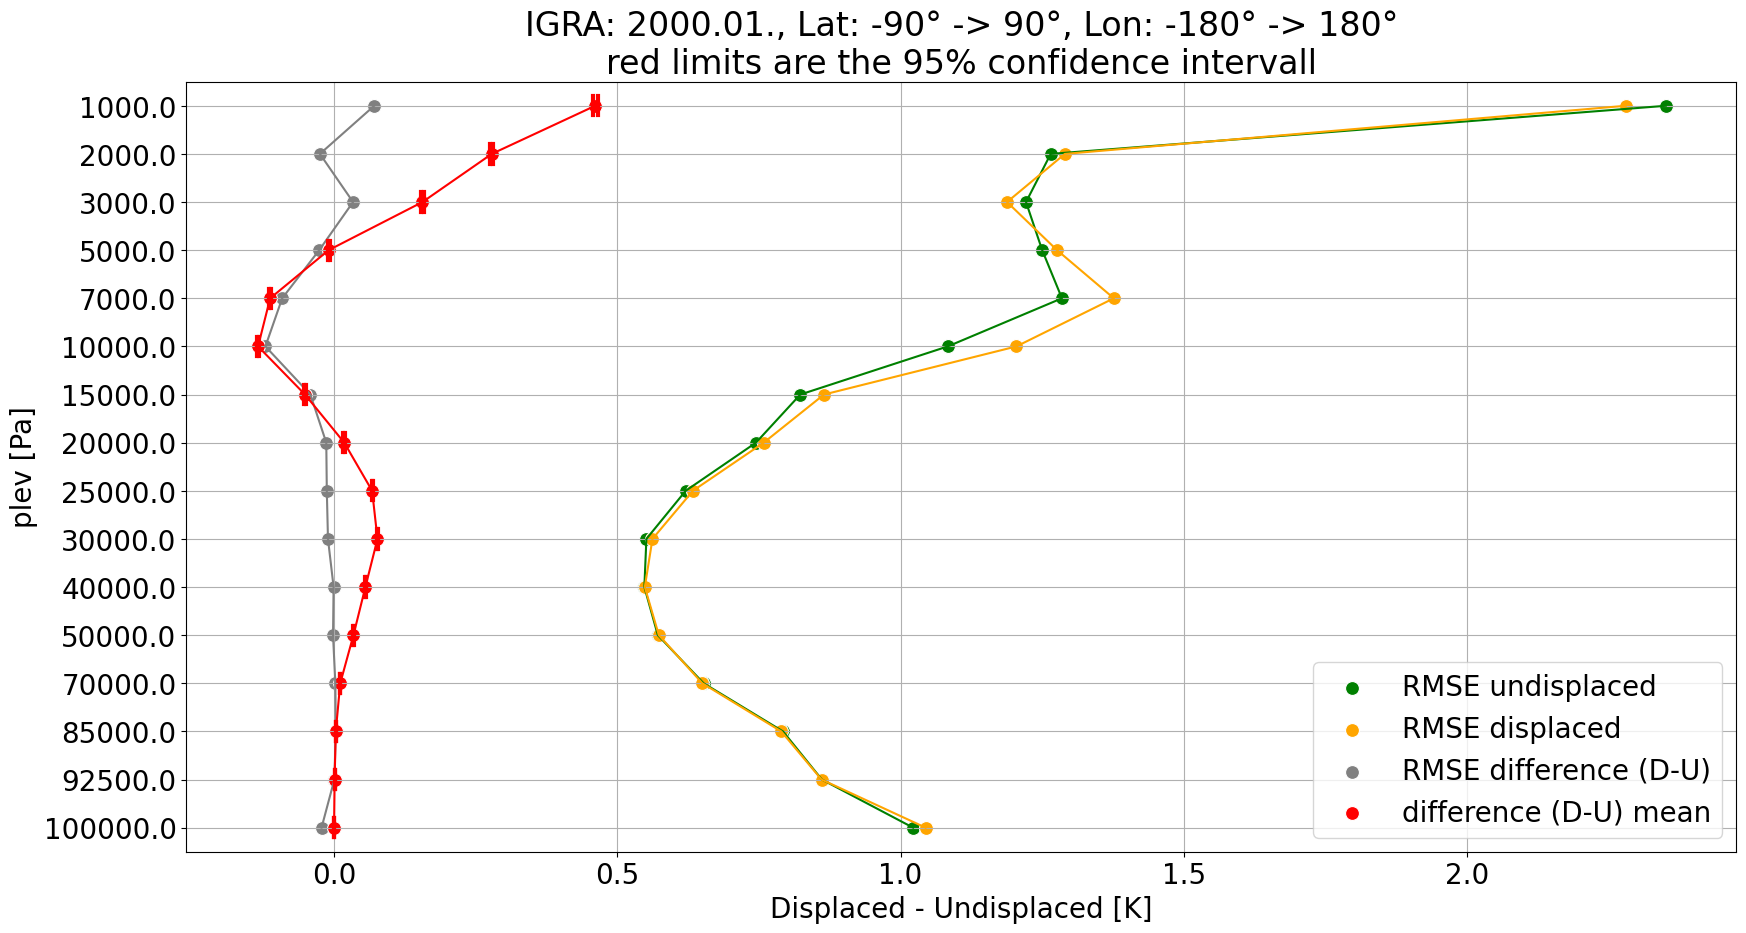

(defaultdict(list,
             {1000.0: [nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               -7.7883986833170695,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               na

In [6]:
calc_month('2000', '01', '-90', '90', '-180', '180', interp=True)

2023-07-26 16:23:11,268 INFO Welcome to the CDS
2023-07-26 16:23:11,269 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-26 16:23:11,308 INFO Request is queued
2023-07-26 16:23:12,341 INFO Request is running
2023-07-26 16:23:19,556 INFO Request is completed
2023-07-26 16:23:19,558 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1690381394.8462584-31201-2-a99e9166-79f8-476e-afca-a56216457d7a.zip to download.csv-lev.zip (7.2M)
2023-07-26 16:23:19,921 INFO Download rate 20M/s                      


./tmp/IGRA_H_19900101_19900131_global_cdm-lev_v1.csv


2023-07-26 16:54:57,045 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:54:57,047 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:54:57,072 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:54:57,073 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 16:54:57,083 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

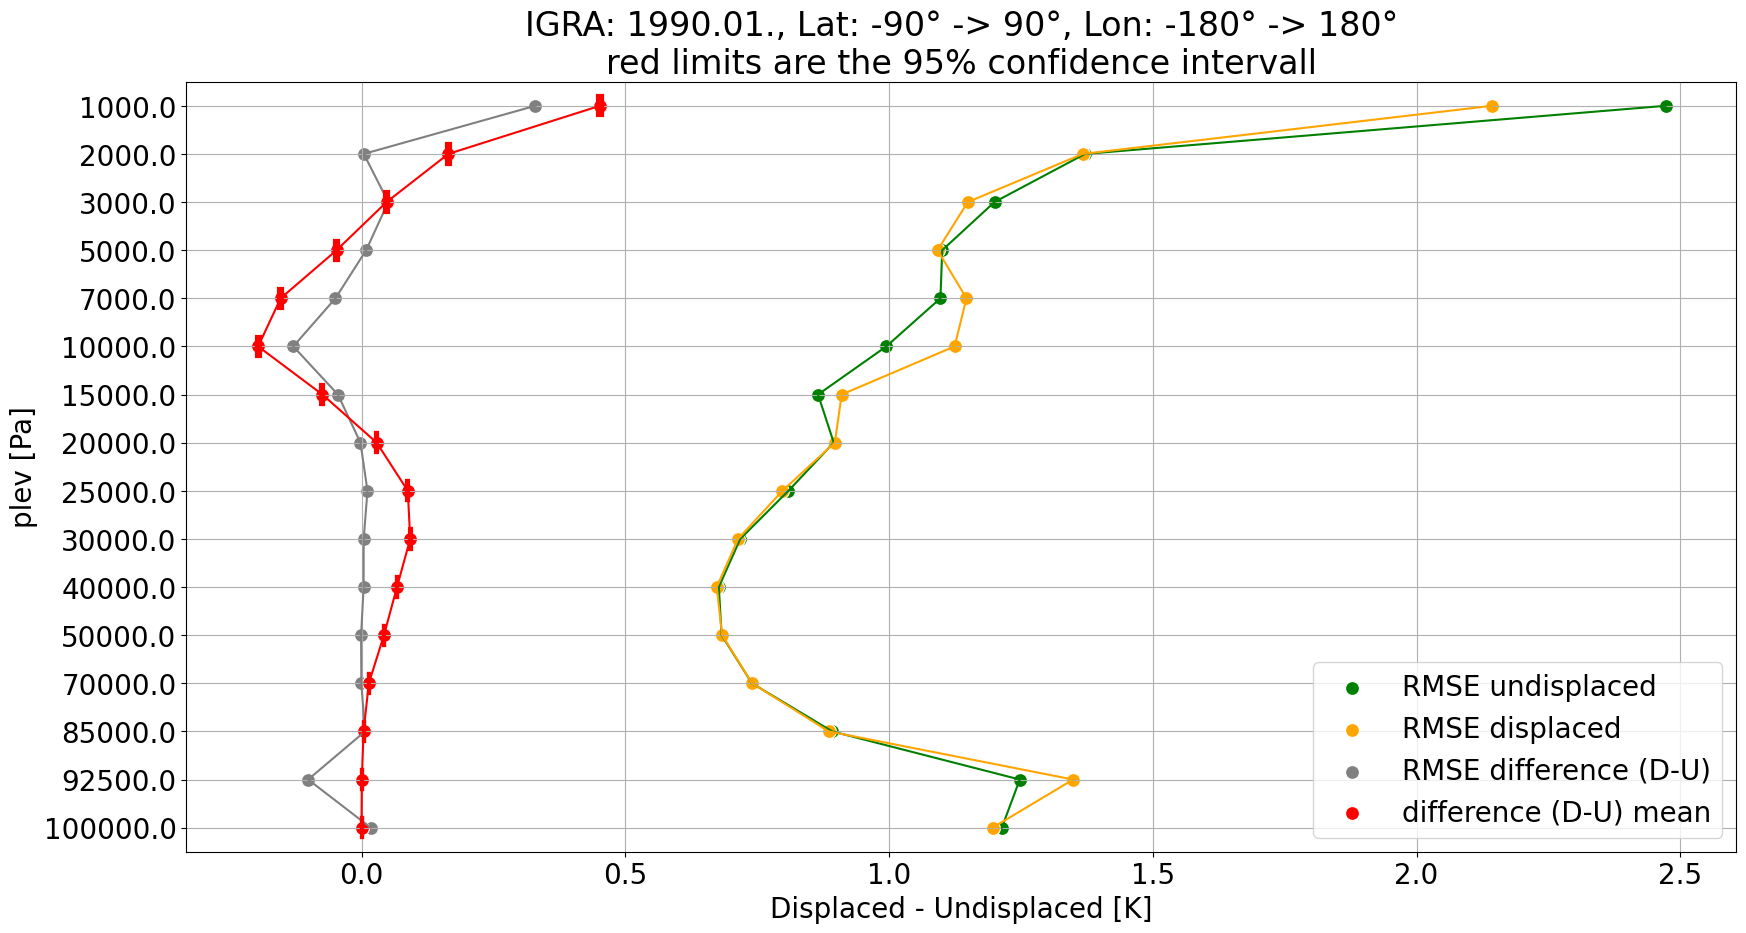

(defaultdict(list,
             {1000.0: [nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               0.753504033807161,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,

In [7]:
calc_month('1990', '01', '-90', '90', '-180', '180', interp=True)

2023-07-26 16:54:57,860 INFO Welcome to the CDS
2023-07-26 16:54:57,860 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-26 16:54:57,903 INFO Request is queued
2023-07-26 16:54:58,931 INFO Request is running
2023-07-26 16:55:06,146 INFO Request is completed
2023-07-26 16:55:06,148 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1690383301.3784366-31152-2-495d8a38-096b-4490-820c-181e4640cba1.zip to download.csv-lev.zip (6.6M)
2023-07-26 16:55:07,304 INFO Download rate 5.7M/s                     


./tmp/IGRA_H_19800101_19800131_global_cdm-lev_v1.csv


2023-07-26 17:30:03,907 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 17:30:03,910 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 17:30:03,951 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 17:30:03,954 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 17:30:03,965 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

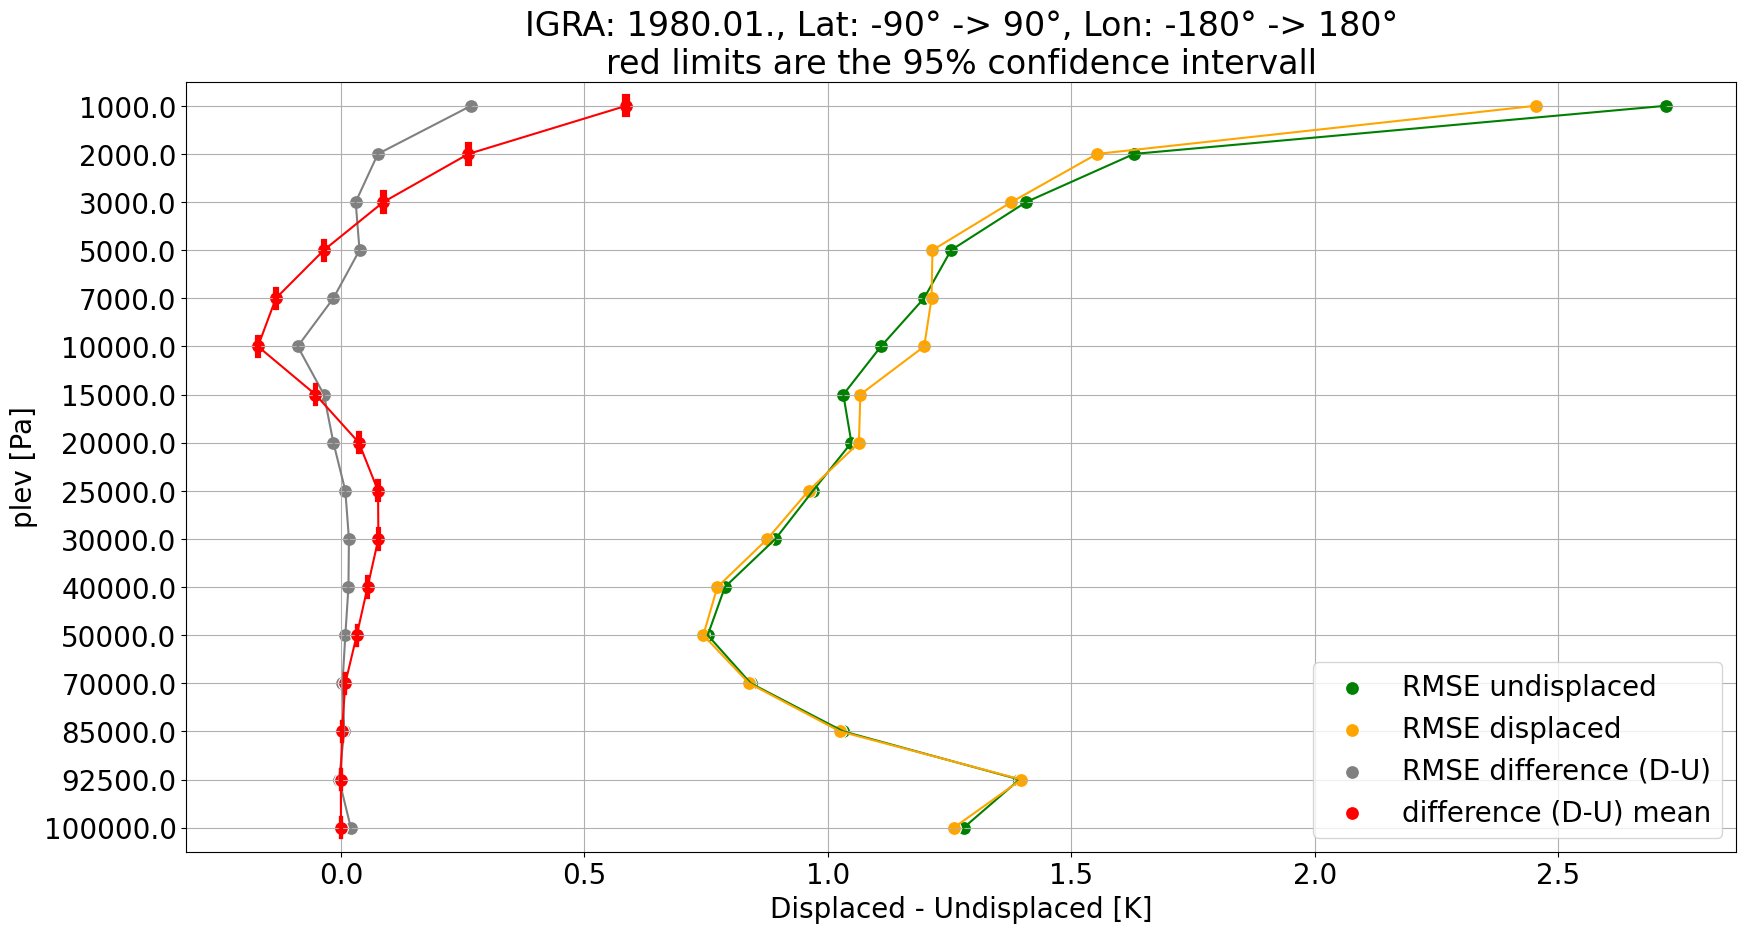

(defaultdict(list,
             {1000.0: [nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               -1.1416213704376048,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               nan,
               na

In [8]:
calc_month('1980', '01', '-90', '90', '-180', '180', interp=True)

2023-07-26 17:30:04,857 INFO Welcome to the CDS
2023-07-26 17:30:04,858 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-26 17:30:04,905 INFO Request is queued
2023-07-26 17:30:05,938 INFO Request is completed
2023-07-26 17:30:05,939 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1690385405.16315-31162-3-091fc78a-dd29-4783-a2d1-29bf1ef20c9d.zip to download.csv-lev.zip (652)
2023-07-26 17:30:06,297 INFO Download rate 1.8K/s                     


./tmp/IGRA_H_19700101_19700131_global_cdm-lev_v1.csv


2023-07-26 17:30:26,627 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 17:30:26,632 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 17:30:26,634 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


KeyError: 'x'

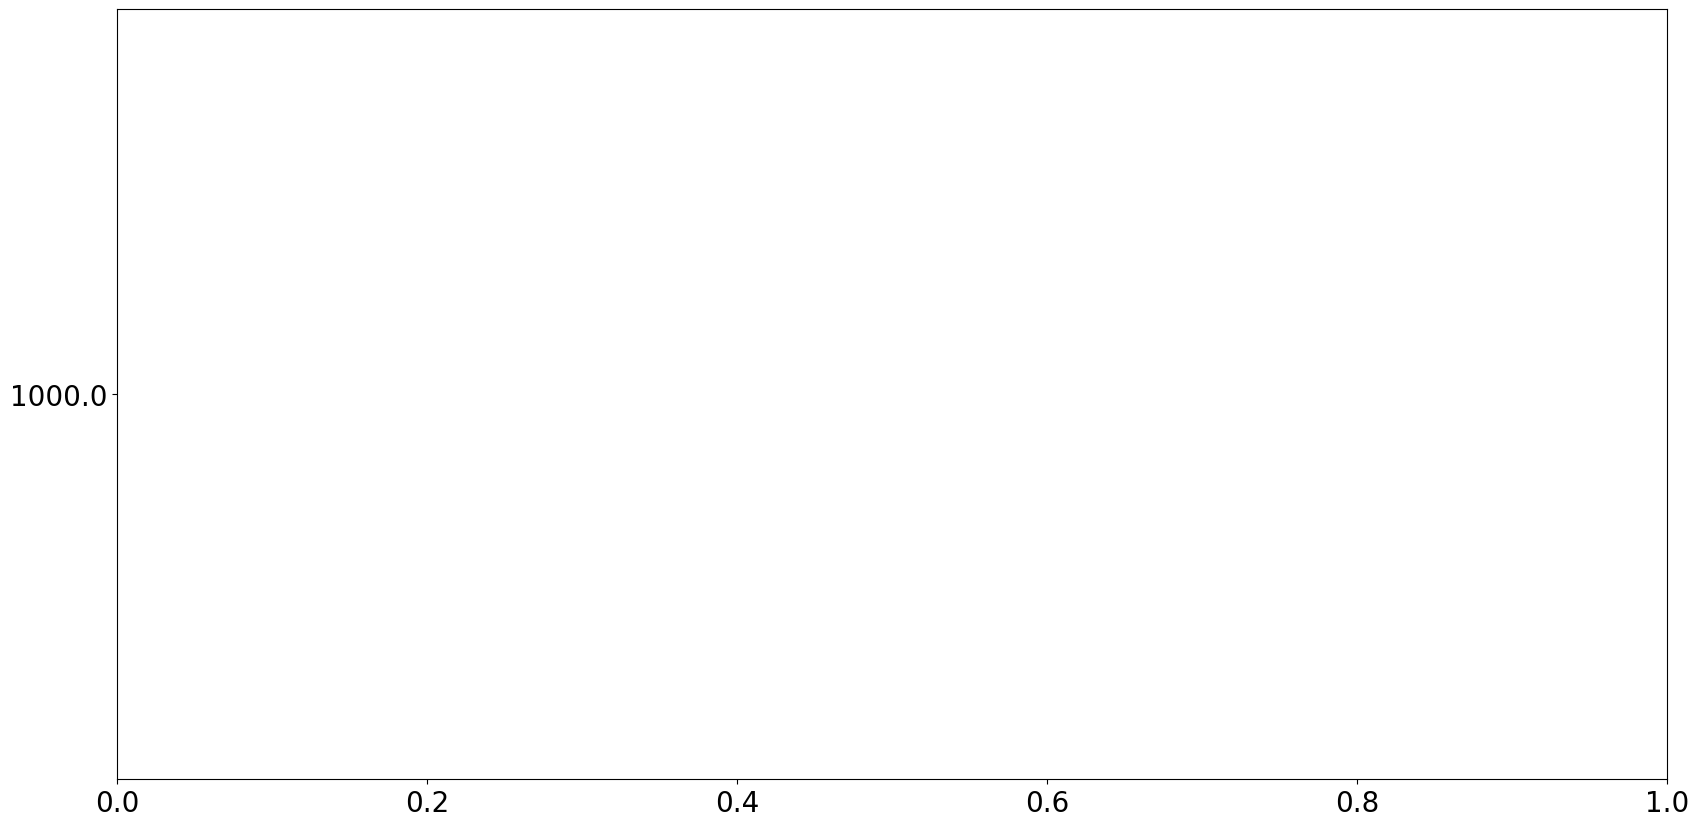

In [9]:
calc_month('1970', '01', '-90', '90', '-180', '180', interp=True)

In [3]:
import cdsapi

c = cdsapi.Client()

r = c.retrieve(
    'insitu-observations-igra-baseline-network',
    {
        'archive_type': 'harmonized_global_radiosonde_archive',
        'format': 'csv-lev.zip',
        'year': '2000',
        'month': '01',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'area': [
            60, 10, 40,
            20,
        ],
        'variable': [
            'air_temperature', 'eastward_wind_component', 'northward_wind_component',
            'relative_humidity',
        ],
    },
    'download.csv-lev.zip')

2023-07-24 11:40:40,593 INFO Welcome to the CDS
2023-07-24 11:40:40,594 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-24 11:40:40,697 INFO Request is completed
2023-07-24 11:40:40,698 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve-1689759763.2069223-31328-1-d402cc8a-aac5-40d6-a0ba-2817bded26f5.zip to download.csv-lev.zip (548.2K)
2023-07-24 11:40:41,012 INFO Download rate 1.7M/s                     


In [4]:
tempdir = "./tmp/"
delete_dl = True
with zipfile.ZipFile("download.csv-lev.zip", "r") as zip_ref:
    try:
        os.mkdir(tempdir)
    except:
        pass

    zip_ref.extractall(tempdir)

for i in glob.glob(tempdir + "*"):
    print(i)
    df = pd.read_csv(i, header=16)

if delete_dl:
    shutil.rmtree(tempdir)

./tmp/IGRA_H_20000101_20000131_subset_cdm-lev_v1.csv


In [5]:
df

station_name  radiosonde_code  \
0      AUM00011240             61.0   
1      AUM00011240             61.0   
2      AUM00011240             61.0   
3      AUM00011240             61.0   
4      AUM00011240             61.0   
...            ...              ...   
44295  GMM00010184             62.0   
44296  GMM00010184             62.0   
44297  GMM00010184             62.0   
44298  GMM00010771             62.0   
44299  GMM00010771             62.0   

                                            sensor_model  \
0      Vaisala RS80/Loran/Digicora I, II or Marwin (F...   
1      Vaisala RS80/Loran/Digicora I, II or Marwin (F...   
2      Vaisala RS80/Loran/Digicora I, II or Marwin (F...   
3      Vaisala RS80/Loran/Digicora I, II or Marwin (F...   
4      Vaisala RS80/Loran/Digicora I, II or Marwin (F...   
...                                                  ...   
44295                      Vaisala RS80/PCCora (Finland)   
44296                      Vaisala RS80/PCCora (Finland)   
44297                      Vaisala RS80/PCCora (Finland)   
44298                      Vaisala RS80/PCCora (Finland)   
44299                      Vaisala RS80/PCCora (Finland)   

             report_timestamp             actual_time  report_id  longitude  \
0      2000-01-01 00:00:00+00  2000-01-01 03:44:00+00      82731    15.4392   
1      2000-01-01 00:00:00+00  2000-01-01 03:44:00+00      82731    15.4392   
2      2000-01-01 00:00:00+00  2000-01-01 03:44:00+00      82731    15.4392   
3      2000-01-01 00:00:00+00  2000-01-01 03:44:00+00      82731    15.4392   
4      2000-01-01 00:00:00+00  2000-01-01 03:44:00+00      82731    15.4392   
...                       ...                     ...        ...        ...   
44295  2000-01-31 12:00:00+00  2000-01-31 10:52:00+00   11949459    13.4075   
44296  2000-01-31 12:00:00+00  2000-01-31 10:52:00+00   11949459    13.4075   
44297  2000-01-31 12:00:00+00  2000-01-31 10:52:00+00   11949459    13.4075   
44298  2000-01-09 00:00:00+00  2000-01-08 22:47:00+00    5848365    11.9022   
44299  2000-01-09 00:00:00+00  2000-01-08 22:47:00+00    5848365    11.9022   

       latitude  height_of_station_above_sea_level  air_pressure  \
0       46.9931                              340.0         10000   
1       46.9931                              340.0         15000   
2       46.9931                              340.0         20000   
3       46.9931                              340.0         22800   
4       46.9931                              340.0         25000   
...         ...                                ...           ...   
44295   54.0978                                2.0         92500   
44296   54.0978                                2.0         97400   
44297   54.0978                                2.0        100000   
44298   49.4283                              417.0         96600   
44299   49.4283                              417.0         97400   

       air_temperature  relative_humidity  eastward_wind_component  \
0               215.65                NaN                     6.06   
1               216.85                NaN                    16.74   
2               216.05                NaN                    28.98   
3               216.45               1.93                    45.11   
4               219.05               2.14                    51.68   
...                ...                ...                      ...   
44295           275.66              80.40                     7.14   
44296           279.56              62.01                      NaN   
44297           281.50              65.21                     3.48   
44298           272.85              95.02                      NaN   
44299           273.75              92.32                    -1.29   

       northward_wind_component  
0                         -3.50  
1                          2.95  
2                          7.76  
3                         16.42  
4                         18.81  
...  

In [6]:
lat_disp, lon_disp, sec_disp = np.array([np.nan]*len(df)),np.array([np.nan]*len(df)),np.array([np.nan]*len(df))
for station in df.station_name.drop_duplicates():
    df_i = df[df.station_name == station]
    for rid in df_i.report_id.drop_duplicates():
        df_j = df_i[df_i.report_id == rid]
        df_j_cleanded = df_j.sort_values(by='air_pressure', ascending=False).dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component'])
        if len(df_j_cleanded) > 3:
            
            idx =  df_j_cleanded.index.values
            lat_i, lon_i, sec_i = trj.trajectory(df_j_cleanded.latitude.iloc[0], 
                                                 df_j_cleanded.longitude.iloc[0], 
                                                 df_j_cleanded.eastward_wind_component.values, 
                                                 df_j_cleanded.northward_wind_component.values, 
                                                 df_j_cleanded.air_pressure.values, 
                                                 df_j_cleanded.air_temperature.values
                                                )
            lat_disp[idx] = lat_i
            lon_disp[idx] = lon_i
            sec_disp[idx] = sec_i
    
df['latitude_displacement'] = lat_disp
df['longitude_displacement'] = lon_disp
df['time_displacement'] = sec_disp

In [7]:
df[df.report_id == df.report_id.drop_duplicates().values[3]]

station_name  radiosonde_code  \
105  DAM00006181             71.0   
106  DAM00006181             71.0   
107  DAM00006181             71.0   
108  DAM00006181             71.0   
109  DAM00006181             71.0   
110  DAM00006181             71.0   
111  DAM00006181             71.0   
112  DAM00006181             71.0   
113  DAM00006181             71.0   
114  DAM00006181             71.0   
115  DAM00006181             71.0   
116  DAM00006181             71.0   
117  DAM00006181             71.0   
118  DAM00006181             71.0   
119  DAM00006181             71.0   
120  DAM00006181             71.0   
121  DAM00006181             71.0   
122  DAM00006181             71.0   
123  DAM00006181             71.0   
124  DAM00006181             71.0   
125  DAM00006181             71.0   
126  DAM00006181             71.0   
127  DAM00006181             71.0   
128  DAM00006181             71.0   
129  DAM00006181             71.0   
130  DAM00006181             71.0   
131  DAM00006181             71.0   
132  DAM00006181             71.0   
133  DAM00006181             71.0   
134  DAM00006181             71.0   
135  DAM00006181             71.0   
136  DAM00006181             71.0   
137  DAM00006181             71.0   
138  DAM00006181             71.0   
139  DAM00006181             71.0   
140  DAM00006181             71.0   
141  DAM00006181             71.0   
142  DAM00006181             71.0   
143  DAM00006181             71.0   
144  DAM00006181             71.0   
145  DAM00006181             71.0   
146  DAM00006181             71.0   
147  DAM00006181             71.0   
148  DAM00006181             71.0   
149  DAM00006181             71.0   
150  DAM00006181             71.0   
151  DAM00006181             71.0   
152  DAM00006181             71.0   
153  DAM00006181             71.0   
154  DAM00006181             71.0   
155  DAM00006181             71.0   
156  DAM00006181             71.0   
157  DAM00006181             71.0   
158  DAM00006181             71.0   
159  DAM00006181             71.0   

                                          sensor_model  \
105  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
106  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
107  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
108  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
109  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
110  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
111  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
112  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
113  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
114  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
115  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
116  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
117  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
118  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
119  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
120  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
121  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
122  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
123  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
124  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
125  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
126  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
127  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
128  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
129  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
130  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
131  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
132  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
133  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
134  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
135  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
136  Vaisala RS90/Loran/Digicora I, II or Marwin (F...   
137  Vaisala RS90

In [8]:
df_interp = df[df.report_id == df.report_id.drop_duplicates().values[3]]
df_interp['latitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].latitude_displacement)
df_interp['longitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].longitude_displacement)
df_interp['time_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].time_displacement)
df_interp[['air_pressure', 'latitude_displacement', 'latitude_displacement_interpolated', 'longitude_displacement', 'longitude_displacement_interpolated', 'time_displacement', 'time_displacement_interpolated']]

air_pressure  latitude_displacement  latitude_displacement_interpolated  \
105          1000              -0.862467                           -0.862467   
106          1100                    NaN                           -0.830505   
107          1430                    NaN                           -0.725030   
108          1870                    NaN                           -0.584397   
109          2000              -0.542846                           -0.542846   
110          3000              -0.408509                           -0.408509   
111          3710                    NaN                           -0.362631   
112          3930                    NaN                           -0.348416   
113          4910                    NaN                           -0.285092   
114          5000              -0.279277                           -0.279277   
115          7000              -0.220041                           -0.220041   
116          7460                    NaN                           -0.212085   
117          8520              -0.193754                           -0.193754   
118         10000              -0.176535                           -0.176535   
119         10400                    NaN                           -0.174438   
120         12700                    NaN                           -0.162382   
121         14600                    NaN                           -0.152422   
122         15000              -0.150325                           -0.150325   
123         15300                    NaN                           -0.149213   
124         16400                    NaN                           -0.145135   
125         17400              -0.141428                           -0.141428   
126         20000              -0.128564                           -0.128564   
127         22400                    NaN                           -0.117584   
128         25000              -0.105688                           -0.105688   
129         25300                    NaN                           -0.104828   
130         29500                    NaN                           -0.092792   
131         30000              -0.091359                           -0.091359   
132         31000                    NaN                           -0.089266   
133         35100                    NaN                           -0.080687   
134         36700                    NaN                           -0.077338   
135         39500                    NaN                           -0.071479   
136         39800                    NaN                           -0.070851   
137         40000              -0.070433                           -0.070433   
138         40500                    NaN                           -0.069704   
139         42300                    NaN                           -0.067079   
140         45800                    NaN                           -0.061974   
141         50000              -0.055849                           -0.055849   
142         54000              -0.051324                           -0.051324   
143         57700                    NaN                           -0.047016   
144         60400                    NaN                           -0.043872   
145         63000                    NaN                           -0.040845   
146         63400                    NaN                           -0.040380   
147         66300                    NaN                           -0.037003   
148         68300                    NaN                           -0.034674   
149         70000              -0.032695                           -0.032695   
150         70300                    NaN                           -0.032327   
151         72100                    NaN                           -0.030119   
152         75200                    NaN                           -0.026317   
153         83400                    NaN                           -0.016260   
154  

In [72]:
# year, mon = 2000, 1
# files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(mon).zfill(2)+'*.132.nc')[0]
# ds_fc = xr.load_dataset(files)

# look_at = df_interp[df_interp.report_timestamp.dt.month == mon]
# look_at = np.unique(look_at.report_timestamp)
# for i in look_at[:]:
#     var_list = []
#     undis_list = []
#     cuon_list = []
#     cuon_press = []
    
#     out_dict = {}
#     ds_fc_time = ds_fc.sel(time=i, method='nearest')
#     station_lat = df_interp.latitude.iloc[0]
#     station_lon = df_interp.longitude.iloc[0]
#     lon = station_lon
#     if lon < 0:
#         lon = 360.+lon
#     ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
#     undis_list = np.array(ds_now.v)
    
#     for j in np.array(ds_fc_time.level): #10,20,...,1000
#         step = find_nearest(df_interp.air_pressure.values, j*100)
#         input_data_step = df_interp[df_interp.air_pressure == step]
#         station_lat = df_interp.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
#         station_lon = df_interp.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
#         lon = station_lon
#         if lon < 0:
#             lon = 360.+lon

        
#         ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
#         var = ds_now.v.sel(level = j)
#         var_list.append(float(var))
#         cv = df_interp[np.logical_and(df_interp.report_timestamp == i,  df_interp.air_pressure == step)].air_temperature.values
#         cuon_list.append((np.nan if len(cv) == 0 else float(cv[0])))
#         cuon_press.append(step)
        
#     out_dict['era5_displaced'] = drop_dims(var_list)
#     out_dict['era5'] = drop_dims(undis_list)
#     out_dict['igra'] = drop_dims(cuon_list)
    
#     out_dict['pressure'] = drop_dims(ds_fc_time.level) * 100.
#     out_dict['cuon_pressure']= drop_dims(cuon_press)
#     out_df = pd.DataFrame.from_dict(out_dict)
#     display(out_df.mean())

In [37]:
mean_displaced = []
mean_undisplaced = []
mean_displaced_dict = defaultdict(list)
mean_undisplaced_dict = defaultdict(list)


year, mon = 2000, 1
files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(mon).zfill(2)+'*.132.nc')[0]
ds_fc = xr.load_dataset(files)

    
for nr in range(len(df.report_id.drop_duplicates())):
    df_interp = df[df.report_id == df.report_id.drop_duplicates().values[nr]]
    if len(df_interp.dropna(subset=['air_temperature', 'eastward_wind_component', 'northward_wind_component'])) < 5:
        continue
    df_interp['latitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.latitude_displacement)].latitude_displacement)
    df_interp['longitude_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].air_pressure, df_interp[np.isfinite(df_interp.longitude_displacement)].longitude_displacement)
    df_interp['time_displacement_interpolated'] = np.interp(df_interp.air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].air_pressure, df_interp[np.isfinite(df_interp.time_displacement)].time_displacement)
    df_interp[['air_pressure', 'latitude_displacement', 'latitude_displacement_interpolated', 'longitude_displacement', 'longitude_displacement_interpolated', 'time_displacement', 'time_displacement_interpolated']]

    df_interp.report_timestamp = pd.to_datetime(df_interp.report_timestamp).dt.tz_localize(None)


    look_at = df_interp[df_interp.report_timestamp.dt.month == mon]
    look_at = np.unique(look_at.report_timestamp)
    for i in look_at[:]:
        var_list = []
        undis_list = []
        cuon_list = []
        cuon_press = []

        out_dict = {}
        ds_fc_time = ds_fc.sel(time=i, method='nearest')
        station_lat = df_interp.latitude.iloc[0]
        station_lon = df_interp.longitude.iloc[0]
        lon = station_lon
        if lon < 0:
            lon = 360.+lon
        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
        undis_list = np.array(ds_now.v)

        for j in np.array(ds_fc_time.level): #10,20,...,1000
            step = find_nearest(df_interp.air_pressure.values, j*100)
            input_data_step = df_interp[df_interp.air_pressure == step]
            station_lat = df_interp.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
            station_lon = df_interp.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
            lon = station_lon
            if lon < 0:
                lon = 360.+lon


            ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
            var = ds_now.v.sel(level = j)
            var_list.append(float(var))
            cv = df_interp[np.logical_and(df_interp.report_timestamp == i,  df_interp.air_pressure == step)].air_temperature.values
            cuon_list.append((np.nan if len(cv) == 0 else float(cv[0])))
            cuon_press.append(step)

        out_dict['era5_displaced'] = drop_dims(var_list)
        out_dict['era5'] = drop_dims(undis_list)
        out_dict['igra'] = drop_dims(cuon_list)

        out_dict['pressure'] = drop_dims(ds_fc_time.level) * 100.
        out_dict['cuon_pressure']= drop_dims(cuon_press)
        out_df = pd.DataFrame.from_dict(out_dict)
        # display(out_df.mean())
        mean_displaced.append(out_df.era5_displaced.mean())
        mean_undisplaced.append(out_df.era5.mean())
        for plev in [  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,  92500., 100000.]:
            sel_df =  out_df[out_df.pressure == plev]
            mean_displaced_dict[plev].append(sel_df.era5_displaced.values)
            mean_undisplaced_dict[plev].append(sel_df.era5.values)
            

era5_displaced      -16.257759
era5                -16.247174
igra                231.700000
pressure          34718.750000
cuon_pressure     36625.000000
dtype: float64

era5_displaced      -10.182290
era5                -13.844158
igra                232.382500
pressure          34718.750000
cuon_pressure     38587.500000
dtype: float64

era5_displaced      -16.709609
era5                -12.854462
igra                229.562500
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced       -8.789574
era5                 -8.138552
igra                228.118750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.538467
era5                -16.382120
igra                227.650625
pressure          34718.750000
cuon_pressure     34770.625000
dtype: float64

era5_displaced      -11.167924
era5                -11.828573
igra                232.592500
pressure          34718.750000
cuon_pressure     34759.375000
dtype: float64

era5_displaced      -13.779676
era5                -14.412079
igra                230.212500
pressure          34718.750000
cuon_pressure     34773.125000
dtype: float64

era5_displaced      -17.035052
era5                -16.536022
igra                228.123750
pressure          34718.750000
cuon_pressure     34721.875000
dtype: float64

era5_displaced       -0.234854
era5                 -0.525340
igra                232.574375
pressure          34718.750000
cuon_pressure     34750.000000
dtype: float64

era5_displaced      -15.658250
era5                -15.573589
igra                231.097500
pressure          34718.750000
cuon_pressure     34726.250000
dtype: float64

era5_displaced      -16.712379
era5                -16.880999
igra                229.546875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -13.829509
era5                -13.255232
igra                230.173750
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced      -15.666832
era5                -15.306302
igra                229.018125
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced      -11.669688
era5                -11.393656
igra                229.563750
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced      -10.294930
era5                -10.735954
igra                229.936875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.447362
era5                -13.677414
igra                228.906875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.764647
era5                -10.934392
igra                228.619375
pressure          34718.750000
cuon_pressure     34734.375000
dtype: float64

era5_displaced      -12.352452
era5                -12.093754
igra                230.023750
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced       -7.620722
era5                 -7.477319
igra                228.493750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.701313
era5                -12.905242
igra                232.448750
pressure          34718.750000
cuon_pressure     34758.125000
dtype: float64

era5_displaced      -14.934590
era5                -15.196725
igra                229.928125
pressure          34718.750000
cuon_pressure     34740.625000
dtype: float64

era5_displaced       -0.650813
era5                 -0.834753
igra                232.365625
pressure          34718.750000
cuon_pressure     34737.500000
dtype: float64

era5_displaced      -17.037059
era5                -13.834952
igra                230.605625
pressure          34718.750000
cuon_pressure     34744.375000
dtype: float64

era5_displaced      -15.552148
era5                -15.396046
igra                230.236250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.541362
era5                -12.352953
igra                230.587500
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced      -14.073072
era5                -13.751907
igra                229.432500
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced      -11.514639
era5                -11.494534
igra                229.453750
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced      -11.700864
era5                -12.681222
igra                230.260625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.115205
era5                -11.844614
igra                229.339375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.802863
era5                 -9.574854
igra                228.659375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -14.584069
era5                -14.484931
igra                231.323125
pressure          34718.750000
cuon_pressure     34621.250000
dtype: float64

era5_displaced      -16.203194
era5                -16.276647
igra                230.256250
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced      -12.891272
era5                -12.411829
igra                229.143750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -10.504119
era5                -10.597923
igra                228.663125
pressure          34718.750000
cuon_pressure     34735.000000
dtype: float64

era5_displaced      -10.166525
era5                -10.256551
igra                232.467500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -11.128131
era5                -11.059259
igra                229.960625
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced      -10.339941
era5                -10.701873
igra                228.680000
pressure          34718.750000
cuon_pressure     34742.500000
dtype: float64

era5_displaced       -9.309113
era5                 -9.840636
igra                232.181875
pressure          34718.750000
cuon_pressure     34887.500000
dtype: float64

era5_displaced      -12.593583
era5                -12.927818
igra                231.210000
pressure          34718.750000
cuon_pressure     34735.000000
dtype: float64

era5_displaced      -11.629469
era5                -11.300645
igra                230.298750
pressure          34718.750000
cuon_pressure     34753.125000
dtype: float64

era5_displaced      -16.895693
era5                -15.474825
igra                230.680000
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced      -13.691217
era5                -14.122007
igra                229.836875
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced      -15.400999
era5                -15.158970
igra                230.613750
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced      -13.407715
era5                -13.250179
igra                229.940625
pressure          34718.750000
cuon_pressure     34744.375000
dtype: float64

era5_displaced      -17.747669
era5                -15.445449
igra                229.844375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -18.588186
era5                -14.099727
igra                231.121875
pressure          34718.750000
cuon_pressure     35473.750000
dtype: float64

era5_displaced      -10.975946
era5                -10.800170
igra                230.236250
pressure          34718.750000
cuon_pressure     34600.000000
dtype: float64

era5_displaced       -7.214985
era5                 -7.001910
igra                229.418750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -10.918650
era5                -11.578881
igra                232.823750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -11.837965
era5                -11.912798
igra                230.815625
pressure          34718.750000
cuon_pressure     34755.000000
dtype: float64

era5_displaced      -12.151944
era5                -12.452156
igra                231.468125
pressure          34718.750000
cuon_pressure     34726.250000
dtype: float64

era5_displaced      -13.648369
era5                -13.624030
igra                230.117500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -11.129010
era5                -10.989261
igra                230.637500
pressure          34718.750000
cuon_pressure     34550.000000
dtype: float64

era5_displaced      -12.641207
era5                -12.509950
igra                230.345000
pressure          34718.750000
cuon_pressure     34710.625000
dtype: float64

era5_displaced       -9.496383
era5                 -9.279467
igra                229.616250
pressure          34718.750000
cuon_pressure     34568.750000
dtype: float64

era5_displaced      -10.789828
era5                -10.752213
igra                230.573125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -10.828856
era5                -10.559858
igra                229.820625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.024309
era5                 -8.872447
igra                229.640625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.416178
era5                 -9.233385
igra                230.735625
pressure          34718.750000
cuon_pressure     34588.750000
dtype: float64

era5_displaced       -9.819101
era5                 -9.557903
igra                230.187500
pressure          34718.750000
cuon_pressure     34617.500000
dtype: float64

era5_displaced      -11.174438
era5                -10.496492
igra                229.587500
pressure          34718.750000
cuon_pressure     34734.375000
dtype: float64

era5_displaced      -14.001500
era5                -13.634195
igra                229.575625
pressure          34718.750000
cuon_pressure     34723.750000
dtype: float64

era5_displaced      -11.646724
era5                -10.868871
igra                232.803125
pressure          34718.750000
cuon_pressure     34823.750000
dtype: float64

era5_displaced      -12.292803
era5                -12.219692
igra                230.778125
pressure          34718.750000
cuon_pressure     34878.750000
dtype: float64

era5_displaced      -15.717954
era5                -15.220534
igra                229.542500
pressure          34718.750000
cuon_pressure     34773.750000
dtype: float64

era5_displaced       -9.413348
era5                 -9.213989
igra                232.438125
pressure          34718.750000
cuon_pressure     34797.500000
dtype: float64

era5_displaced      -11.141358
era5                -10.792127
igra                231.597500
pressure          34718.750000
cuon_pressure     34720.000000
dtype: float64

era5_displaced      -13.339100
era5                -13.182726
igra                230.178125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.602302
era5                 -9.338596
igra                230.817500
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced      -12.326106
era5                -12.009044
igra                230.155625
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced       -8.275285
era5                 -8.102453
igra                230.157500
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced      -13.077894
era5                -13.115375
igra                230.199375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.767951
era5                -12.598407
igra                230.333125
pressure          34718.750000
cuon_pressure     34857.500000
dtype: float64

era5_displaced      -12.262959
era5                -11.914631
igra                229.704375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.089647
era5                 -6.799418
igra                230.430000
pressure          34718.750000
cuon_pressure     34593.750000
dtype: float64

era5_displaced       -2.416011
era5                 -2.011301
igra                230.981250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.566141
era5                  1.252185
igra                231.860625
pressure          34718.750000
cuon_pressure     35295.000000
dtype: float64

era5_displaced       -7.051381
era5                 -6.975747
igra                232.417500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -10.945236
era5                -10.781200
igra                230.871875
pressure          34718.750000
cuon_pressure     34793.750000
dtype: float64

era5_displaced       -9.635893
era5                 -8.887285
igra                232.446875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -8.196241
era5                 -8.449240
igra                231.393125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.940498
era5                -12.279188
igra                230.542500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -6.933368
era5                 -6.707835
igra                230.600000
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced       -9.959394
era5                 -9.696306
igra                230.413750
pressure          34718.750000
cuon_pressure     34656.250000
dtype: float64

era5_displaced       -4.502690
era5                 -4.213453
igra                231.480000
pressure          34718.750000
cuon_pressure     35787.500000
dtype: float64

era5_displaced      -13.401532
era5                -13.339380
igra                230.923125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -8.489955
era5                 -7.880709
igra                230.333125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -5.291114
era5                 -4.583718
igra                230.471875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.780070
era5                 -3.675668
igra                229.863750
pressure          34718.750000
cuon_pressure     40006.250000
dtype: float64

era5_displaced       -3.429679
era5                 -3.039608
igra                230.775000
pressure          34718.750000
cuon_pressure     34575.000000
dtype: float64

era5_displaced        3.009178
era5                  3.591227
igra                230.412500
pressure          34718.750000
cuon_pressure     34724.375000
dtype: float64

era5_displaced        5.981196
era5                  6.359872
igra                235.767500
pressure          34718.750000
cuon_pressure     42631.250000
dtype: float64

era5_displaced       -7.815235
era5                 -7.251824
igra                230.556875
pressure          34718.750000
cuon_pressure     34738.125000
dtype: float64

era5_displaced       -5.591911
era5                 -5.401059
igra                233.661250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.292481
era5                 -0.573666
igra                230.981875
pressure          34718.750000
cuon_pressure     35260.625000
dtype: float64

era5_displaced      -10.082740
era5                 -9.751599
igra                232.203125
pressure          34718.750000
cuon_pressure     34843.750000
dtype: float64

era5_displaced       -4.002978
era5                 -3.473089
igra                231.073750
pressure          34718.750000
cuon_pressure     34748.750000
dtype: float64

era5_displaced      -11.159835
era5                -10.926255
igra                233.493125
pressure          34718.750000
cuon_pressure     34723.750000
dtype: float64

era5_displaced       -6.369324
era5                 -6.173399
igra                231.860000
pressure          34718.750000
cuon_pressure     34769.375000
dtype: float64

era5_displaced      -10.622313
era5                -10.099001
igra                231.084375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.784777
era5                 -3.533376
igra                231.005000
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced       -5.944915
era5                 -5.418444
igra                230.455625
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced       -0.758551
era5                 -0.513829
igra                230.395000
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced      -12.871205
era5                -12.711248
igra                231.943125
pressure          34718.750000
cuon_pressure     37318.750000
dtype: float64

era5_displaced       -3.303965
era5                 -2.846591
igra                231.401875
pressure          34718.750000
cuon_pressure     34878.750000
dtype: float64

era5_displaced        0.186668
era5                  0.673473
igra                231.056875
pressure          34718.750000
cuon_pressure     34753.125000
dtype: float64

era5_displaced        0.447000
era5                  0.744571
igra                231.030000
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced        0.904244
era5                  1.309270
igra                230.512500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.054933
era5                  1.486183
igra                231.756250
pressure          34718.750000
cuon_pressure     35086.875000
dtype: float64

era5_displaced       -4.677383
era5                 -4.475310
igra                233.367500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.013127
era5                 -0.506879
igra                231.567500
pressure          34718.750000
cuon_pressure     35023.750000
dtype: float64

era5_displaced       -7.013384
era5                 -5.641003
igra                231.442500
pressure          34718.750000
cuon_pressure     34585.625000
dtype: float64

era5_displaced       -2.732697
era5                 -2.440822
igra                232.280625
pressure          34718.750000
cuon_pressure     34734.375000
dtype: float64

era5_displaced       -4.676567
era5                 -4.389410
igra                231.530000
pressure          34718.750000
cuon_pressure     34712.500000
dtype: float64

era5_displaced       -0.116611
era5                  0.086233
igra                231.981250
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced       -1.616153
era5                 -1.229213
igra                230.888750
pressure          34718.750000
cuon_pressure     34625.000000
dtype: float64

era5_displaced        2.739876
era5                  3.060017
igra                230.991250
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced       -7.901370
era5                 -7.586365
igra                231.998125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.123396
era5                  0.347822
igra                230.870625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.388460
era5                  0.705010
igra                230.134375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.473944
era5                  1.618711
igra                232.050000
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced       -0.097184
era5                  0.185099
igra                232.466875
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced        6.451328
era5                  6.580609
igra                230.443750
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced        5.821378
era5                  5.887313
igra                232.751875
pressure          34718.750000
cuon_pressure     36193.750000
dtype: float64

era5_displaced        1.039663
era5                  1.283851
igra                231.163125
pressure          34718.750000
cuon_pressure     34731.875000
dtype: float64

era5_displaced       -3.668283
era5                 -3.520144
igra                234.111250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.573320
era5                  0.642697
igra                230.663125
pressure          34718.750000
cuon_pressure     34886.250000
dtype: float64

era5_displaced       -2.728032
era5                 -2.630667
igra                231.925000
pressure          34718.750000
cuon_pressure     34766.250000
dtype: float64

era5_displaced        3.965779
era5                  4.261062
igra                231.017500
pressure          34718.750000
cuon_pressure     34745.000000
dtype: float64

era5_displaced       -9.413137
era5                 -9.185312
igra                234.118125
pressure          34718.750000
cuon_pressure     34750.625000
dtype: float64

era5_displaced       -1.702155
era5                 -1.578118
igra                233.047500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.398921
era5                 -1.079209
igra                231.567500
pressure          34718.750000
cuon_pressure     34735.000000
dtype: float64

era5_displaced        0.631147
era5                  0.952703
igra                233.005000
pressure          34718.750000
cuon_pressure     34493.750000
dtype: float64

era5_displaced        0.767211
era5                  1.004440
igra                231.499375
pressure          34718.750000
cuon_pressure     34600.000000
dtype: float64

era5_displaced        1.953580
era5                  2.210385
igra                231.660000
pressure          34718.750000
cuon_pressure     34494.375000
dtype: float64

era5_displaced       -3.451965
era5                 -3.197759
igra                231.880625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        2.519285
era5                  2.923591
igra                231.300625
pressure          34718.750000
cuon_pressure     34722.500000
dtype: float64

era5_displaced        5.421878
era5                  5.232214
igra                231.388125
pressure          34718.750000
cuon_pressure     34762.500000
dtype: float64

era5_displaced      -12.773137
era5                 -7.051630
igra                231.117500
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced       -9.504223
era5                 -8.746004
igra                230.181250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -11.025084
era5                 -6.676222
igra                230.581250
pressure          34718.750000
cuon_pressure     35074.375000
dtype: float64

era5_displaced       -4.729994
era5                 -4.764952
igra                233.842500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.919493
era5                 -1.707188
igra                230.520000
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced       -0.827914
era5                 -6.267362
igra                232.409375
pressure          34718.750000
cuon_pressure     34762.500000
dtype: float64

era5_displaced       -6.222315
era5                 -6.012430
igra                234.559375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -6.609829
era5                 -6.603451
igra                233.455625
pressure          34718.750000
cuon_pressure     34723.125000
dtype: float64

era5_displaced       -8.932624
era5                 -9.393720
igra                232.767500
pressure          34718.750000
cuon_pressure     34706.250000
dtype: float64

era5_displaced       -6.081967
era5                 -5.990033
igra                232.056250
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced       -9.704744
era5                 -9.629622
igra                231.626250
pressure          34718.750000
cuon_pressure     34631.250000
dtype: float64

era5_displaced       -6.023918
era5                 -5.873720
igra                231.016250
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced      -11.200832
era5                -10.780341
igra                230.826875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -11.271988
era5                -10.730752
igra                230.528125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.589291
era5                 -7.277650
igra                230.193750
pressure          34718.750000
cuon_pressure     40681.250000
dtype: float64

era5_displaced       -1.229746
era5                 -1.104616
igra                232.379375
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced       -1.926753
era5                 -1.630627
igra                231.743750
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced        2.110334
era5                  2.490409
igra                229.937500
pressure          34718.750000
cuon_pressure     34725.625000
dtype: float64

era5_displaced        8.577775
era5                  4.903070
igra                233.808750
pressure          34718.750000
cuon_pressure     34403.125000
dtype: float64

era5_displaced      -10.386150
era5                 -9.865661
igra                230.519375
pressure          34718.750000
cuon_pressure     34733.750000
dtype: float64

era5_displaced       -4.544873
era5                 -4.468432
igra                234.636250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.304541
era5                 -4.138463
igra                253.322500
pressure          34718.750000
cuon_pressure     59218.750000
dtype: float64

era5_displaced       -8.260734
era5                 -7.915438
igra                231.668750
pressure          34718.750000
cuon_pressure     34771.250000
dtype: float64

era5_displaced       -7.810155
era5                 -7.065514
igra                230.498750
pressure          34718.750000
cuon_pressure     34742.500000
dtype: float64

era5_displaced       -9.339122
era5                 -9.287244
igra                235.018125
pressure          34718.750000
cuon_pressure     34731.875000
dtype: float64

era5_displaced       -4.080694
era5                 -3.849493
igra                233.310000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.796702
era5                 -9.322850
igra                231.884375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.507565
era5                 -1.291447
igra                232.598750
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced       -6.560837
era5                 -6.089878
igra                231.124375
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced        1.21672
era5                  1.41550
igra                231.34500
pressure          34718.75000
cuon_pressure     34525.00000
dtype: float64

era5_displaced       -4.497098
era5                 -3.780007
igra                231.013125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.479009
era5                 -0.789820
igra                230.254375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        3.312291
era5                  3.452404
igra                232.111250
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced       10.675855
era5                 11.027153
igra                230.443750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       13.723983
era5                 13.824582
igra                228.880625
pressure          34718.750000
cuon_pressure     35193.750000
dtype: float64

era5_displaced       -1.079578
era5                 -2.523708
igra                235.716250
pressure          34718.750000
cuon_pressure     36212.500000
dtype: float64

era5_displaced        8.732366
era5                  8.640367
igra                230.586250
pressure          34718.750000
cuon_pressure     35155.625000
dtype: float64

era5_displaced       -5.353739
era5                 -4.472392
igra                231.940625
pressure          34718.750000
cuon_pressure     34765.625000
dtype: float64

era5_displaced       -9.139555
era5                 -8.008407
igra                234.446875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.334034
era5                 -0.119042
igra                233.343125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.957322
era5                 -2.565848
igra                232.292500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.934656
era5                  2.038068
igra                232.581250
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced        2.481607
era5                  2.504437
igra                231.763750
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced        5.225622
era5                  5.322659
igra                231.291250
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced        5.731810
era5                  5.769126
igra                231.214375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        8.637866
era5                  8.898318
igra                230.290625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.175258
era5                 -1.023463
igra                232.116875
pressure          34718.750000
cuon_pressure     34612.500000
dtype: float64

era5_displaced        0.822352
era5                  0.985090
igra                231.487500
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced       -3.021875
era5                 -2.855427
igra                229.687500
pressure          34718.750000
cuon_pressure     34724.375000
dtype: float64

era5_displaced       -4.932651
era5                 -5.282706
igra                231.145625
pressure          34718.750000
cuon_pressure     35050.000000
dtype: float64

era5_displaced        1.502527
era5                  1.591491
igra                231.100625
pressure          34718.750000
cuon_pressure     34737.500000
dtype: float64

era5_displaced       -4.333540
era5                 -4.428045
igra                234.548750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        8.882198
era5                  9.386145
igra                230.814375
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced       -2.779378
era5                 -2.615222
igra                231.515625
pressure          34718.750000
cuon_pressure     34796.250000
dtype: float64

era5_displaced        5.694107
era5                  6.024363
igra                230.061250
pressure          34718.750000
cuon_pressure     34736.250000
dtype: float64

era5_displaced       -8.601309
era5                 -8.099363
igra                234.843125
pressure          34718.750000
cuon_pressure     34733.125000
dtype: float64

era5_displaced       -2.571325
era5                 -2.452760
igra                233.372500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.548396
era5                 -1.229625
igra                231.634375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.252673
era5                 -0.079720
igra                231.761250
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced        0.383560
era5                  0.498981
igra                231.236875
pressure          34718.750000
cuon_pressure     34631.250000
dtype: float64

era5_displaced        1.556295
era5                  1.252660
igra                231.979375
pressure          34718.750000
cuon_pressure     34896.875000
dtype: float64

era5_displaced       -4.302611
era5                 -4.080064
igra                231.849375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        2.634820
era5                  2.770605
igra                231.056875
pressure          34718.750000
cuon_pressure     34743.125000
dtype: float64

era5_displaced        2.792442
era5                  2.790363
igra                231.011875
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced       -1.488381
era5                 -1.502408
igra                233.249375
pressure          34718.750000
cuon_pressure     34897.500000
dtype: float64

era5_displaced       -7.535391
era5                 -7.471632
igra                231.511250
pressure          34718.750000
cuon_pressure     34598.125000
dtype: float64

era5_displaced       -6.797646
era5                 -6.520859
igra                229.725000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -5.278996
era5                 -4.567118
igra                230.781250
pressure          34718.750000
cuon_pressure     34860.000000
dtype: float64

era5_displaced       -2.857146
era5                 -2.857636
igra                233.967500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.493242
era5                 -9.464477
igra                230.248750
pressure          34718.750000
cuon_pressure     35185.625000
dtype: float64

era5_displaced       -3.099607
era5                 -2.998903
igra                231.815625
pressure          34718.750000
cuon_pressure     34772.500000
dtype: float64

era5_displaced       -5.615773
era5                 -5.463899
igra                234.015625
pressure          34718.750000
cuon_pressure     34728.125000
dtype: float64

era5_displaced       -1.200322
era5                 -1.281842
igra                233.443125
pressure          34718.750000
cuon_pressure     34759.375000
dtype: float64

era5_displaced       -2.863290
era5                 -3.170608
igra                231.523750
pressure          34718.750000
cuon_pressure     34729.375000
dtype: float64

era5_displaced       -6.903676
era5                 -6.913485
igra                232.206250
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced       -8.237429
era5                 -8.222718
igra                231.351250
pressure          34718.750000
cuon_pressure     34650.000000
dtype: float64

era5_displaced       -7.138510
era5                 -7.001268
igra                231.060000
pressure          34718.750000
cuon_pressure     34537.500000
dtype: float64

era5_displaced       -3.194687
era5                 -3.159728
igra                231.648125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.695143
era5                 -7.581483
igra                231.145625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.295327
era5                 -7.255308
igra                230.384375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.476814
era5                 -3.455121
igra                232.016875
pressure          34718.750000
cuon_pressure     34479.375000
dtype: float64

era5_displaced       -1.996467
era5                 -1.980325
igra                233.384375
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced       -2.664954
era5                 -2.643704
igra                231.100000
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced        4.568942
era5                  4.839792
igra                230.168750
pressure          34718.750000
cuon_pressure     34758.750000
dtype: float64

era5_displaced        8.049286
era5                  8.025746
igra                230.551875
pressure          34718.750000
cuon_pressure     34812.500000
dtype: float64

era5_displaced       -3.923181
era5                 -3.858207
igra                230.388125
pressure          34718.750000
cuon_pressure     34733.750000
dtype: float64

era5_displaced       -0.623131
era5                 -0.614204
igra                233.630000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.575509
era5                 -0.277607
igra                229.758125
pressure          34718.750000
cuon_pressure     39337.500000
dtype: float64

era5_displaced       -0.763255
era5                 -0.741887
igra                231.743750
pressure          34718.750000
cuon_pressure     34770.625000
dtype: float64

era5_displaced       -3.773989
era5                 -3.778945
igra                234.043125
pressure          34718.750000
cuon_pressure     34759.375000
dtype: float64

era5_displaced       -3.131795
era5                 -3.202850
igra                233.183125
pressure          34718.750000
cuon_pressure     34903.750000
dtype: float64

era5_displaced       -3.565921
era5                 -3.451846
igra                231.378125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.183639
era5                 -3.132823
igra                231.636250
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced       -3.441995
era5                 -3.436787
igra                231.105625
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced       -0.566666
era5                 -0.530812
igra                231.795000
pressure          34718.750000
cuon_pressure     34631.250000
dtype: float64

era5_displaced       -2.963015
era5                 -2.905834
igra                231.299375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.599858
era5                 -1.515271
igra                230.863125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.608876
era5                  0.707945
igra                230.410625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.140780
era5                 -0.180548
igra                233.224375
pressure          34718.750000
cuon_pressure     34728.750000
dtype: float64

era5_displaced        1.817019
era5                  1.766024
igra                231.198750
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced       10.567211
era5                 10.854095
igra                230.356250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       13.606279
era5                 13.722675
igra                233.588750
pressure          34718.750000
cuon_pressure     37750.000000
dtype: float64

era5_displaced        2.007502
era5                  1.186080
igra                235.556875
pressure          34718.750000
cuon_pressure     38637.500000
dtype: float64

era5_displaced       11.339779
era5                  8.529076
igra                231.155000
pressure          34718.750000
cuon_pressure     35063.750000
dtype: float64

era5_displaced        2.108846
era5                  2.101451
igra                231.315625
pressure          34718.750000
cuon_pressure     34903.750000
dtype: float64

era5_displaced       -2.566402
era5                 -2.316895
igra                233.267500
pressure          34718.750000
cuon_pressure     34803.125000
dtype: float64

era5_displaced        0.423364
era5                  0.427436
igra                232.393125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.832700
era5                  1.753022
igra                231.342500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.265769
era5                  0.194315
igra                231.781250
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced        2.602802
era5                  2.583296
igra                231.288750
pressure          34718.750000
cuon_pressure     34660.625000
dtype: float64

era5_displaced        3.165970
era5                  3.198207
igra                231.441250
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced        0.879706
era5                  0.846386
igra                231.343125
pressure          34718.750000
cuon_pressure     34773.750000
dtype: float64

era5_displaced        4.019595
era5                  4.071892
igra                231.195625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        7.223940
era5                  7.452714
igra                230.809375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.509458
era5                  1.204112
igra                230.675000
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced       -1.234795
era5                 -1.339777
igra                232.535625
pressure          34718.750000
cuon_pressure     35393.750000
dtype: float64

era5_displaced       10.487633
era5                 11.058938
igra                229.356250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        5.029919
era5                  4.827626
igra                230.225625
pressure          34718.750000
cuon_pressure     34731.875000
dtype: float64

era5_displaced       10.380662
era5                  9.820720
igra                231.069375
pressure          34718.750000
cuon_pressure     35001.875000
dtype: float64

era5_displaced        7.112224
era5                  7.475499
igra                230.067500
pressure          34718.750000
cuon_pressure     34747.500000
dtype: float64

era5_displaced       -2.069743
era5                 -2.030746
igra                233.374375
pressure          34718.750000
cuon_pressure     34737.500000
dtype: float64

era5_displaced        0.732053
era5                  0.821242
igra                232.028750
pressure          34718.750000
cuon_pressure     34725.625000
dtype: float64

era5_displaced        3.958541
era5                  4.010817
igra                230.878125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.378221
era5                 -0.465822
igra                231.517500
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced        3.200564
era5                  3.188200
igra                230.868125
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced        2.947574
era5                  3.020967
igra                230.747500
pressure          34718.750000
cuon_pressure     34532.500000
dtype: float64

era5_displaced        3.119560
era5                  3.079943
igra                231.098750
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced        4.709587
era5                  4.798154
igra                230.763125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        7.210654
era5                  7.611172
igra                230.816875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       15.380437
era5                 13.464278
igra                230.872500
pressure          34718.750000
cuon_pressure     35226.250000
dtype: float64

era5_displaced        1.110945
era5                  1.127600
igra                233.755000
pressure          34718.750000
cuon_pressure     34767.500000
dtype: float64

era5_displaced        2.693944
era5                  2.774189
igra                231.930625
pressure          34718.750000
cuon_pressure     34910.000000
dtype: float64

era5_displaced       -1.942852
era5                 -2.036772
igra                233.012500
pressure          34718.750000
cuon_pressure     36437.500000
dtype: float64

era5_displaced        0.406851
era5                  0.418210
igra                230.730000
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced       11.400400
era5                 11.740151
igra                229.706250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       11.678332
era5                 11.897323
igra                230.456250
pressure          34718.750000
cuon_pressure     35152.500000
dtype: float64

era5_displaced       12.209756
era5                 11.693316
igra                230.117500
pressure          34718.750000
cuon_pressure     35078.750000
dtype: float64

era5_displaced        3.035010
era5                  3.160340
igra                231.165625
pressure          34718.750000
cuon_pressure     34773.125000
dtype: float64

era5_displaced        0.205980
era5                 -0.245444
igra                233.078125
pressure          34718.750000
cuon_pressure     34736.250000
dtype: float64

era5_displaced        0.826540
era5                  0.891708
igra                232.086875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        5.162493
era5                  5.264988
igra                231.067500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.200918
era5                 -1.163912
igra                231.381250
pressure          34718.750000
cuon_pressure     34500.000000
dtype: float64

era5_displaced        3.987280
era5                  4.076882
igra                230.351250
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced        2.966854
era5                  3.188231
igra                230.260000
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced        4.089813
era5                  4.080155
igra                231.135625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        5.280687
era5                  5.521011
igra                230.420625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        8.239694
era5                  8.629791
igra                229.853125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.283282
era5                  1.358126
igra                233.048750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.537127
era5                 -2.356488
igra                231.948125
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced       -0.538141
era5                 -0.329359
igra                230.131250
pressure          34718.750000
cuon_pressure     34575.000000
dtype: float64

era5_displaced       -1.812547
era5                 -2.302594
igra                229.626875
pressure          34718.750000
cuon_pressure     35099.375000
dtype: float64

era5_displaced        2.029172
era5                  1.901533
igra                229.181875
pressure          34718.750000
cuon_pressure     34751.250000
dtype: float64

era5_displaced       -1.647113
era5                 -1.631793
igra                232.778125
pressure          34718.750000
cuon_pressure     34838.750000
dtype: float64

era5_displaced        7.125340
era5                  7.441047
igra                228.863125
pressure          34718.750000
cuon_pressure     35073.125000
dtype: float64

era5_displaced        0.259448
era5                  0.391925
igra                230.415625
pressure          34718.750000
cuon_pressure     34850.000000
dtype: float64

era5_displaced        5.242447
era5                  5.566649
igra                229.011250
pressure          34718.750000
cuon_pressure     34760.000000
dtype: float64

era5_displaced        0.138073
era5                  0.170233
igra                232.799375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.489507
era5                 -4.493020
igra                231.991250
pressure          34718.750000
cuon_pressure     34773.125000
dtype: float64

era5_displaced        0.783413
era5                  0.849194
igra                229.996875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.308444
era5                 -1.272973
igra                229.568125
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced        1.868688
era5                  2.071555
igra                229.745000
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced        2.198433
era5                  2.293704
igra                230.499375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.999423
era5                  2.297658
igra                229.181875
pressure          34718.750000
cuon_pressure     34739.375000
dtype: float64

era5_displaced        4.496967
era5                  4.384606
igra                229.010625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.225726
era5                 -1.903748
igra                232.186875
pressure          34718.750000
cuon_pressure     34751.875000
dtype: float64

era5_displaced       -0.777052
era5                 -0.800178
igra                229.930000
pressure          34718.750000
cuon_pressure     34652.500000
dtype: float64

era5_displaced       -4.600299
era5                 -4.364392
igra                228.118750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.284338
era5                 -2.084831
igra                230.870000
pressure          34718.750000
cuon_pressure     36184.375000
dtype: float64

era5_displaced       -0.911302
era5                 -1.789728
igra                232.742500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -5.389304
era5                 -4.976748
igra                227.955000
pressure          34718.750000
cuon_pressure     35033.750000
dtype: float64

era5_displaced       -4.174028
era5                 -4.207542
igra                229.628125
pressure          34718.750000
cuon_pressure     34759.375000
dtype: float64

era5_displaced        0.733040
era5                  0.165257
igra                232.815625
pressure          34718.750000
cuon_pressure     34733.125000
dtype: float64

era5_displaced       -3.176031
era5                 -2.620090
igra                231.311875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.151856
era5                 -2.084474
igra                229.992500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.583205
era5                 -0.553206
igra                230.218750
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced       -0.691663
era5                 -0.594693
igra                229.207500
pressure          34718.750000
cuon_pressure     34700.000000
dtype: float64

era5_displaced       -3.693067
era5                 -3.709304
igra                229.041250
pressure          34718.750000
cuon_pressure     34593.750000
dtype: float64

era5_displaced       -0.337552
era5                 -0.316457
igra                230.863750
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced       -3.234456
era5                 -3.385004
igra                228.558125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -5.409297
era5                 -5.401990
igra                228.728125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.077597
era5                 -4.036257
igra                230.710625
pressure          34718.750000
cuon_pressure     34680.000000
dtype: float64

era5_displaced        1.281147
era5                  1.030629
igra                228.681250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.817358
era5                 -1.562096
igra                230.505000
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced       -5.942458
era5                 -5.959364
igra                229.281250
pressure          34718.750000
cuon_pressure     34631.250000
dtype: float64

era5_displaced        1.797848
era5                  2.360822
igra                227.143750
pressure          34718.750000
cuon_pressure     34772.500000
dtype: float64

era5_displaced        4.480071
era5                  6.170377
igra                227.358125
pressure          34718.750000
cuon_pressure     35003.750000
dtype: float64

era5_displaced       -3.952526
era5                 -4.077846
igra                227.738125
pressure          34718.750000
cuon_pressure     34733.125000
dtype: float64

era5_displaced        0.015777
era5                 -0.833469
igra                232.798750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.417758
era5                  1.878364
igra                227.194375
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced       -2.053555
era5                 -1.949300
igra                229.665625
pressure          34718.750000
cuon_pressure     34792.500000
dtype: float64

era5_displaced       -2.168507
era5                 -1.961395
igra                227.286250
pressure          34718.750000
cuon_pressure     34748.750000
dtype: float64

era5_displaced       -3.551312
era5                 -3.516180
igra                232.715000
pressure          34718.750000
cuon_pressure     34749.375000
dtype: float64

era5_displaced       -2.546621
era5                 -2.538093
igra                230.641250
pressure          34718.750000
cuon_pressure     34736.875000
dtype: float64

era5_displaced       -1.713995
era5                 -1.720636
igra                229.830000
pressure          34718.750000
cuon_pressure     34719.375000
dtype: float64

era5_displaced       -5.197631
era5                 -5.189520
igra                229.661250
pressure          34718.750000
cuon_pressure     34588.750000
dtype: float64

era5_displaced       -5.286270
era5                 -5.139876
igra                228.549375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.409519
era5                 -4.424980
igra                227.900625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.704202
era5                 -1.383079
igra                227.775625
pressure          34718.750000
cuon_pressure     34758.125000
dtype: float64

era5_displaced       -3.898227
era5                 -4.032223
igra                232.757500
pressure          34718.750000
cuon_pressure     35853.125000
dtype: float64

era5_displaced       -8.507829
era5                 -4.531558
igra                228.805000
pressure          34718.750000
cuon_pressure     34653.125000
dtype: float64

era5_displaced        1.370923
era5                  1.882230
igra                227.100000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        3.143142
era5                  3.585760
igra                225.636875
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced        3.409131
era5                  3.876306
igra                226.898750
pressure          34718.750000
cuon_pressure     34986.875000
dtype: float64

era5_displaced       -0.264596
era5                 -0.236442
igra                230.290625
pressure          34718.750000
cuon_pressure     34796.250000
dtype: float64

era5_displaced       -3.310107
era5                 -3.262929
igra                230.299375
pressure          34718.750000
cuon_pressure     34743.750000
dtype: float64

era5_displaced       -5.483456
era5                 -5.465564
igra                228.551250
pressure          34718.750000
cuon_pressure     34606.250000
dtype: float64

era5_displaced       -1.173859
era5                 -1.047117
igra                229.899375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.287702
era5                 -1.130765
igra                227.833125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.002755
era5                  0.237931
igra                227.328125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.487968
era5                 -3.574146
igra                229.848125
pressure          34718.750000
cuon_pressure     34641.250000
dtype: float64

era5_displaced       -3.406558
era5                 -3.476788
igra                228.606250
pressure          34718.750000
cuon_pressure     34645.625000
dtype: float64

era5_displaced       -0.173715
era5                  0.091019
igra                226.775000
pressure          34718.750000
cuon_pressure     34743.125000
dtype: float64

era5_displaced        2.666606
era5                  3.177998
igra                228.436250
pressure          34718.750000
cuon_pressure     35781.250000
dtype: float64

era5_displaced       -2.688627
era5                 -2.744637
igra                227.725625
pressure          34718.750000
cuon_pressure     34756.250000
dtype: float64

era5_displaced        2.249107
era5                  2.381664
igra                233.106250
pressure          34718.750000
cuon_pressure     35024.375000
dtype: float64

era5_displaced       -2.021590
era5                 -0.636967
igra                226.701875
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced       -1.405369
era5                 -2.156349
igra                229.112500
pressure          34718.750000
cuon_pressure     34773.125000
dtype: float64

era5_displaced       -2.254566
era5                 -2.218364
igra                226.848750
pressure          34718.750000
cuon_pressure     34768.750000
dtype: float64

era5_displaced        1.786929
era5                  1.843133
igra                232.886875
pressure          34718.750000
cuon_pressure     34731.875000
dtype: float64

era5_displaced       -3.449521
era5                 -3.481848
igra                230.245625
pressure          34718.750000
cuon_pressure     34832.500000
dtype: float64

era5_displaced       -3.416651
era5                 -3.333544
igra                228.534375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.333189
era5                 -3.400114
igra                229.011250
pressure          34718.750000
cuon_pressure     34581.250000
dtype: float64

era5_displaced       -2.895781
era5                 -2.949654
igra                227.668125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.566493
era5                 -3.614401
igra                228.113750
pressure          34718.750000
cuon_pressure     34606.250000
dtype: float64

era5_displaced       -3.185626
era5                 -3.201413
igra                229.605625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.962034
era5                 -2.969526
igra                227.969375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.828802
era5                 -1.758168
igra                227.088125
pressure          34718.750000
cuon_pressure     34761.250000
dtype: float64

era5_displaced       -3.107805
era5                 -3.041789
igra                229.123750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -5.809727
era5                 -5.895688
igra                229.268750
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced       -3.824361
era5                 -3.867014
igra                228.413750
pressure          34718.750000
cuon_pressure     34723.125000
dtype: float64

era5_displaced       -3.129397
era5                 -3.178516
igra                227.869375
pressure          34718.750000
cuon_pressure     41831.250000
dtype: float64

era5_displaced       -1.176299
era5                 -1.107994
igra                230.291875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.855225
era5                 -2.696903
igra                230.693125
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced       -2.747645
era5                 -2.876983
igra                228.305000
pressure          34718.750000
cuon_pressure     34618.750000
dtype: float64

era5_displaced        3.521232
era5                  3.780630
igra                226.793750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        3.338209
era5                  3.345477
igra                232.261250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        3.458001
era5                  3.951625
igra                225.730000
pressure          34718.750000
cuon_pressure     34981.250000
dtype: float64

era5_displaced       -2.160970
era5                 -2.195825
igra                229.728125
pressure          34718.750000
cuon_pressure     34780.625000
dtype: float64

era5_displaced        2.961521
era5                  3.129757
igra                233.065625
pressure          34718.750000
cuon_pressure     34719.375000
dtype: float64

era5_displaced       -1.790481
era5                 -1.806771
igra                228.680000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.159103
era5                 -3.260984
igra                229.491250
pressure          34718.750000
cuon_pressure     34625.000000
dtype: float64

era5_displaced       -2.091025
era5                 -2.225356
igra                227.588750
pressure          34718.750000
cuon_pressure     34706.250000
dtype: float64

era5_displaced       -1.687825
era5                 -1.839860
igra                227.916250
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced        0.002291
era5                  0.149673
igra                229.591875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.175840
era5                  0.159863
igra                227.464375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        2.268235
era5                  2.199620
igra                227.078125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.202241
era5                 -4.285101
igra                229.848125
pressure          34718.750000
cuon_pressure     34577.500000
dtype: float64

era5_displaced        4.801102
era5                  5.215182
igra                226.487500
pressure          34718.750000
cuon_pressure     35033.750000
dtype: float64

era5_displaced       -3.496706
era5                 -3.500968
igra                229.618125
pressure          34718.750000
cuon_pressure     34766.875000
dtype: float64

era5_displaced       -4.311357
era5                 -3.990293
igra                230.700000
pressure          34718.750000
cuon_pressure     34731.875000
dtype: float64

era5_displaced       -3.159216
era5                 -3.438101
igra                228.337500
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced        1.247283
era5                  1.411392
igra                226.037500
pressure          34718.750000
cuon_pressure     34943.750000
dtype: float64

era5_displaced        2.797219
era5                  3.085490
igra                226.766250
pressure          34718.750000
cuon_pressure     35292.500000
dtype: float64

era5_displaced       -0.782996
era5                 -1.019348
igra                227.438125
pressure          34718.750000
cuon_pressure     34724.375000
dtype: float64

era5_displaced        1.333260
era5                  1.683147
igra                225.889375
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced       -0.952638
era5                 -0.860062
igra                228.965625
pressure          34718.750000
cuon_pressure     34866.250000
dtype: float64

era5_displaced        1.298930
era5                  1.060568
igra                226.267500
pressure          34718.750000
cuon_pressure     34797.500000
dtype: float64

era5_displaced       -4.045304
era5                 -4.122673
igra                229.560000
pressure          34718.750000
cuon_pressure     34740.625000
dtype: float64

era5_displaced       -0.576255
era5                 -0.618573
igra                228.859375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -3.847234
era5                 -4.012803
igra                229.073750
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced       -2.178756
era5                 -2.448515
igra                227.936875
pressure          34718.750000
cuon_pressure     34728.125000
dtype: float64

era5_displaced       -1.159372
era5                 -1.904077
igra                230.528750
pressure          34718.750000
cuon_pressure     34591.875000
dtype: float64

era5_displaced        0.478034
era5                  0.545134
igra                228.936875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.257292
era5                 -0.405404
igra                227.788125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        4.101265
era5                  0.391298
igra                226.900625
pressure          34718.750000
cuon_pressure     34778.750000
dtype: float64

era5_displaced       -1.160937
era5                 -1.250978
igra                230.961875
pressure          34718.750000
cuon_pressure     34727.500000
dtype: float64

era5_displaced       -2.746560
era5                 -2.922978
igra                229.286250
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced        2.172297
era5                  1.990022
igra                226.912500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        5.651645
era5                  1.564313
igra                226.218750
pressure          34718.750000
cuon_pressure     35021.250000
dtype: float64

era5_displaced        3.804451
era5                  3.398046
igra                232.895000
pressure          34718.750000
cuon_pressure     35271.875000
dtype: float64

era5_displaced        1.080670
era5                  0.796792
igra                225.103750
pressure          34718.750000
cuon_pressure     34765.000000
dtype: float64

era5_displaced        0.605497
era5                  0.553960
igra                229.803125
pressure          34718.750000
cuon_pressure     34746.250000
dtype: float64

era5_displaced       -2.027667
era5                 -2.107917
igra                229.968125
pressure          34718.750000
cuon_pressure     34766.875000
dtype: float64

era5_displaced        0.138776
era5                  0.041523
igra                229.862500
pressure          34718.750000
cuon_pressure     34811.250000
dtype: float64

era5_displaced       -3.179375
era5                 -3.324128
igra                229.331250
pressure          34718.750000
cuon_pressure     34500.000000
dtype: float64

era5_displaced       -1.609848
era5                 -1.778108
igra                228.407500
pressure          34718.750000
cuon_pressure     34670.625000
dtype: float64

era5_displaced       -1.668901
era5                 -1.809936
igra                228.466250
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced        2.961758
era5                  3.112295
igra                229.248125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -0.403750
era5                 -0.533789
igra                227.945625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        7.643220
era5                  0.992757
igra                227.646875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.591741
era5                  1.569675
igra                232.617500
pressure          34718.750000
cuon_pressure     34780.000000
dtype: float64

era5_displaced        0.182496
era5                  0.123871
igra                230.950000
pressure          34718.750000
cuon_pressure     34760.625000
dtype: float64

era5_displaced       -2.802297
era5                 -2.897264
igra                228.250000
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced       -0.739396
era5                 -1.058805
igra                226.700000
pressure          34718.750000
cuon_pressure     34880.000000
dtype: float64

era5_displaced       -1.427396
era5                 -1.818421
igra                226.270625
pressure          34718.750000
cuon_pressure     34948.750000
dtype: float64

era5_displaced       -1.488032
era5                 -1.616677
igra                227.913125
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced        3.589898
era5                  3.791153
igra                232.973750
pressure          34718.750000
cuon_pressure     34733.750000
dtype: float64

era5_displaced       -1.591004
era5                 -1.778677
igra                226.698750
pressure          34718.750000
cuon_pressure     34752.500000
dtype: float64

era5_displaced       -0.905179
era5                 -1.144552
igra                229.897500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.109897
era5                 -1.255817
igra                229.071875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.616971
era5                 -2.724596
igra                229.448750
pressure          34718.750000
cuon_pressure     34487.500000
dtype: float64

era5_displaced       -3.065756
era5                 -3.174775
igra                228.118125
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced       -2.310306
era5                 -2.591492
igra                228.526250
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced        2.479633
era5                  2.545987
igra                229.236875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.238901
era5                 -2.571670
igra                227.581875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.758898
era5                 -1.962565
igra                226.954375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.966002
era5                  1.966184
igra                231.611875
pressure          34718.750000
cuon_pressure     34738.125000
dtype: float64

era5_displaced       -2.245864
era5                 -2.296309
igra                230.673125
pressure          34718.750000
cuon_pressure     34699.375000
dtype: float64

era5_displaced       -0.054208
era5                 -2.844240
igra                225.400625
pressure          34718.750000
cuon_pressure     35005.625000
dtype: float64

era5_displaced        0.674159
era5                  0.407114
igra                230.090625
pressure          34718.750000
cuon_pressure     34797.500000
dtype: float64

era5_displaced        5.448232
era5                  5.457666
igra                232.626875
pressure          34718.750000
cuon_pressure     34981.250000
dtype: float64

era5_displaced       -2.784957
era5                 -3.007219
igra                228.967500
pressure          34718.750000
cuon_pressure     34575.000000
dtype: float64

era5_displaced        1.422613
era5                  1.222150
igra                230.546875
pressure          34718.750000
cuon_pressure     34765.625000
dtype: float64

era5_displaced        5.248678
era5                  5.285200
igra                232.640625
pressure          34718.750000
cuon_pressure     34731.250000
dtype: float64

era5_displaced       -1.649435
era5                 -1.398118
igra                229.330000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.517899
era5                 -1.738427
igra                229.518750
pressure          34718.750000
cuon_pressure     34500.000000
dtype: float64

era5_displaced        0.698040
era5                  0.682755
igra                229.910625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.858247
era5                 -5.159026
igra                228.020625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.469150
era5                 -4.984847
igra                227.371875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.687450
era5                 -2.798198
igra                230.129375
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced       -5.832915
era5                 -5.920386
igra                230.156250
pressure          34718.750000
cuon_pressure     35026.875000
dtype: float64

era5_displaced      -11.958215
era5                -13.337734
igra                226.975000
pressure          34718.750000
cuon_pressure     34731.875000
dtype: float64

era5_displaced      -17.175314
era5                -19.600680
igra                227.164375
pressure          34718.750000
cuon_pressure     35007.500000
dtype: float64

era5_displaced       -9.909927
era5                -10.106597
igra                228.175625
pressure          34718.750000
cuon_pressure     34733.125000
dtype: float64

era5_displaced        3.115359
era5                  3.023943
igra                233.173750
pressure          34718.750000
cuon_pressure     34774.375000
dtype: float64

era5_displaced      -12.120061
era5                -13.000321
igra                225.881875
pressure          34718.750000
cuon_pressure     35018.750000
dtype: float64

era5_displaced       -0.252284
era5                 -0.423725
igra                229.731250
pressure          34718.750000
cuon_pressure     34768.125000
dtype: float64

era5_displaced      -10.240809
era5                -10.729286
igra                226.442500
pressure          34718.750000
cuon_pressure     34755.000000
dtype: float64

era5_displaced        2.754898
era5                  2.708116
igra                233.064375
pressure          34718.750000
cuon_pressure     35193.125000
dtype: float64

era5_displaced       -0.946975
era5                 -1.175694
igra                231.072500
pressure          34718.750000
cuon_pressure     34746.875000
dtype: float64

era5_displaced       -4.194271
era5                 -4.630188
igra                228.934375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.063841
era5                 -4.249721
igra                229.367500
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced       -6.874050
era5                 -7.123390
igra                228.580625
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced       -6.855392
era5                 -7.037433
igra                229.720000
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced       -1.764925
era5                 -2.278729
igra                229.924375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -8.769593
era5                 -8.948731
igra                227.363125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -10.097522
era5                -10.546926
igra                227.125625
pressure          34718.750000
cuon_pressure     34766.875000
dtype: float64

era5_displaced       -4.185925
era5                 -4.431144
igra                226.387500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.592565
era5                 -5.008162
igra                226.512500
pressure          34718.750000
cuon_pressure     35048.750000
dtype: float64

era5_displaced        5.565708
era5                  5.474501
igra                232.692500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.697149
era5                 -5.163132
igra                224.938750
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced        1.178499
era5                  1.100325
igra                230.640625
pressure          34718.750000
cuon_pressure     34822.500000
dtype: float64

era5_displaced       -3.775776
era5                 -4.056486
igra                228.426250
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced      -24.947537
era5                -24.579376
igra                228.175000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -26.857536
era5                -25.937695
igra                227.424375
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced        0.709720
era5                  0.514814
igra                233.280000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -19.018051
era5                -22.806765
igra                226.636250
pressure          34718.750000
cuon_pressure     34977.500000
dtype: float64

era5_displaced       -3.447656
era5                 -3.584767
igra                229.765625
pressure          34718.750000
cuon_pressure     34807.500000
dtype: float64

era5_displaced        0.634027
era5                  0.565507
igra                232.934375
pressure          34718.750000
cuon_pressure     34752.500000
dtype: float64

era5_displaced       -4.613889
era5                 -3.762308
igra                231.866875
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced       -6.687318
era5                 -7.014696
igra                229.605000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -6.828086
era5                 -6.837871
igra                231.916250
pressure          34718.750000
cuon_pressure     36537.500000
dtype: float64

era5_displaced       -9.671707
era5                 -9.950680
igra                229.126250
pressure          34718.750000
cuon_pressure     34675.000000
dtype: float64

era5_displaced      -11.667906
era5                -11.732353
igra                231.538750
pressure          34718.750000
cuon_pressure     37731.250000
dtype: float64

era5_displaced       -5.705345
era5                 -6.057036
igra                230.023125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.071187
era5                -15.471224
igra                228.595625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.142850
era5                -21.669741
igra                228.221875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -10.381508
era5                -11.542234
igra                231.460625
pressure          34718.750000
cuon_pressure     35046.250000
dtype: float64

era5_displaced       -8.746309
era5                 -8.845147
igra                229.236250
pressure          34718.750000
cuon_pressure     34741.250000
dtype: float64

era5_displaced      -17.342221
era5                -16.828673
igra                229.475000
pressure          34718.750000
cuon_pressure     34606.250000
dtype: float64

era5_displaced      -15.730366
era5                -17.072895
igra                229.162500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -18.425024
era5                -18.170206
igra                230.339375
pressure          34718.750000
cuon_pressure     35024.375000
dtype: float64

era5_displaced      -18.665036
era5                -19.477465
igra                228.625625
pressure          34718.750000
cuon_pressure     34751.250000
dtype: float64

era5_displaced       -2.973125
era5                 -3.112405
igra                232.998750
pressure          34718.750000
cuon_pressure     34740.625000
dtype: float64

era5_displaced      -22.395181
era5                -24.524756
igra                229.388125
pressure          34718.750000
cuon_pressure     35174.375000
dtype: float64

era5_displaced       -6.980928
era5                 -7.714603
igra                229.381875
pressure          34718.750000
cuon_pressure     34780.000000
dtype: float64

era5_displaced      -25.333377
era5                -24.772987
igra                228.873750
pressure          34718.750000
cuon_pressure     34782.500000
dtype: float64

era5_displaced       -2.540996
era5                 -2.834789
igra                232.981875
pressure          34718.750000
cuon_pressure     34807.500000
dtype: float64

era5_displaced       -8.603919
era5                 -8.864689
igra                231.210000
pressure          34718.750000
cuon_pressure     34730.000000
dtype: float64

era5_displaced      -11.755399
era5                -12.691951
igra                229.548750
pressure          34718.750000
cuon_pressure     34776.250000
dtype: float64

era5_displaced      -14.46527
era5                -14.08271
igra                229.61125
pressure          34718.75000
cuon_pressure     34550.00000
dtype: float64

era5_displaced      -19.134077
era5                -19.184930
igra                228.730625
pressure          34718.750000
cuon_pressure     34687.500000
dtype: float64

era5_displaced      -17.981067
era5                -17.378743
igra                229.338750
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced       -8.328900
era5                 -8.744226
igra                229.761875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -22.185382
era5                -21.521692
igra                228.550625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.494083
era5                -19.274799
igra                228.435625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.642619
era5                -15.523510
igra                229.905000
pressure          34718.750000
cuon_pressure     34618.750000
dtype: float64

era5_displaced      -10.526710
era5                -10.676811
igra                230.028125
pressure          34718.750000
cuon_pressure     34816.250000
dtype: float64

era5_displaced       -4.131390
era5                 -4.418707
igra                233.240625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -13.175994
era5                -13.227508
igra                231.443125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.986916
era5                -15.948333
igra                230.055000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -14.575967
era5                -14.499538
igra                229.931250
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced      -15.837757
era5                -15.954225
igra                229.632500
pressure          34718.750000
cuon_pressure     34693.750000
dtype: float64

era5_displaced      -16.215181
era5                -16.895842
igra                230.410000
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced      -11.065713
era5                -11.202803
igra                230.210625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -19.059840
era5                -18.868327
igra                229.683125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -18.626873
era5                -19.974343
igra                230.259375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.766158
era5                -16.642372
igra                259.644375
pressure          34718.750000
cuon_pressure     57618.750000
dtype: float64

era5_displaced      -20.293403
era5                -20.609076
igra                230.756250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.928604
era5                -21.897953
igra                230.881250
pressure          34718.750000
cuon_pressure     34990.625000
dtype: float64

era5_displaced       -4.781177
era5                 -5.074898
igra                232.886250
pressure          34718.750000
cuon_pressure     34749.375000
dtype: float64

era5_displaced      -18.901646
era5                -21.662264
igra                229.682500
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced      -19.981150
era5                -20.373797
igra                231.225000
pressure          34718.750000
cuon_pressure     34593.750000
dtype: float64

era5_displaced      -31.027644
era5                -30.123432
igra                232.506250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -33.100463
era5                -31.533601
igra                233.820625
pressure          34718.750000
cuon_pressure     35040.625000
dtype: float64

era5_displaced      -24.180537
era5                -24.190058
igra                230.669375
pressure          34718.750000
cuon_pressure     34736.875000
dtype: float64

era5_displaced      -10.438681
era5                -10.567148
igra                234.118750
pressure          34718.750000
cuon_pressure     34951.250000
dtype: float64

era5_displaced      -27.233653
era5                -33.852458
igra                231.322500
pressure          34718.750000
cuon_pressure     36693.750000
dtype: float64

era5_displaced      -16.876414
era5                -16.619149
igra                230.612500
pressure          34718.750000
cuon_pressure     34751.875000
dtype: float64

era5_displaced      -30.793127
era5                -31.445785
igra                232.186250
pressure          34718.750000
cuon_pressure     34807.500000
dtype: float64

era5_displaced       -5.249588
era5                 -7.178339
igra                234.221250
pressure          34718.750000
cuon_pressure     35641.250000
dtype: float64

era5_displaced      -20.904172
era5                -20.556588
igra                231.198750
pressure          34718.750000
cuon_pressure     34744.375000
dtype: float64

era5_displaced      -26.555185
era5                -28.431444
igra                232.648125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -18.824399
era5                -18.206867
igra                230.948750
pressure          34718.750000
cuon_pressure     34550.000000
dtype: float64

era5_displaced      -22.541393
era5                -22.230850
igra                231.005625
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced      -25.551739
era5                -25.238369
igra                231.769375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -17.235178
era5                -16.765659
igra                231.810000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.427299
era5                -21.756879
igra                230.520000
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced      -18.452586
era5                -18.501755
igra                230.599375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -24.438428
era5                -24.314580
igra                232.105000
pressure          34718.750000
cuon_pressure     34576.875000
dtype: float64

era5_displaced      -33.668016
era5                -32.684284
igra                232.293750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -32.875014
era5                -33.657833
igra                235.301250
pressure          34718.750000
cuon_pressure     36625.000000
dtype: float64

era5_displaced      -14.963367
era5                -14.434473
igra                233.148750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -28.907349
era5                -35.248050
igra                232.905000
pressure          34718.750000
cuon_pressure     36656.250000
dtype: float64

era5_displaced      -21.559162
era5                -21.202828
igra                232.621875
pressure          34718.750000
cuon_pressure     34753.750000
dtype: float64

era5_displaced      -10.038610
era5                -14.445483
igra                234.112500
pressure          34718.750000
cuon_pressure     35560.000000
dtype: float64

era5_displaced      -25.631481
era5                -25.186687
igra                232.448750
pressure          34718.750000
cuon_pressure     34650.000000
dtype: float64

era5_displaced      -22.752561
era5                -22.351500
igra                232.100000
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced      -26.062847
era5                -25.792906
igra                232.113750
pressure          34718.750000
cuon_pressure     34581.250000
dtype: float64

era5_displaced      -28.949402
era5                -28.896814
igra                232.753125
pressure          34718.750000
cuon_pressure     34700.000000
dtype: float64

era5_displaced      -37.341568
era5                -31.840743
igra                232.945625
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced      -19.592201
era5                -19.063231
igra                234.979375
pressure          34718.750000
cuon_pressure     34468.125000
dtype: float64

era5_displaced      -27.045769
era5                -25.663961
igra                232.062500
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced      -38.363978
era5                -36.504123
igra                230.575000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -26.954146
era5                -37.984424
igra                232.276875
pressure          34718.750000
cuon_pressure     34918.125000
dtype: float64

era5_displaced      -34.598661
era5                -36.734589
igra                231.634375
pressure          34718.750000
cuon_pressure     34670.625000
dtype: float64

era5_displaced      -15.951633
era5                -15.743186
igra                234.886250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -29.226316
era5                -31.550692
igra                229.298125
pressure          34718.750000
cuon_pressure     35373.750000
dtype: float64

era5_displaced      -38.255602
era5                -37.366166
igra                231.061250
pressure          34718.750000
cuon_pressure     34762.500000
dtype: float64

era5_displaced      -21.356546
era5                -21.119659
igra                234.249375
pressure          34718.750000
cuon_pressure     34756.875000
dtype: float64

era5_displaced      -22.144161
era5                -20.645964
igra                233.528750
pressure          34718.750000
cuon_pressure     34720.000000
dtype: float64

era5_displaced      -37.320576
era5                -33.020638
igra                233.223750
pressure          34718.750000
cuon_pressure     34611.875000
dtype: float64

era5_displaced      -23.291551
era5                -22.351719
igra                233.298750
pressure          34718.750000
cuon_pressure     34487.500000
dtype: float64

era5_displaced      -34.894300
era5                -31.419651
igra                232.293125
pressure          34718.750000
cuon_pressure     34550.000000
dtype: float64

era5_displaced      -25.834770
era5                -25.438433
igra                232.488750
pressure          34718.750000
cuon_pressure     34493.750000
dtype: float64

era5_displaced      -29.322771
era5                -33.966099
igra                234.911875
pressure          34718.750000
cuon_pressure     37206.250000
dtype: float64

era5_displaced      -35.563793
era5                -34.335466
igra                231.883125
pressure          34718.750000
cuon_pressure     34868.750000
dtype: float64

era5_displaced      -41.837717
era5                -35.990539
igra                232.374375
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced      -19.969098
era5                -19.585133
igra                232.924375
pressure          34718.750000
cuon_pressure     34729.375000
dtype: float64

era5_displaced      -25.840576
era5                -25.492881
igra                233.053750
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced      -26.779507
era5                -26.400489
igra                232.383750
pressure          34718.750000
cuon_pressure     34675.000000
dtype: float64

era5_displaced      -30.000197
era5                -29.939367
igra                232.648750
pressure          34718.750000
cuon_pressure     37981.250000
dtype: float64

era5_displaced      -37.521010
era5                -40.390887
igra                229.606250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -36.416744
era5                -40.730974
igra                228.856250
pressure          34718.750000
cuon_pressure     35005.000000
dtype: float64

era5_displaced      -11.600597
era5                -11.799242
igra                235.630000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -27.580426
era5                -28.747336
igra                228.080000
pressure          34718.750000
cuon_pressure     35143.750000
dtype: float64

era5_displaced      -24.148169
era5                -25.405040
igra                234.106875
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced      -10.591525
era5                -18.756297
igra                234.804375
pressure          34718.750000
cuon_pressure     33976.250000
dtype: float64

era5_displaced      -20.897870
era5                -20.273734
igra                234.221875
pressure          34718.750000
cuon_pressure     34680.000000
dtype: float64

era5_displaced      -36.438628
era5                -30.182437
igra                231.948750
pressure          34718.750000
cuon_pressure     34585.000000
dtype: float64

era5_displaced      -26.982495
era5                -25.294561
igra                232.256250
pressure          34718.750000
cuon_pressure     34456.250000
dtype: float64

era5_displaced      -30.405247
era5                -34.162131
igra                230.913750
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced      -32.467498
era5                -30.248065
igra                231.947500
pressure          34718.750000
cuon_pressure     34468.750000
dtype: float64

era5_displaced      -24.522848
era5                -25.351023
igra                232.021250
pressure          34718.750000
cuon_pressure     34593.750000
dtype: float64

era5_displaced      -33.592284
era5                -35.791850
igra                230.765625
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced      -32.339936
era5                -37.969208
igra                232.606250
pressure          34718.750000
cuon_pressure     35401.250000
dtype: float64

era5_displaced      -24.042384
era5                -24.486444
igra                232.004375
pressure          34718.750000
cuon_pressure     34444.375000
dtype: float64

era5_displaced      -30.339474
era5                -29.898642
igra                230.093750
pressure          34718.750000
cuon_pressure     34537.500000
dtype: float64

era5_displaced      -36.520157
era5                -35.278935
igra                227.393750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -37.006599
era5                -35.533654
igra                227.589375
pressure          34718.750000
cuon_pressure     35019.375000
dtype: float64

era5_displaced      -26.283097
era5                -28.148193
igra                228.415625
pressure          34718.750000
cuon_pressure     34698.750000
dtype: float64

era5_displaced      -14.747257
era5                -14.836364
igra                235.161250
pressure          34718.750000
cuon_pressure     34736.875000
dtype: float64

era5_displaced      -30.047416
era5                -34.117638
igra                224.819375
pressure          34718.750000
cuon_pressure     34865.000000
dtype: float64

era5_displaced      -22.009353
era5                -23.064021
igra                231.943750
pressure          34718.750000
cuon_pressure     34775.000000
dtype: float64

era5_displaced      -30.600414
era5                -32.999937
igra                227.548750
pressure          34718.750000
cuon_pressure     34743.125000
dtype: float64

era5_displaced      -15.188541
era5                -16.292842
igra                235.143125
pressure          34718.750000
cuon_pressure     34736.875000
dtype: float64

era5_displaced      -27.446949
era5                -25.961564
igra                232.566250
pressure          34718.750000
cuon_pressure     34712.500000
dtype: float64

era5_displaced      -23.999610
era5                -26.144214
igra                230.340625
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced      -28.296216
era5                -27.412098
igra                230.761250
pressure          34718.750000
cuon_pressure     34487.500000
dtype: float64

era5_displaced      -30.797053
era5                -32.493817
igra                229.374375
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced      -29.939707
era5                -28.835181
igra                229.813750
pressure          34718.750000
cuon_pressure     34518.750000
dtype: float64

era5_displaced      -18.936430
era5                -20.250105
igra                230.793125
pressure          34718.750000
cuon_pressure     34650.000000
dtype: float64

era5_displaced      -35.012624
era5                -35.067294
igra                229.719375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -28.614661
era5                -35.842846
igra                229.323125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -33.104852
era5                -32.596662
igra                226.556250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -33.080734
era5                -32.256714
igra                226.557500
pressure          34718.750000
cuon_pressure     35850.000000
dtype: float64

era5_displaced      -11.740984
era5                -12.775224
igra                234.061250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -35.136622
era5                -36.982226
igra                224.191250
pressure          34718.750000
cuon_pressure     34897.500000
dtype: float64

era5_displaced      -24.302507
era5                -25.549686
igra                231.646875
pressure          34718.750000
cuon_pressure     34816.250000
dtype: float64

era5_displaced      -21.325706
era5                -20.758016
igra                232.529375
pressure          34718.750000
cuon_pressure     36718.750000
dtype: float64

era5_displaced      -27.610388
era5                -28.439699
igra                228.823750
pressure          34718.750000
cuon_pressure     34675.000000
dtype: float64

era5_displaced      -21.256536
era5                -22.064586
igra                229.662500
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced      -29.138138
era5                -29.051471
igra                228.495000
pressure          34718.750000
cuon_pressure     34625.000000
dtype: float64

era5_displaced      -23.682683
era5                -24.546365
igra                229.122500
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced      -21.538560
era5                -23.284568
igra                230.521250
pressure          34718.750000
cuon_pressure     34687.500000
dtype: float64

era5_displaced      -32.752156
era5                -31.988542
igra                228.674375
pressure          34718.750000
cuon_pressure     35170.625000
dtype: float64

era5_displaced      -24.675726
era5                -33.162846
igra                227.328125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -17.374122
era5                -18.446472
igra                230.023125
pressure          34718.750000
cuon_pressure     34546.875000
dtype: float64

era5_displaced      -22.296365
era5                -23.311959
igra                228.187500
pressure          34718.750000
cuon_pressure     34640.625000
dtype: float64

era5_displaced      -23.327229
era5                -27.217205
igra                226.012500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -26.416384
era5                -26.384165
igra                225.364375
pressure          34718.750000
cuon_pressure     34955.000000
dtype: float64

era5_displaced      -12.583690
era5                -12.592702
igra                233.980000
pressure          34718.750000
cuon_pressure     34719.375000
dtype: float64

era5_displaced      -27.935797
era5                -28.098136
igra                224.198125
pressure          34718.750000
cuon_pressure     35308.750000
dtype: float64

era5_displaced      -24.974019
era5                -24.653255
igra                229.718750
pressure          34718.750000
cuon_pressure     34755.625000
dtype: float64

era5_displaced      -22.484286
era5                -19.677080
igra                233.945625
pressure          34718.750000
cuon_pressure     36718.750000
dtype: float64

era5_displaced      -26.927161
era5                -26.874997
igra                228.528125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -17.652614
era5                -20.797230
igra                230.061250
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced      -22.863568
era5                -24.374162
igra                227.705625
pressure          34718.750000
cuon_pressure     34662.500000
dtype: float64

era5_displaced      -23.583330
era5                -25.651356
igra                228.813750
pressure          34718.750000
cuon_pressure     34568.750000
dtype: float64

era5_displaced      -25.246576
era5                -26.058813
igra                226.738125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.292587
era5                -27.087031
igra                227.609375
pressure          34718.750000
cuon_pressure     35428.750000
dtype: float64

era5_displaced      -27.883228
era5                -27.910305
igra                226.025625
pressure          34718.750000
cuon_pressure     34736.875000
dtype: float64

era5_displaced      -27.670931
era5                -28.309859
igra                225.461250
pressure          34718.750000
cuon_pressure     34738.125000
dtype: float64

era5_displaced      -18.805456
era5                -18.554153
igra                231.078750
pressure          34718.750000
cuon_pressure     34768.750000
dtype: float64

era5_displaced      -27.901044
era5                -28.594078
igra                229.424375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -18.751661
era5                -22.082351
igra                228.711250
pressure          34718.750000
cuon_pressure     34581.250000
dtype: float64

era5_displaced      -18.031470
era5                -18.701357
igra                228.984375
pressure          34718.750000
cuon_pressure     34771.250000
dtype: float64

era5_displaced      -12.274947
era5                -12.804734
igra                232.671875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.157129
era5                -18.463625
igra                231.474375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -17.964619
era5                -20.855778
igra                228.561250
pressure          34718.750000
cuon_pressure     34706.250000
dtype: float64

era5_displaced      -20.099610
era5                -21.291535
igra                229.468750
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced      -19.061332
era5                -21.696947
igra                227.795000
pressure          34718.750000
cuon_pressure     34631.250000
dtype: float64

era5_displaced      -19.935936
era5                -23.144587
igra                229.391250
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced      -18.416755
era5                -20.258904
igra                229.216875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -20.868657
era5                -23.076579
igra                227.339375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -20.717733
era5                -24.561884
igra                227.228125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -20.558144
era5                -21.180992
igra                228.923125
pressure          34718.750000
cuon_pressure     34601.250000
dtype: float64

era5_displaced      -21.677635
era5                -26.012266
igra                227.368750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -26.975682
era5                -27.483537
igra                226.966875
pressure          34718.750000
cuon_pressure     35205.000000
dtype: float64

era5_displaced      -10.079419
era5                -11.919736
igra                232.761250
pressure          34718.750000
cuon_pressure     34725.000000
dtype: float64

era5_displaced      -24.312216
era5                -27.933220
igra                223.922500
pressure          34718.750000
cuon_pressure     34765.000000
dtype: float64

era5_displaced      -26.102111
era5                -27.288076
igra                228.268750
pressure          34718.750000
cuon_pressure     34585.000000
dtype: float64

era5_displaced      -36.952226
era5                -40.385692
igra                225.437500
pressure          34718.750000
cuon_pressure     34836.250000
dtype: float64

era5_displaced      -26.835395
era5                -43.399635
igra                224.639375
pressure          34718.750000
cuon_pressure     34886.875000
dtype: float64

era5_displaced      -11.891296
era5                -12.159068
igra                232.225625
pressure          34718.750000
cuon_pressure     38518.750000
dtype: float64

era5_displaced      -28.032501
era5                -30.855467
igra                222.281875
pressure          34718.750000
cuon_pressure     35124.375000
dtype: float64

era5_displaced      -16.188935
era5                -16.988372
igra                230.005625
pressure          34718.750000
cuon_pressure     35106.875000
dtype: float64

era5_displaced      -28.855866
era5                -31.328606
igra                224.978750
pressure          34718.750000
cuon_pressure     34932.500000
dtype: float64

era5_displaced      -10.221363
era5                -11.874029
igra                233.364375
pressure          34718.750000
cuon_pressure     35073.125000
dtype: float64

era5_displaced      -16.509788
era5                -18.018033
igra                231.210000
pressure          34718.750000
cuon_pressure     34732.500000
dtype: float64

era5_displaced      -21.005863
era5                -22.084091
igra                228.280000
pressure          34718.750000
cuon_pressure     34673.125000
dtype: float64

era5_displaced      -22.593928
era5                -24.099327
igra                229.573750
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced      -23.265966
era5                -27.217471
igra                228.736875
pressure          34718.750000
cuon_pressure     34575.000000
dtype: float64

era5_displaced      -27.410509
era5                -30.349168
igra                229.195000
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced      -14.636112
era5                -18.229033
igra                228.438750
pressure          34718.750000
cuon_pressure     34875.000000
dtype: float64

era5_displaced      -30.881513
era5                -33.562112
igra                227.581875
pressure          34718.750000
cuon_pressure     34732.500000
dtype: float64

era5_displaced      -34.268691
era5                -37.905184
igra                227.208125
pressure          34718.750000
cuon_pressure     34838.750000
dtype: float64

era5_displaced      -30.183370
era5                -31.503801
igra                230.723750
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced      -40.343490
era5                -40.467392
igra                226.025000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -40.959338
era5                -39.773220
igra                222.374375
pressure          34718.750000
cuon_pressure     35268.750000
dtype: float64

era5_displaced      -12.203391
era5                -12.960955
igra                233.761250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -30.752986
era5                -36.377477
igra                222.823750
pressure          34718.750000
cuon_pressure     35138.750000
dtype: float64

era5_displaced      -23.540590
era5                -24.623946
igra                230.963125
pressure          34718.750000
cuon_pressure     34801.250000
dtype: float64

era5_displaced      -11.086489
era5                -12.338172
igra                233.563750
pressure          34718.750000
cuon_pressure     34806.250000
dtype: float64

era5_displaced      -22.806837
era5                -23.135474
igra                230.349375
pressure          34718.750000
cuon_pressure     34947.500000
dtype: float64

era5_displaced      -32.934021
era5                -31.935769
igra                231.461250
pressure          34718.750000
cuon_pressure     34606.250000
dtype: float64

era5_displaced      -31.780570
era5                -32.337225
igra                229.841250
pressure          34718.750000
cuon_pressure     34493.750000
dtype: float64

era5_displaced      -27.365506
era5                -28.441411
igra                230.387500
pressure          34718.750000
cuon_pressure     34481.250000
dtype: float64

era5_displaced      -35.762767
era5                -35.890211
igra                228.197500
pressure          34718.750000
cuon_pressure     35132.500000
dtype: float64

era5_displaced      -24.552438
era5                -27.299047
igra                230.596250
pressure          34718.750000
cuon_pressure     34625.000000
dtype: float64

era5_displaced      -38.952049
era5                -39.241712
igra                227.267500
pressure          34718.750000
cuon_pressure     34760.000000
dtype: float64

era5_displaced      -26.061514
era5                -40.966201
igra                226.946875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -24.710237
era5                -26.613104
igra                227.265625
pressure          34718.750000
cuon_pressure     34702.500000
dtype: float64

era5_displaced      -15.287783
era5                -15.708176
igra                234.121875
pressure          34718.750000
cuon_pressure     34791.250000
dtype: float64

era5_displaced      -20.329139
era5                -20.964601
igra                230.287500
pressure          34718.750000
cuon_pressure     34747.500000
dtype: float64

era5_displaced      -12.440936
era5                -13.277807
igra                233.843125
pressure          34718.750000
cuon_pressure     34735.000000
dtype: float64

era5_displaced      -18.959036
era5                -19.787060
igra                232.228750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -25.162584
era5                -26.390764
igra                228.398750
pressure          34718.750000
cuon_pressure     34711.250000
dtype: float64

era5_displaced      -21.600085
era5                -22.037951
igra                228.190625
pressure          34718.750000
cuon_pressure     34618.750000
dtype: float64

era5_displaced      -23.858746
era5                -24.568953
igra                226.718750
pressure          34718.750000
cuon_pressure     34738.750000
dtype: float64

era5_displaced      -20.966978
era5                -23.632317
igra                228.560000
pressure          34718.750000
cuon_pressure     34551.875000
dtype: float64

era5_displaced      -28.715605
era5                -28.570779
igra                229.274375
pressure          34718.750000
cuon_pressure     34712.500000
dtype: float64

era5_displaced      -20.279664
era5                -24.039014
igra                225.880625
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced      -19.020033
era5                -20.898679
igra                231.135625
pressure          34718.750000
cuon_pressure     34536.250000
dtype: float64

era5_displaced      -22.386105
era5                -22.840602
igra                228.231250
pressure          34718.750000
cuon_pressure     34811.875000
dtype: float64

era5_displaced      -18.933044
era5                -21.611821
igra                224.187500
pressure          34718.750000
cuon_pressure     34893.750000
dtype: float64

era5_displaced      -27.546118
era5                -27.212630
igra                225.016250
pressure          34718.750000
cuon_pressure     34910.000000
dtype: float64

era5_displaced      -27.672684
era5                -30.028421
igra                221.856875
pressure          34718.750000
cuon_pressure     35264.375000
dtype: float64

era5_displaced      -27.663696
era5                -28.728190
igra                224.967500
pressure          34718.750000
cuon_pressure     34748.750000
dtype: float64

era5_displaced      -10.387185
era5                -12.809140
igra                230.136250
pressure          34718.750000
cuon_pressure     34487.500000
dtype: float64

era5_displaced      -11.590277
era5                -18.593165
igra                225.900000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -20.844857
era5                -21.429253
igra                223.412500
pressure          34718.750000
cuon_pressure     34958.750000
dtype: float64

era5_displaced      -10.038011
era5                -10.531424
igra                233.811250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.832154
era5                -23.212420
igra                222.028750
pressure          34718.750000
cuon_pressure     34857.500000
dtype: float64

era5_displaced      -11.644794
era5                -13.177556
igra                228.992500
pressure          34718.750000
cuon_pressure     34735.625000
dtype: float64

era5_displaced       -9.305533
era5                 -9.912236
igra                233.028125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -11.966388
era5                -12.702879
igra                231.180625
pressure          34718.750000
cuon_pressure     34736.250000
dtype: float64

era5_displaced      -12.072500
era5                -13.294638
igra                229.767500
pressure          34718.750000
cuon_pressure     34656.250000
dtype: float64

era5_displaced      -11.706180
era5                -12.850864
igra                230.087500
pressure          34718.750000
cuon_pressure     34443.750000
dtype: float64

era5_displaced      -10.773900
era5                -13.989331
igra                230.247500
pressure          34718.750000
cuon_pressure     34437.500000
dtype: float64

era5_displaced      -13.224617
era5                -14.289186
igra                228.873125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.349112
era5                -15.416630
igra                227.909375
pressure          34718.750000
cuon_pressure     34687.500000
dtype: float64

era5_displaced       -9.413681
era5                -16.496965
igra                226.396875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -8.763275
era5                -12.206476
igra                231.435625
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced      -11.784622
era5                -15.367236
igra                230.368750
pressure          34718.750000
cuon_pressure     34450.000000
dtype: float64

era5_displaced      -19.408289
era5                -22.549952
igra                225.387500
pressure          34718.750000
cuon_pressure     34786.250000
dtype: float64

era5_displaced      -11.991950
era5                -14.034464
igra                226.696875
pressure          34718.750000
cuon_pressure     34693.750000
dtype: float64

era5_displaced       -3.465859
era5                 -5.247069
igra                234.501875
pressure          34718.750000
cuon_pressure     34741.250000
dtype: float64

era5_displaced       -5.223354
era5                 -5.874794
igra                229.065000
pressure          34718.750000
cuon_pressure     34948.125000
dtype: float64

era5_displaced      -16.271207
era5                -19.198012
igra                223.992500
pressure          34718.750000
cuon_pressure     34803.750000
dtype: float64

era5_displaced       -1.224198
era5                 -1.940991
igra                234.224375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.790793
era5                 -9.033122
igra                230.433125
pressure          34718.750000
cuon_pressure     34916.875000
dtype: float64

era5_displaced      -11.014990
era5                -10.060256
igra                229.021250
pressure          34718.750000
cuon_pressure     34875.625000
dtype: float64

era5_displaced      -11.353453
era5                -13.617477
igra                230.842500
pressure          34718.750000
cuon_pressure     34406.250000
dtype: float64

era5_displaced      -10.899648
era5                -14.002388
igra                229.018125
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced      -14.344268
era5                -18.923901
igra                229.763750
pressure          34718.750000
cuon_pressure     34431.250000
dtype: float64

era5_displaced       -5.841472
era5                 -7.772575
igra                229.149375
pressure          34718.750000
cuon_pressure     34693.750000
dtype: float64

era5_displaced      -14.028416
era5                -17.869699
igra                227.300625
pressure          34718.750000
cuon_pressure     34693.750000
dtype: float64

era5_displaced       -8.790648
era5                -20.219757
igra                225.588125
pressure          34718.750000
cuon_pressure     34747.500000
dtype: float64

era5_displaced      -11.557117
era5                -13.607543
igra                229.201250
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced      -25.687178
era5                -24.403339
igra                223.846250
pressure          34718.750000
cuon_pressure     35250.000000
dtype: float64

era5_displaced      -18.684590
era5                -19.950022
igra                222.514375
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced      -22.565358
era5                -26.281650
igra                225.312500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -24.897144
era5                -28.508166
igra                224.291875
pressure          34718.750000
cuon_pressure     35452.500000
dtype: float64

era5_displaced       -5.994776
era5                 -6.619074
igra                234.072500
pressure          34718.750000
cuon_pressure     34697.500000
dtype: float64

era5_displaced      -21.516796
era5                -22.702308
igra                222.110625
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced       -4.658153
era5                 -7.196925
igra                230.802500
pressure          34718.750000
cuon_pressure     34753.125000
dtype: float64

era5_displaced        5.403273
era5                  5.348893
igra                235.196875
pressure          34718.750000
cuon_pressure     34731.250000
dtype: float64

era5_displaced       -9.936989
era5                -10.475853
igra                232.078125
pressure          34718.750000
cuon_pressure     34685.625000
dtype: float64

era5_displaced       -8.802273
era5                -10.527044
igra                229.367500
pressure          34718.750000
cuon_pressure     34632.500000
dtype: float64

era5_displaced      -14.173089
era5                -14.799091
igra                230.575000
pressure          34718.750000
cuon_pressure     34425.000000
dtype: float64

era5_displaced      -11.535148
era5                -14.922003
igra                228.226250
pressure          34718.750000
cuon_pressure     34568.750000
dtype: float64

era5_displaced      -14.763099
era5                -17.842713
igra                228.885000
pressure          34718.750000
cuon_pressure     34462.500000
dtype: float64

era5_displaced       -4.827950
era5                 -5.684955
igra                230.015000
pressure          34718.750000
cuon_pressure     34675.000000
dtype: float64

era5_displaced      -14.791649
era5                -18.148584
igra                226.233125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.549123
era5                -22.435166
igra                225.984375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -13.899507
era5                -14.443497
igra                230.023125
pressure          34718.750000
cuon_pressure     34452.500000
dtype: float64

era5_displaced      -15.349714
era5                -15.944112
igra                228.998750
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced      -17.093397
era5                -18.302433
igra                226.800000
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced      -21.529555
era5                -24.788860
igra                224.537500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -8.191038
era5                 -8.886721
igra                233.867500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.061057
era5                -23.517874
igra                222.276875
pressure          34718.750000
cuon_pressure     35281.250000
dtype: float64

era5_displaced       -8.764062
era5                 -9.383186
igra                229.425000
pressure          34718.750000
cuon_pressure     34790.000000
dtype: float64

era5_displaced      -18.453447
era5                -20.648175
igra                223.355000
pressure          34718.750000
cuon_pressure     34836.250000
dtype: float64

era5_displaced        0.984671
era5                  0.661145
igra                234.461875
pressure          34718.750000
cuon_pressure     34714.375000
dtype: float64

era5_displaced      -10.329733
era5                -11.347224
igra                230.366250
pressure          34718.750000
cuon_pressure     34718.125000
dtype: float64

era5_displaced      -11.378085
era5                -12.210165
igra                227.696875
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced      -14.871806
era5                -16.757227
igra                225.793125
pressure          34718.750000
cuon_pressure     34612.500000
dtype: float64

era5_displaced      -18.062701
era5                -19.961225
igra                226.776250
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced       -6.077644
era5                 -6.607333
igra                228.611875
pressure          34718.750000
cuon_pressure     34675.000000
dtype: float64

era5_displaced      -18.209608
era5                -21.006258
igra                225.100625
pressure          34718.750000
cuon_pressure     34728.125000
dtype: float64

era5_displaced      -17.953550
era5                -22.955147
igra                224.888125
pressure          34718.750000
cuon_pressure     34751.250000
dtype: float64

era5_displaced      -25.106610
era5                -26.412354
igra                223.714375
pressure          34718.750000
cuon_pressure     35221.250000
dtype: float64

era5_displaced      -14.443471
era5                -15.501312
igra                224.800625
pressure          34718.750000
cuon_pressure     34735.000000
dtype: float64

era5_displaced      -15.771792
era5                -16.524660
igra                228.273750
pressure          34718.750000
cuon_pressure     34456.250000
dtype: float64

era5_displaced      -18.663139
era5                -18.979703
igra                227.591250
pressure          34718.750000
cuon_pressure     35300.000000
dtype: float64

era5_displaced      -20.336762
era5                -24.434863
igra                224.987500
pressure          34718.750000
cuon_pressure     34732.500000
dtype: float64

era5_displaced      -26.315801
era5                -28.279876
igra                224.337500
pressure          34718.750000
cuon_pressure     35031.250000
dtype: float64

era5_displaced      -20.242071
era5                -22.392903
igra                221.941250
pressure          34718.750000
cuon_pressure     34851.250000
dtype: float64

era5_displaced       -2.621236
era5                 -3.273150
igra                232.515625
pressure          34718.750000
cuon_pressure     34737.500000
dtype: float64

era5_displaced      -13.396137
era5                -14.596953
igra                230.105625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.45633
era5                -14.04440
igra                227.41750
pressure          34718.75000
cuon_pressure     34693.75000
dtype: float64

era5_displaced      -17.239430
era5                -17.895868
igra                227.306250
pressure          34718.750000
cuon_pressure     34493.750000
dtype: float64

era5_displaced      -17.864677
era5                -20.329911
igra                226.460000
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced       -6.774559
era5                 -7.522028
igra                227.977500
pressure          34718.750000
cuon_pressure     34706.250000
dtype: float64

era5_displaced      -18.363517
era5                -20.836288
igra                225.070625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -18.862808
era5                -22.782662
igra                225.046875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.577301
era5                -16.398837
igra                227.723125
pressure          34718.750000
cuon_pressure     34616.250000
dtype: float64

era5_displaced      -14.601679
era5                -19.190519
igra                226.600000
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced      -28.837364
era5                -31.603936
igra                225.726875
pressure          34718.750000
cuon_pressure     35241.875000
dtype: float64

era5_displaced      -17.576511
era5                -19.453627
igra                224.488125
pressure          34718.750000
cuon_pressure     34734.375000
dtype: float64

era5_displaced       -9.945344
era5                -12.209117
igra                231.530000
pressure          34718.750000
cuon_pressure     34742.500000
dtype: float64

era5_displaced      -29.239573
era5                -31.424642
igra                223.381875
pressure          34718.750000
cuon_pressure     35048.750000
dtype: float64

era5_displaced      -15.502003
era5                -17.013327
igra                228.368125
pressure          34718.750000
cuon_pressure     35245.625000
dtype: float64

era5_displaced      -24.380353
era5                -27.469288
igra                224.192500
pressure          34718.750000
cuon_pressure     34831.250000
dtype: float64

era5_displaced       -7.707441
era5                 -8.852591
igra                231.068125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.304741
era5                -16.387852
igra                228.241250
pressure          34718.750000
cuon_pressure     34761.875000
dtype: float64

era5_displaced      -16.848314
era5                -17.764899
igra                226.071875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.468939
era5                -17.653297
igra                226.836250
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced      -15.591187
era5                -19.600785
igra                225.743125
pressure          34718.750000
cuon_pressure     34643.750000
dtype: float64

era5_displaced      -18.387121
era5                -21.129551
igra                226.397500
pressure          34718.750000
cuon_pressure     34551.875000
dtype: float64

era5_displaced      -12.439206
era5                -14.277163
igra                226.911875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -20.137489
era5                -23.356619
igra                225.588125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -24.581705
era5                -27.702053
igra                225.529375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.282002
era5                -10.193617
igra                228.278125
pressure          34718.750000
cuon_pressure     34768.125000
dtype: float64

era5_displaced      -17.078922
era5                -18.575463
igra                226.326250
pressure          34718.750000
cuon_pressure     34631.250000
dtype: float64

era5_displaced      -27.743432
era5                -29.681187
igra                224.887500
pressure          34718.750000
cuon_pressure     34755.000000
dtype: float64

era5_displaced      -19.011801
era5                -18.904889
igra                226.548750
pressure          34718.750000
cuon_pressure     34678.750000
dtype: float64

era5_displaced      -23.462688
era5                -24.993544
igra                226.312500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -26.148964
era5                -25.707417
igra                225.587500
pressure          34718.750000
cuon_pressure     34941.250000
dtype: float64

era5_displaced       -6.434333
era5                -10.896268
igra                231.492500
pressure          34718.750000
cuon_pressure     34734.375000
dtype: float64

era5_displaced      -29.410669
era5                -29.573976
igra                224.166250
pressure          34718.750000
cuon_pressure     34865.000000
dtype: float64

era5_displaced      -13.988765
era5                -15.933124
igra                226.192500
pressure          34718.750000
cuon_pressure     34830.625000
dtype: float64

era5_displaced       -7.863472
era5                -10.496562
igra                230.351250
pressure          34718.750000
cuon_pressure     34895.000000
dtype: float64

era5_displaced      -15.369991
era5                -15.441329
igra                228.685625
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced      -18.559467
era5                -19.487031
igra                227.067500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.981897
era5                -17.497642
igra                227.293750
pressure          34718.750000
cuon_pressure     34525.000000
dtype: float64

era5_displaced      -20.102099
era5                -21.177862
igra                226.363750
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced      -16.823823
era5                -18.846880
igra                227.297500
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced      -15.314895
era5                -16.920874
igra                226.923125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.571700
era5                -22.671628
igra                226.133125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -22.312255
era5                -24.336714
igra                225.821875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.712901
era5                -14.138248
igra                228.373125
pressure          34718.750000
cuon_pressure     34935.000000
dtype: float64

era5_displaced      -10.968652
era5                -11.689818
igra                230.093750
pressure          34718.750000
cuon_pressure     34742.500000
dtype: float64

era5_displaced      -17.714276
era5                -17.279722
igra                227.081250
pressure          34718.750000
cuon_pressure     35023.750000
dtype: float64

era5_displaced      -21.712457
era5                -22.928359
igra                227.075000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -24.286158
era5                -23.880671
igra                226.025625
pressure          34718.750000
cuon_pressure     34734.375000
dtype: float64

era5_displaced       -9.596205
era5                 -9.584013
igra                231.598750
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.914844
era5                -16.727871
igra                226.703125
pressure          34718.750000
cuon_pressure     34847.500000
dtype: float64

era5_displaced      -28.178269
era5                -27.659414
igra                225.798750
pressure          34718.750000
cuon_pressure     34792.500000
dtype: float64

era5_displaced       -9.952837
era5                -12.181590
igra                230.880625
pressure          34718.750000
cuon_pressure     34743.750000
dtype: float64

era5_displaced      -11.921937
era5                -14.433316
igra                228.251875
pressure          34718.750000
cuon_pressure     34900.000000
dtype: float64

era5_displaced      -20.502804
era5                -20.106930
igra                227.609375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.556349
era5                -15.463937
igra                227.736250
pressure          34718.750000
cuon_pressure     34543.750000
dtype: float64

era5_displaced      -18.411001
era5                -20.273224
igra                226.805625
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced      -14.883574
era5                -17.337628
igra                227.588750
pressure          34718.750000
cuon_pressure     34568.750000
dtype: float64

era5_displaced      -20.930832
era5                -21.446042
igra                227.011875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.559223
era5                -22.682183
igra                226.988125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -21.929034
era5                -23.125408
igra                226.666875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -22.046761
era5                -22.860022
igra                226.864375
pressure          34718.750000
cuon_pressure     35002.500000
dtype: float64

era5_displaced      -10.049224
era5                 -9.625304
igra                230.649375
pressure          34718.750000
cuon_pressure     34766.875000
dtype: float64

era5_displaced      -12.441897
era5                -13.636852
igra                227.967500
pressure          34718.750000
cuon_pressure     34612.500000
dtype: float64

era5_displaced      -16.003751
era5                -15.444200
igra                228.106250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -25.281864
era5                -22.650149
igra                226.157500
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced      -16.407442
era5                -15.915949
igra                228.590625
pressure          34718.750000
cuon_pressure     34760.000000
dtype: float64

era5_displaced      -13.676521
era5                -13.692910
igra                231.421875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.948540
era5                -12.636676
igra                229.436875
pressure          34718.750000
cuon_pressure     34749.375000
dtype: float64

era5_displaced      -19.515857
era5                -18.969938
igra                228.880000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -11.857775
era5                -12.408659
igra                228.731250
pressure          34718.750000
cuon_pressure     34556.250000
dtype: float64

era5_displaced      -18.039754
era5                -17.454387
igra                228.351250
pressure          34718.750000
cuon_pressure     34662.500000
dtype: float64

era5_displaced      -10.352566
era5                -12.582991
igra                228.172500
pressure          34718.750000
cuon_pressure     34575.000000
dtype: float64

era5_displaced      -21.496741
era5                -21.143879
igra                228.855625
pressure          34718.750000
cuon_pressure     34727.500000
dtype: float64

era5_displaced      -18.615965
era5                -17.995520
igra                228.070625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -17.178459
era5                -16.579038
igra                228.490625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -6.553674
era5                 -6.440924
igra                228.835625
pressure          34718.750000
cuon_pressure     35028.750000
dtype: float64

era5_displaced       -6.228087
era5                 -6.128134
igra                230.663750
pressure          34718.750000
cuon_pressure     35011.250000
dtype: float64

era5_displaced       -7.143572
era5                 -8.663601
igra                228.237500
pressure          34718.750000
cuon_pressure     34612.500000
dtype: float64

era5_displaced      -13.157832
era5                -12.514979
igra                226.137500
pressure          34718.750000
cuon_pressure     34811.250000
dtype: float64

era5_displaced      -12.480485
era5                -11.714014
igra                225.495625
pressure          34718.750000
cuon_pressure     35142.500000
dtype: float64

era5_displaced      -14.962242
era5                -15.622148
igra                227.513125
pressure          34718.750000
cuon_pressure     34753.125000
dtype: float64

era5_displaced       -6.699595
era5                 -6.615793
igra                231.800000
pressure          34718.750000
cuon_pressure     34994.375000
dtype: float64

era5_displaced      -17.080286
era5                -17.384654
igra                224.531875
pressure          34718.750000
cuon_pressure     34906.250000
dtype: float64

era5_displaced      -12.030831
era5                -12.013996
igra                228.775000
pressure          34718.750000
cuon_pressure     34776.250000
dtype: float64

era5_displaced      -17.436257
era5                -16.873809
igra                226.622500
pressure          34718.750000
cuon_pressure     35001.875000
dtype: float64

era5_displaced      -13.033656
era5                -13.963105
igra                232.443125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -8.577022
era5                 -8.397019
igra                229.970625
pressure          34718.750000
cuon_pressure     35024.375000
dtype: float64

era5_displaced      -14.602005
era5                -14.133312
igra                229.009375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.470487
era5                 -7.283458
igra                228.536250
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced      -11.177485
era5                -12.311632
igra                228.286875
pressure          34718.750000
cuon_pressure     34668.750000
dtype: float64

era5_displaced       -6.055899
era5                 -7.607479
igra                227.801250
pressure          34718.750000
cuon_pressure     34575.000000
dtype: float64

era5_displaced      -17.169434
era5                -17.657540
igra                229.699375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -13.974865
era5                -13.700653
igra                227.763125
pressure          34718.750000
cuon_pressure     34740.625000
dtype: float64

era5_displaced      -12.354268
era5                -13.582235
igra                227.329375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -15.423808
era5                -14.691981
igra                229.195000
pressure          34718.750000
cuon_pressure     36103.125000
dtype: float64

era5_displaced        1.130754
era5                  0.805326
igra                231.399375
pressure          34718.750000
cuon_pressure     34750.000000
dtype: float64

era5_displaced       -3.242815
era5                 -3.422329
igra                227.653750
pressure          34718.750000
cuon_pressure     36600.000000
dtype: float64

era5_displaced       -8.671868
era5                 -8.665302
igra                225.731250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.370928
era5                 -8.225057
igra                223.781250
pressure          34718.750000
cuon_pressure     35146.250000
dtype: float64

era5_displaced       -0.890018
era5                 -1.001911
igra                232.655000
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -10.513342
era5                -10.099753
igra                223.097500
pressure          34718.750000
cuon_pressure     34905.000000
dtype: float64

era5_displaced       -9.345726
era5                 -9.104425
igra                233.128125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.175730
era5                 -2.346091
igra                230.049375
pressure          34718.750000
cuon_pressure     34756.250000
dtype: float64

era5_displaced       -8.094770
era5                 -8.135566
igra                229.486250
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -1.462260
era5                 -1.741844
igra                229.156250
pressure          34718.750000
cuon_pressure     34550.000000
dtype: float64

era5_displaced       -6.431641
era5                 -6.693724
igra                227.370000
pressure          34718.750000
cuon_pressure     34662.500000
dtype: float64

era5_displaced       -1.449999
era5                 -2.971179
igra                227.047500
pressure          34718.750000
cuon_pressure     34562.500000
dtype: float64

era5_displaced      -12.521571
era5                -12.351687
igra                229.541875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.998618
era5                 -8.102638
igra                227.089375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -7.243582
era5                 -8.660704
igra                226.003125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.145975
era5                  1.227783
igra                227.360625
pressure          34718.750000
cuon_pressure     35031.250000
dtype: float64

era5_displaced        0.901674
era5                  1.436490
igra                230.640625
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced       -0.796388
era5                 -1.299376
igra                226.188125
pressure          34718.750000
cuon_pressure     34685.000000
dtype: float64

era5_displaced       -8.305790
era5                 -8.863573
igra                223.600000
pressure          34718.750000
cuon_pressure     35131.250000
dtype: float64

era5_displaced       -2.381714
era5                 -2.373681
igra                232.321875
pressure          34718.750000
cuon_pressure     34862.500000
dtype: float64

era5_displaced        2.247132
era5                  2.154183
igra                228.893125
pressure          34718.750000
cuon_pressure     34913.750000
dtype: float64

era5_displaced       -6.490041
era5                 -6.650631
igra                224.860000
pressure          34718.750000
cuon_pressure     35771.250000
dtype: float64

era5_displaced       -3.235921
era5                 -3.118791
igra                233.130625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        4.784209
era5                  2.548499
igra                230.072500
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        0.326051
era5                 -0.168860
igra                228.371875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        7.370785
era5                  0.098499
igra                226.848750
pressure          34718.750000
cuon_pressure     34581.875000
dtype: float64

era5_displaced       -0.210550
era5                 -1.634919
igra                226.318125
pressure          34718.750000
cuon_pressure     34637.500000
dtype: float64

era5_displaced       -2.735839
era5                 -3.518318
igra                226.726250
pressure          34718.750000
cuon_pressure     34531.250000
dtype: float64

era5_displaced       -2.025989
era5                 -3.837331
igra                228.270000
pressure          34718.750000
cuon_pressure     34863.750000
dtype: float64

era5_displaced       -4.150464
era5                 -4.549582
igra                224.814375
pressure          34718.750000
cuon_pressure     35256.875000
dtype: float64

era5_displaced       -5.908457
era5                 -6.565157
igra                226.228125
pressure          34718.750000
cuon_pressure     36150.000000
dtype: float64

era5_displaced       -4.556343
era5                 -4.032790
igra                231.374375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -5.250107
era5                 -5.338354
igra                225.736250
pressure          34718.750000
cuon_pressure     34640.000000
dtype: float64

era5_displaced       -6.023968
era5                 -5.845922
igra                224.768750
pressure          34718.750000
cuon_pressure     34706.250000
dtype: float64

era5_displaced       -5.721147
era5                 -5.857177
igra                221.781250
pressure          34718.750000
cuon_pressure     34883.750000
dtype: float64

era5_displaced       -1.84456
era5                 -1.99426
igra                232.59875
pressure          34718.75000
cuon_pressure     34718.75000
dtype: float64

era5_displaced       -8.335356
era5                 -8.346936
igra                221.022500
pressure          34718.750000
cuon_pressure     34857.500000
dtype: float64

era5_displaced       -4.394151
era5                 -4.024249
igra                229.340625
pressure          34718.750000
cuon_pressure     34820.000000
dtype: float64

era5_displaced        0.152272
era5                  0.052947
igra                233.709375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -6.055632
era5                 -6.401817
igra                230.005625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -2.455087
era5                 -5.127300
igra                228.287500
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced       -5.060936
era5                 -5.527897
igra                228.461250
pressure          34718.750000
cuon_pressure     34706.250000
dtype: float64

era5_displaced       -6.408793
era5                 -6.040525
igra                226.336250
pressure          34718.750000
cuon_pressure     34612.500000
dtype: float64

era5_displaced       -4.665089
era5                 -5.010287
igra                225.610000
pressure          34718.750000
cuon_pressure     34506.250000
dtype: float64

era5_displaced        1.669154
era5                  0.923151
igra                229.054375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -5.765603
era5                 -6.558301
igra                225.164375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -6.279681
era5                 -6.209852
igra                225.958750
pressure          34718.750000
cuon_pressure     36712.500000
dtype: float64

era5_displaced       -9.344957
era5                 -9.666744
igra                222.745625
pressure          34718.750000
cuon_pressure     35128.125000
dtype: float64

era5_displaced       -2.750448
era5                 -4.025738
igra                225.969375
pressure          34718.750000
cuon_pressure     34730.000000
dtype: float64

era5_displaced       -8.752432
era5                 -7.615631
igra                222.900625
pressure          34718.750000
cuon_pressure     35138.125000
dtype: float64

era5_displaced       -5.395310
era5                 -4.912033
igra                230.315625
pressure          34718.750000
cuon_pressure     34781.250000
dtype: float64

era5_displaced       -8.925946
era5                -10.046200
igra                225.825000
pressure          34718.750000
cuon_pressure     35039.375000
dtype: float64

era5_displaced      -11.580686
era5                -11.745411
igra                223.456250
pressure          34718.750000
cuon_pressure     35522.500000
dtype: float64

era5_displaced      -10.776913
era5                -10.354322
igra                222.039375
pressure          34718.750000
cuon_pressure     34910.000000
dtype: float64

era5_displaced       -3.415912
era5                 -3.812927
igra                225.353125
pressure          34718.750000
cuon_pressure     34726.250000
dtype: float64

era5_displaced       -3.226022
era5                 -3.322335
igra                232.880000
pressure          34718.750000
cuon_pressure     34736.250000
dtype: float64

era5_displaced       -3.740752
era5                 -5.758985
igra                221.916875
pressure          34718.750000
cuon_pressure     35698.750000
dtype: float64

era5_displaced       -3.495884
era5                 -2.883875
igra                227.971875
pressure          34718.750000
cuon_pressure     34795.000000
dtype: float64

era5_displaced       -2.206633
era5                 -2.510191
igra                233.736875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -4.412001
era5                 -4.812722
igra                229.095625
pressure          34718.750000
cuon_pressure     34805.000000
dtype: float64

era5_displaced       -3.982504
era5                 -4.172829
igra                225.952500
pressure          34718.750000
cuon_pressure     34875.625000
dtype: float64

era5_displaced       -4.833778
era5                 -5.519564
igra                224.580000
pressure          34718.750000
cuon_pressure     35421.250000
dtype: float64

era5_displaced      -11.924127
era5                -12.176595
igra                225.373125
pressure          34718.750000
cuon_pressure     34975.000000
dtype: float64

era5_displaced       -7.078219
era5                 -4.677480
igra                227.665625
pressure          34718.750000
cuon_pressure     34774.375000
dtype: float64

era5_displaced       -8.302766
era5                 -9.036307
igra                224.414375
pressure          34718.750000
cuon_pressure     34813.750000
dtype: float64

era5_displaced      -11.041208
era5                -11.579626
igra                224.603125
pressure          34718.750000
cuon_pressure     35925.000000
dtype: float64

era5_displaced       -7.381395
era5                 -7.876289
igra                226.810625
pressure          34718.750000
cuon_pressure     35150.000000
dtype: float64

era5_displaced       -4.669141
era5                 -5.135923
igra                222.366250
pressure          34718.750000
cuon_pressure     35135.000000
dtype: float64

era5_displaced      -12.866482
era5                -10.103625
igra                232.480625
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced        1.786883
era5                  1.450250
igra                227.306250
pressure          34718.750000
cuon_pressure     34537.500000
dtype: float64

era5_displaced        5.501863
era5                  4.031024
igra                225.181250
pressure          34718.750000
cuon_pressure     34741.875000
dtype: float64

era5_displaced       -9.043173
era5                 -7.293595
igra                234.305000
pressure          34718.750000
cuon_pressure     34730.625000
dtype: float64

era5_displaced        6.355398
era5                  4.040182
igra                223.705000
pressure          34718.750000
cuon_pressure     34816.875000
dtype: float64

era5_displaced       -3.818966
era5                 -2.011026
igra                230.836250
pressure          34718.750000
cuon_pressure     35458.750000
dtype: float64

era5_displaced       -9.562779
era5                -10.061692
igra                230.930625
pressure          34718.750000
cuon_pressure     34736.250000
dtype: float64

era5_displaced      -10.062919
era5                 -8.717245
igra                231.005000
pressure          34718.750000
cuon_pressure     34631.250000
dtype: float64

era5_displaced       -7.993986
era5                 -7.120338
igra                229.361250
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced       -7.227275
era5                 -7.035009
igra                231.552500
pressure          34718.750000
cuon_pressure     34700.000000
dtype: float64

era5_displaced       -4.413406
era5                 -3.027562
igra                228.009375
pressure          34718.750000
cuon_pressure     34606.250000
dtype: float64

era5_displaced       -4.007732
era5                 -0.854133
igra                227.868750
pressure          34718.750000
cuon_pressure     34625.000000
dtype: float64

era5_displaced      -16.441653
era5                -13.347225
igra                230.853125
pressure          34718.750000
cuon_pressure     34825.000000
dtype: float64

era5_displaced      -13.850572
era5                -13.860835
igra                229.281875
pressure          34718.750000
cuon_pressure     34575.000000
dtype: float64

era5_displaced       -7.410292
era5                 -7.106008
igra                226.575000
pressure          34718.750000
cuon_pressure     34646.250000
dtype: float64

era5_displaced       -6.539483
era5                 -6.064527
igra                226.114375
pressure          34718.750000
cuon_pressure     34690.000000
dtype: float64

era5_displaced       -5.048561
era5                 -5.266692
igra                227.334375
pressure          34718.750000
cuon_pressure     34685.000000
dtype: float64

era5_displaced      -11.348401
era5                -11.593237
igra                233.459375
pressure          34718.750000
cuon_pressure     34845.000000
dtype: float64

era5_displaced      -13.934948
era5                -10.804721
igra                228.778750
pressure          34718.750000
cuon_pressure     35435.000000
dtype: float64

era5_displaced       -0.140825
era5                 -1.137679
igra                226.935000
pressure          34718.750000
cuon_pressure     34868.750000
dtype: float64

era5_displaced       -6.878868
era5                 -7.154082
igra                234.299375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.463018
era5                -12.924315
igra                229.085000
pressure          34718.750000
cuon_pressure     35551.250000
dtype: float64

era5_displaced       -9.307867
era5                 -9.199355
igra                229.615000
pressure          34718.750000
cuon_pressure     35144.375000
dtype: float64

era5_displaced       -9.223837
era5                 -9.165034
igra                229.788125
pressure          34718.750000
cuon_pressure     34741.250000
dtype: float64

era5_displaced       -3.796283
era5                 -5.841468
igra                230.650000
pressure          34718.750000
cuon_pressure     35212.500000
dtype: float64

era5_displaced       -7.791155
era5                 -7.794722
igra                227.145625
pressure          34718.750000
cuon_pressure     35013.750000
dtype: float64

era5_displaced       -7.556197
era5                 -7.532089
igra                227.472500
pressure          34718.750000
cuon_pressure     34635.625000
dtype: float64

era5_displaced       -9.405541
era5                 -9.425865
igra                228.236250
pressure          34718.750000
cuon_pressure     34512.500000
dtype: float64

era5_displaced       -7.606483
era5                 -8.103625
igra                229.940625
pressure          34718.750000
cuon_pressure     34790.000000
dtype: float64

era5_displaced       -9.149319
era5                 -9.009931
igra                228.516250
pressure          34718.750000
cuon_pressure     34832.500000
dtype: float64

era5_displaced      -17.008293
era5                -17.266222
igra                234.868125
pressure          34718.750000
cuon_pressure     34738.750000
dtype: float64

era5_displaced      -23.041280
era5                -20.756181
igra                231.355000
pressure          34718.750000
cuon_pressure     34493.750000
dtype: float64

era5_displaced      -19.375989
era5                -20.152775
igra                227.568750
pressure          34718.750000
cuon_pressure     34660.000000
dtype: float64

era5_displaced      -15.364581
era5                -15.552156
igra                235.436250
pressure          34718.750000
cuon_pressure     34736.250000
dtype: float64

era5_displaced      -16.695709
era5                -18.007262
igra                234.331875
pressure          34718.750000
cuon_pressure     34720.625000
dtype: float64

era5_displaced      -22.130158
era5                -18.177771
igra                231.705625
pressure          34718.750000
cuon_pressure     34770.000000
dtype: float64

era5_displaced      -21.164488
era5                -19.164248
igra                232.730000
pressure          34718.750000
cuon_pressure     34625.000000
dtype: float64

era5_displaced      -19.690351
era5                -21.375326
igra                231.561250
pressure          34718.750000
cuon_pressure     34550.000000
dtype: float64

era5_displaced      -11.322047
era5                -12.495675
igra                233.327500
pressure          34718.750000
cuon_pressure     34662.500000
dtype: float64

era5_displaced      -24.514159
era5                -21.489963
igra                228.571875
pressure          34718.750000
cuon_pressure     34650.000000
dtype: float64

era5_displaced      -12.247963
era5                -12.281899
igra                232.316875
pressure          34718.750000
cuon_pressure     34508.750000
dtype: float64

era5_displaced      -19.716046
era5                -16.532224
igra                229.195000
pressure          34718.750000
cuon_pressure     36434.375000
dtype: float64

era5_displaced      -13.452489
era5                -13.306512
igra                229.956875
pressure          34718.750000
cuon_pressure     34696.250000
dtype: float64

era5_displaced       -9.785641
era5                 -9.196752
igra                226.568750
pressure          34718.750000
cuon_pressure     35161.875000
dtype: float64

era5_displaced      -10.583664
era5                 -8.382480
igra                225.926875
pressure          34718.750000
cuon_pressure     35094.375000
dtype: float64

era5_displaced      -15.684869
era5                -15.467889
igra                228.909375
pressure          34718.750000
cuon_pressure     34273.125000
dtype: float64

era5_displaced      -12.856224
era5                -12.661170
igra                235.986250
pressure          34718.750000
cuon_pressure     34728.750000
dtype: float64

era5_displaced      -14.541010
era5                -14.430003
igra                233.281250
pressure          34718.750000
cuon_pressure     34736.875000
dtype: float64

era5_displaced      -16.781484
era5                -16.628226
igra                227.988750
pressure          34718.750000
cuon_pressure     34732.500000
dtype: float64

era5_displaced      -17.672111
era5                -17.288617
igra                235.693125
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -12.842335
era5                -12.609235
igra                231.220625
pressure          34718.750000
cuon_pressure     35228.750000
dtype: float64

era5_displaced      -15.717581
era5                -15.110311
igra                230.063750
pressure          34718.750000
cuon_pressure     34852.500000
dtype: float64

era5_displaced      -13.706901
era5                -13.769173
igra                230.125000
pressure          34718.750000
cuon_pressure     34650.000000
dtype: float64

era5_displaced      -14.728475
era5                -11.621396
igra                230.841250
pressure          34718.750000
cuon_pressure     34496.875000
dtype: float64

era5_displaced      -20.122322
era5                -19.882341
igra                230.474375
pressure          34718.750000
cuon_pressure     41081.250000
dtype: float64

era5_displaced      -11.973980
era5                -11.846446
igra                228.101875
pressure          34718.750000
cuon_pressure     34855.000000
dtype: float64

era5_displaced      -14.034601
era5                -11.162460
igra                228.234375
pressure          34718.750000
cuon_pressure     35438.750000
dtype: float64

era5_displaced      -11.924158
era5                -15.663026
igra                225.006875
pressure          34718.750000
cuon_pressure     35176.250000
dtype: float64

era5_displaced       -9.697252
era5                -10.137726
igra                226.597500
pressure          34718.750000
cuon_pressure     34753.750000
dtype: float64

era5_displaced      -15.171551
era5                -14.934962
igra                227.876250
pressure          34718.750000
cuon_pressure     35853.125000
dtype: float64

era5_displaced       -7.316912
era5                 -7.092181
igra                234.148750
pressure          34718.750000
cuon_pressure     34762.500000
dtype: float64

era5_displaced      -14.335108
era5                -12.026689
igra                225.573750
pressure          34718.750000
cuon_pressure     34885.000000
dtype: float64

era5_displaced      -10.303564
era5                -10.035013
igra                235.884375
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced       -9.157752
era5                 -7.498280
igra                232.068125
pressure          34718.750000
cuon_pressure     34777.500000
dtype: float64

era5_displaced      -13.581640
era5                -10.928920
igra                234.189375
pressure          34718.750000
cuon_pressure     34645.625000
dtype: float64

era5_displaced      -13.398676
era5                -12.076918
igra                232.286250
pressure          34718.750000
cuon_pressure     34587.500000
dtype: float64

era5_displaced      -10.422615
era5                -11.140387
igra                233.830625
pressure          34718.750000
cuon_pressure     39250.000000
dtype: float64

era5_displaced      -12.398193
era5                -10.837534
igra                234.391875
pressure          34718.750000
cuon_pressure     34718.750000
dtype: float64

era5_displaced      -16.937955
era5                -15.084791
igra                231.421875
pressure          34718.750000
cuon_pressure     34681.250000
dtype: float64

era5_displaced      -21.572644
era5                -15.898870
igra                230.009375
pressure          34718.750000
cuon_pressure     34725.625000
dtype: float64

era5_displaced      -16.129369
era5                -16.208851
igra                229.143750
pressure          34718.750000
cuon_pressure     34681.250000
dtype: float64

In [36]:
out_df.pressure.values

array([  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,
        20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,
        92500., 100000.])

In [32]:
diff = np.array(mean_displaced)-np.array(mean_undisplaced)
print('number of observations: ', len(diff))
print('advancement: ', len(diff[diff > 0.05]))
print('no advancement: ', len(diff[np.logical_and(diff <= 0.05, diff >= -0.05)]))
print('no advancement: ', len(diff[diff < -0.05]))
print('mean advancement: ', np.mean(np.array(mean_displaced)-np.array(mean_undisplaced)), '[K]')

number of observations:  1001
advancement:  489
no advancement:  98
no advancement:  414
mean advancement:  0.43407273353237885 [K]


In [46]:
plevs = [  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  70000.,  85000.,  92500., 100000.]
plt_diffs = []
plt_plevs = []
for plev in plevs:
    diff = np.array(mean_displaced_dict[plev])-np.array(mean_undisplaced_dict[plev])
    print(plev)
    print('number of observations: ', len(diff))
    print('advancement: ', len(diff[diff > 0.05]))
    print('no advancement: ', len(diff[np.logical_and(diff <= 0.05, diff >= -0.05)]))
    print('no advancement: ', len(diff[diff < -0.05]))
    print('mean advancement: ', np.nanmean(diff), '[K]')
    print()
    plt_diffs.extend(diff)
    plt_plevs.extend([plev]*len(diff))

1000.0
number of observations:  1001
advancement:  425
no advancement:  30
no advancement:  297
mean advancement:  0.7053604386597795 [K]

2000.0
number of observations:  1001
advancement:  409
no advancement:  74
no advancement:  301
mean advancement:  0.5532749132963641 [K]

3000.0
number of observations:  1001
advancement:  401
no advancement:  71
no advancement:  328
mean advancement:  0.2741856257449922 [K]

5000.0
number of observations:  1001
advancement:  421
no advancement:  93
no advancement:  339
mean advancement:  0.19256713277984097 [K]

7000.0
number of observations:  1001
advancement:  437
no advancement:  110
no advancement:  349
mean advancement:  0.10311755800842 [K]

10000.0
number of observations:  1001
advancement:  428
no advancement:  117
no advancement:  400
mean advancement:  0.08647988034218436 [K]

15000.0
number of observations:  1001
advancement:  415
no advancement:  124
no advancement:  421
mean advancement:  -0.029534688792419866 [K]

20000.0
number of o

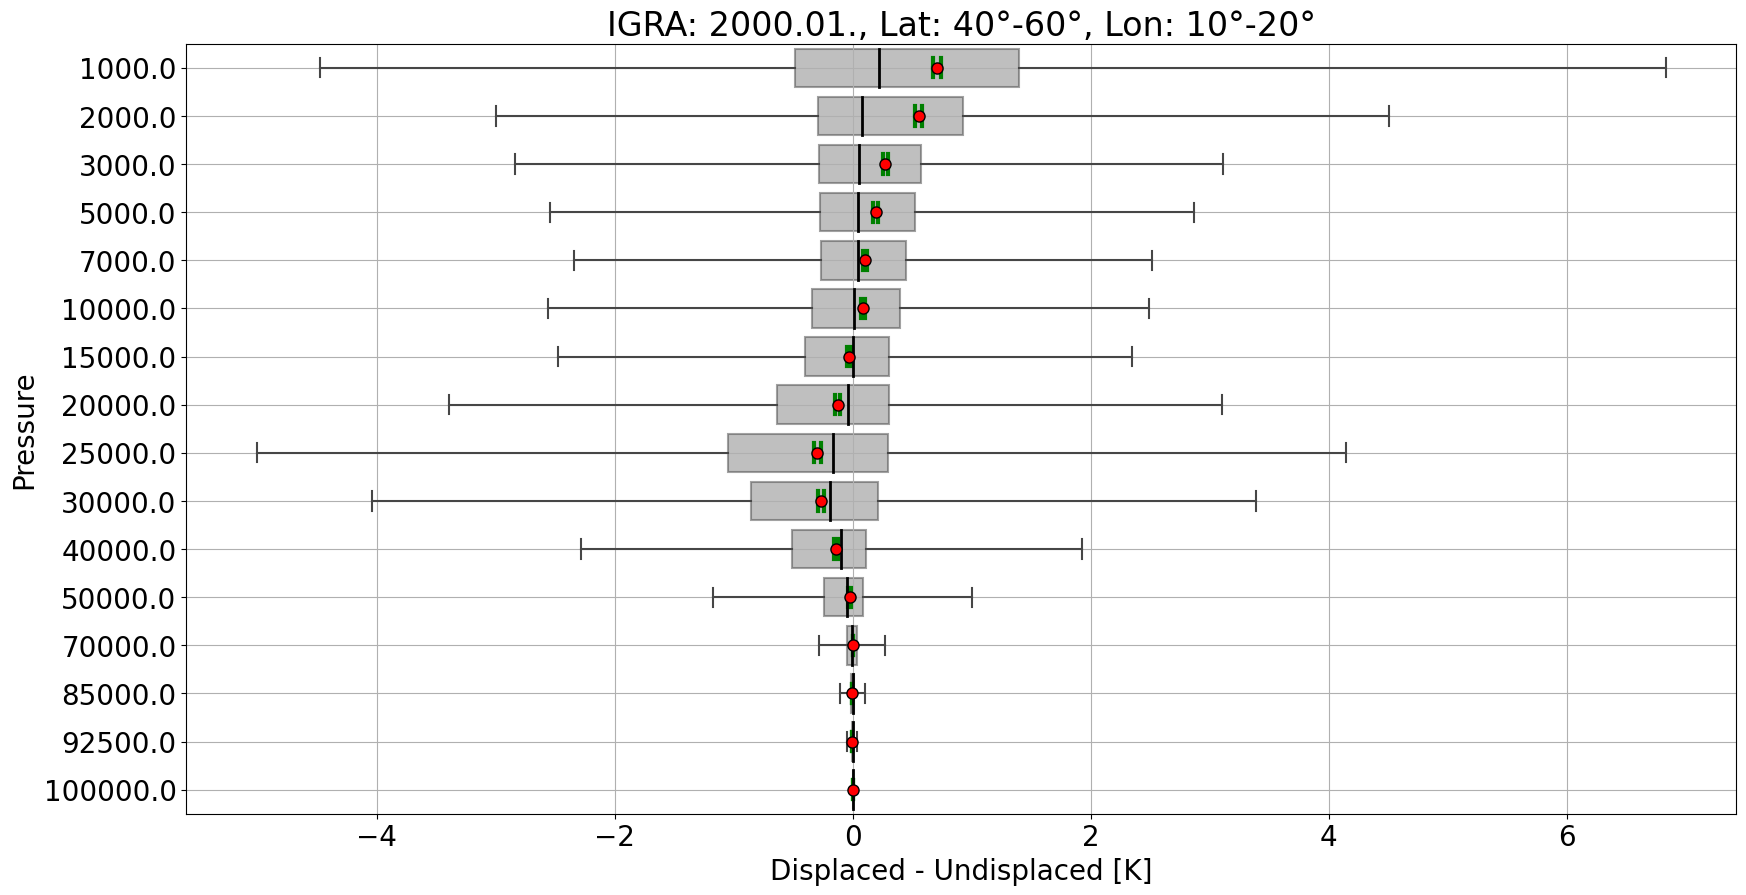

In [70]:
df_plt = pd.DataFrame({'Differences':np.array(plt_diffs).flatten(), 'Pressure': plt_plevs})
df_plt.Pressure = df_plt.Pressure.astype(str)

ax = seaborn.boxplot(
    data=df_plt,
    x='Differences',
    y='Pressure',
    notch=False,
    showcaps=True,
    # fliersize = 100,
    showfliers=False,
    dodge=False,
    showmeans=True,
    boxprops={"facecolor": 'grey', "alpha": 0.5},
    medianprops={"color": 'black', "linewidth": 2,},
    meanprops={
        "marker": "o",
        "markerfacecolor": "red",
        "markeredgecolor": "black",
        "markersize": "8",
    },
    whis=3,
    # whis=1.5,
)
ax.set(xlabel="Displaced - Undisplaced [K]", ylabel="plev [Pa]")
# ax.set_label(Vaisala - Meisei)
kwargs = {'alpha':0}
ax = seaborn.barplot(data=df_plt, x='Differences', y='Pressure', capsize=.4, errorbar=('sd',float(2/np.sqrt(len(df_plt['Differences'])))), errwidth=3, errcolor='green', **kwargs)
ax.set_title('IGRA: 2000.01., Lat: 40°-60°, Lon: 10°-20°')
ax.set_xlabel('Displaced - Undisplaced [K]')
plt.grid()
plt.show()
plt.close()

#### 